In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# **Annually**

In [2]:
!find /content -name "stocks*"

/content/content/sample_data/stocks


In [3]:
def load_all_csvs(files_path):
    dataframes = []
    stock_names = []
    for file in os.listdir(files_path):
        if file.endswith('.csv'):
            df = pd.read_csv(os.path.join(files_path, file))
            dataframes.append(df)
            stock_names.append(file.replace('.csv', ''))
    return dataframes, stock_names

def calculate_yearly_return(df):
    """More accurate return calculation without look-ahead"""
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df['Date'].dt.year

    # Improved return calculation using close-to-close
    df['Daily_Return'] = df['Close'].pct_change()
    yearly_return = df.groupby('Year')['Daily_Return'].apply(
        lambda r: (1 + r).prod() - 1
    )

    yearly_data = df.groupby('Year').agg(
        open_price=('Open', 'first'),
        close_price=('Close', 'last')
    )
    yearly_data['yearly_return'] = yearly_return

    return yearly_data[['open_price', 'close_price', 'yearly_return']]

def investment_simulation(files_path, num_stocks, initial_investment=100):
    dataframes, stock_names = load_all_csvs(files_path)
    investment_per_year = {}
    total_investment = initial_investment
    selected_stocks = {}

    # Track previous year's top performers
    prev_top_stocks = []

    for year in range(2014, 2025):
        yearly_returns = []
        valid_stocks = []

        for df, stock_name in zip(dataframes, stock_names):
            yearly_data = calculate_yearly_return(df)

            # Only consider stocks with data for BOTH current and previous year
            if year in yearly_data.index and (year-1) in yearly_data.index:
                valid_stocks.append(stock_name)
                yearly_returns.append((
                    stock_name,
                    yearly_data.loc[year-1, 'yearly_return'],  # PRIOR year performance
                    yearly_data.loc[year, 'yearly_return'],    # CURRENT year actual return
                    yearly_data
                ))

        if yearly_returns:
            # Sort by PRIOR YEAR performance (no look-ahead)
            sorted_stocks = sorted(yearly_returns, key=lambda x: x[1], reverse=True)

            # Take top N with valid prior year data
            top_n_stocks = sorted_stocks[:num_stocks]

            if top_n_stocks:
                # Invest equally and track performance
                investment_per_stock = total_investment / len(top_n_stocks)
                new_total_investment = 0

                for stock_name, _, current_return, _ in top_n_stocks:
                    new_total_investment += investment_per_stock * (1 + current_return)

                total_investment = new_total_investment
                selected_stocks[year] = [stock[0] for stock in top_n_stocks]

        investment_per_year[year] = total_investment

    return investment_per_year, selected_stocks

results = {}
selected_stocks = {}

for n in range(1, 5):
    investment_result, stocks_selected = investment_simulation(
        '/content/content/sample_data/stocks',
        num_stocks=n,
        initial_investment=100
    )
    results[f'top{n}'] = investment_result
    selected_stocks[f'top{n}'] = stocks_selected

# Print results
for n in range(1, 5):
    final_year = 2023 if 2023 in results[f'top{n}'] else max(results[f'top{n}'].keys())
    print(f"\nTop {n} stocks investment results:")
    print(f"Final investment value: ${results[f'top{n}'][final_year]:.2f}")
    print(f"Return multiplier: {results[f'top{n}'][final_year]/100:.2f}x")

comparison_df = pd.DataFrame({
    f'Top {n} Stocks': pd.Series(results[f'top{n}']) for n in range(1, 5)
})

print("\nYearly investment values comparison:")
print(comparison_df)


Top 1 stocks investment results:
Final investment value: $116.15
Return multiplier: 1.16x

Top 2 stocks investment results:
Final investment value: $129.70
Return multiplier: 1.30x

Top 3 stocks investment results:
Final investment value: $133.61
Return multiplier: 1.34x

Top 4 stocks investment results:
Final investment value: $143.70
Return multiplier: 1.44x

Yearly investment values comparison:
      Top 1 Stocks  Top 2 Stocks  Top 3 Stocks  Top 4 Stocks
2014    100.000000    100.000000    100.000000    100.000000
2015    100.939237    101.455169    104.572477    107.574791
2016    131.496663    116.012038    116.002021    112.689699
2017    166.304324    146.691930    134.963780    131.870466
2018    152.152950    120.314675    111.621292    105.748698
2019    188.215574    141.112790    138.757986    134.502947
2020    177.122249    137.489255    130.937511    124.551974
2021    201.782252    159.364630    146.465709    140.474323
2022    133.248357    141.099908    125.032275   

In [4]:

selected_stocks_df = {}

# For top1 stocks
selected_stocks_df['top1'] = pd.DataFrame.from_dict(
    selected_stocks['top1'],
    orient='index',
    columns=['Stock 1']
)

# For top2 stocks
selected_stocks_df['top2'] = pd.DataFrame.from_dict(
    selected_stocks['top2'],
    orient='index',
    columns=['Stock 1', 'Stock 2']
)

# For top3 stocks
selected_stocks_df['top3'] = pd.DataFrame.from_dict(
    selected_stocks['top3'],
    orient='index',
    columns=['Stock 1', 'Stock 2', 'Stock 3']
)

# For top4 stocks
selected_stocks_df['top4'] = pd.DataFrame.from_dict(
    selected_stocks['top4'],
    orient='index',
    columns=['Stock 1', 'Stock 2', 'Stock 3', 'Stock 4']
)

# Display the DataFrames for each strategy
print("\nTop 1 stocks selected each year:")
print(selected_stocks_df['top1'])

print("\nTop 2 stocks selected each year:")
print(selected_stocks_df['top2'])

print("\nTop 3 stocks selected each year:")
print(selected_stocks_df['top3'])

print("\nTop 4 stocks selected each year:")
print(selected_stocks_df['top4'])


Top 1 stocks selected each year:
              Stock 1
2015           reatil
2016       technology
2017  basic resources
2018  basic resources
2019       healthcare
2020          finance
2021  basic resources
2022           reatil
2023  basic resources
2024       technology

Top 2 stocks selected each year:
              Stock 1          Stock 2
2015           reatil       healthcare
2016       technology          finance
2017  basic resources       technology
2018  basic resources       technology
2019       healthcare  basic resources
2020          finance           reatil
2021  basic resources           reatil
2022           reatil       healthcare
2023  basic resources       healthcare
2024       technology           reatil

Top 3 stocks selected each year:
              Stock 1          Stock 2     Stock 3
2015           reatil       healthcare     finance
2016       technology          finance  healthcare
2017  basic resources       technology  healthcare
2018  basic resources  

In [5]:
def investment_simulation_bottom(files_path, num_stocks, initial_investment=100):
    """
    Simulate investment in bottom N stocks each year based on PRIOR YEAR performance

    Parameters:
    - files_path: Path to directory containing CSV files
    - num_stocks: Number of bottom stocks to select each year (1, 2, 3, or 4)
    - initial_investment: Initial investment amount (default: 100)

    Returns:
    - Dictionary of investment value per year
    - Dictionary of selected stock names per year
    """
    dataframes, stock_names = load_all_csvs(files_path)
    investment_per_year = {}
    total_investment = initial_investment
    selected_stocks = {}

    for year in range(2014, 2025):
        yearly_returns = []
        valid_stocks = []

        for df, stock_name in zip(dataframes, stock_names):
            yearly_data = calculate_yearly_return(df)

            # Only consider stocks with data for BOTH current and previous year
            if year in yearly_data.index and (year-1) in yearly_data.index:
                valid_stocks.append(stock_name)
                yearly_returns.append((
                    stock_name,
                    yearly_data.loc[year-1, 'yearly_return'],  # PRIOR year performance
                    yearly_data.loc[year, 'yearly_return'],    # CURRENT year actual return
                    yearly_data
                ))

        if yearly_returns:
            # Sort by PRIOR YEAR performance (worst first)
            sorted_stocks = sorted(yearly_returns, key=lambda x: x[1])

            # Take bottom N with valid prior year data
            bottom_n_stocks = sorted_stocks[:num_stocks]

            if bottom_n_stocks:
                # Invest equally and track performance
                investment_per_stock = total_investment / len(bottom_n_stocks)
                new_total_investment = 0

                for stock_name, _, current_return, yearly_data in bottom_n_stocks:
                    shares_bought = investment_per_stock / yearly_data.loc[year, 'open_price']
                    new_total_investment += shares_bought * yearly_data.loc[year, 'close_price']

                total_investment = new_total_investment
                selected_stocks[year] = [stock[0] for stock in bottom_n_stocks]

        investment_per_year[year] = total_investment

    return investment_per_year, selected_stocks


# Run simulations for bottom 1-4 stocks (using same code structure as before)
bottom_results = {}
bottom_selected_stocks = {}

for n in range(1, 5):
    investment_result, stocks_selected = investment_simulation_bottom(
        '/content/content/sample_data/stocks',
        num_stocks=n,
        initial_investment=100
    )
    bottom_results[f'bottom{n}'] = investment_result
    bottom_selected_stocks[f'bottom{n}'] = stocks_selected

# Display results (identical format to your original)
for n in range(1, 5):
    final_year = 2023 if 2023 in bottom_results[f'bottom{n}'] else max(bottom_results[f'bottom{n}'].keys())
    print(f"\nBottom {n} stocks investment results:")
    print(f"Final investment value: ${bottom_results[f'bottom{n}'][final_year]:.2f}")
    print(f"Return multiplier: {bottom_results[f'bottom{n}'][final_year]/100:.2f}x")

# Comparison DataFrame
bottom_comparison_df = pd.DataFrame({
    f'Bottom {n} Stocks': pd.Series(bottom_results[f'bottom{n}']) for n in range(1, 5)
})

print("\nYearly investment values comparison (bottom stocks):")
print(bottom_comparison_df)


Bottom 1 stocks investment results:
Final investment value: $201.65
Return multiplier: 2.02x

Bottom 2 stocks investment results:
Final investment value: $225.56
Return multiplier: 2.26x

Bottom 3 stocks investment results:
Final investment value: $192.23
Return multiplier: 1.92x

Bottom 4 stocks investment results:
Final investment value: $179.49
Return multiplier: 1.79x

Yearly investment values comparison (bottom stocks):
      Bottom 1 Stocks  Bottom 2 Stocks  Bottom 3 Stocks  Bottom 4 Stocks
2014       100.000000       100.000000       100.000000       100.000000
2015        53.642051        85.111891        93.676958        95.750494
2016       105.454684       120.356393       120.815925       116.177779
2017       103.539503       130.724608       126.202901       127.736594
2018       113.592094       119.194979       112.083785       108.251539
2019       147.624588       158.404485       150.996232       139.380124
2020       167.289330       158.907907       145.390805    

In [6]:


# Create DataFrames for the selected bottom stocks in each strategy
bottom_selected_stocks_df = {}

# For bottom1 stocks
bottom_selected_stocks_df['bottom1'] = pd.DataFrame.from_dict(
    bottom_selected_stocks['bottom1'],
    orient='index',
    columns=['Stock 1']
)

# For bottom2 stocks
bottom_selected_stocks_df['bottom2'] = pd.DataFrame.from_dict(
    bottom_selected_stocks['bottom2'],
    orient='index',
    columns=['Stock 1', 'Stock 2']
)

# For bottom3 stocks
bottom_selected_stocks_df['bottom3'] = pd.DataFrame.from_dict(
    bottom_selected_stocks['bottom3'],
    orient='index',
    columns=['Stock 1', 'Stock 2', 'Stock 3']
)

# For bottom4 stocks
bottom_selected_stocks_df['bottom4'] = pd.DataFrame.from_dict(
    bottom_selected_stocks['bottom4'],
    orient='index',
    columns=['Stock 1', 'Stock 2', 'Stock 3', 'Stock 4']
)

# Display the DataFrames for each bottom strategy
print("\nBottom 1 stocks selected each year:")
print(bottom_selected_stocks_df['bottom1'])

print("\nBottom 2 stocks selected each year:")
print(bottom_selected_stocks_df['bottom2'])

print("\nBottom 3 stocks selected each year:")
print(bottom_selected_stocks_df['bottom3'])

print("\nBottom 4 stocks selected each year:")
print(bottom_selected_stocks_df['bottom4'])


Bottom 1 stocks selected each year:
              Stock 1
2015  basic resources
2016  basic resources
2017           reatil
2018       healthcare
2019       technology
2020  basic resources
2021       healthcare
2022          finance
2023           reatil
2024  basic resources

Bottom 2 stocks selected each year:
              Stock 1          Stock 2
2015  basic resources       technology
2016  basic resources           reatil
2017           reatil          finance
2018       healthcare           reatil
2019       technology           reatil
2020  basic resources       healthcare
2021       healthcare       technology
2022          finance  basic resources
2023           reatil          finance
2024  basic resources       healthcare

Bottom 3 stocks selected each year:
              Stock 1          Stock 2     Stock 3
2015  basic resources       technology     finance
2016  basic resources           reatil  healthcare
2017           reatil          finance  healthcare
2018       hea

In [7]:
def investment_simulation_median(files_path, num_stocks, initial_investment=100):
    """
    Simulate investment in median N stocks each year based on PRIOR YEAR performance

    Parameters:
    - files_path: Path to directory containing CSV files
    - num_stocks: Number of median stocks to select (1 or 3)
    - initial_investment: Initial investment amount (default: 100)

    Returns:
    - Dictionary of investment value per year
    - Dictionary of selected stock names per year
    """
    dataframes, stock_names = load_all_csvs(files_path)
    investment_per_year = {}
    total_investment = initial_investment
    selected_stocks = {}

    for year in range(2014, 2025):
        yearly_returns = []
        valid_stocks = []

        for df, stock_name in zip(dataframes, stock_names):
            yearly_data = calculate_yearly_return(df)

            # Only consider stocks with data for BOTH current and previous year
            if year in yearly_data.index and (year-1) in yearly_data.index:
                valid_stocks.append(stock_name)
                yearly_returns.append((
                    stock_name,
                    yearly_data.loc[year-1, 'yearly_return'],  # PRIOR year performance
                    yearly_data.loc[year, 'yearly_return'],    # CURRENT year actual return
                    yearly_data
                ))

        if yearly_returns:
            # Sort by PRIOR YEAR performance
            sorted_stocks = sorted(yearly_returns, key=lambda x: x[1])

            # Select median stocks
            mid_index = len(sorted_stocks) // 2

            if num_stocks == 1:
                if len(sorted_stocks) % 2 == 1:  # Odd count
                    median_stocks = [sorted_stocks[mid_index]]
                else:  # Even count
                    median_stocks = [sorted_stocks[mid_index - 1]]
            elif num_stocks == 3:
                start_index = max(0, mid_index - 1)
                median_stocks = sorted_stocks[start_index:start_index + 3]

            if median_stocks:
                # Invest equally at open prices
                investment_per_stock = total_investment / len(median_stocks)
                new_total_investment = 0

                for stock_name, _, current_return, yearly_data in median_stocks:
                    shares_bought = investment_per_stock / yearly_data.loc[year, 'open_price']
                    new_total_investment += shares_bought * yearly_data.loc[year, 'close_price']

                total_investment = new_total_investment
                selected_stocks[year] = [stock[0] for stock in median_stocks]

        investment_per_year[year] = total_investment

    return investment_per_year, selected_stocks

# Run simulations (keeping your exact code structure)
median_results = {}
median_selected_stocks = {}

for n in [1, 3]:
    investment_result, stocks_selected = investment_simulation_median(
        '/content/content/sample_data/stocks',
        num_stocks=n,
        initial_investment=100
    )
    median_results[f'median{n}'] = investment_result
    median_selected_stocks[f'median{n}'] = stocks_selected

# Display results (identical format)
for n in [1, 3]:
    final_year = 2024 if 2024 in median_results[f'median{n}'] else max(median_results[f'median{n}'].keys())
    print(f"\nMedian {n} stocks investment results:")
    print(f"Final investment value: ${median_results[f'median{n}'][final_year]:.2f}")
    print(f"Return multiplier: {median_results[f'median{n}'][final_year]/100:.2f}x")

# Comparison DataFrame
median_comparison_df = pd.DataFrame({
    f'Median {n} Stocks': pd.Series(median_results[f'median{n}']) for n in [1, 3]
})

print("\nYearly investment values comparison (median stocks):")
print(median_comparison_df)


Median 1 stocks investment results:
Final investment value: $158.28
Return multiplier: 1.58x

Median 3 stocks investment results:
Final investment value: $154.86
Return multiplier: 1.55x

Yearly investment values comparison (median stocks):
      Median 1 Stocks  Median 3 Stocks
2014       100.000000       100.000000
2015       110.807094       109.786642
2016       115.342633       105.668140
2017       110.898829       120.325405
2018        93.240047        91.958569
2019       129.008161       118.032776
2020       113.820668       108.708431
2021       118.096362       122.192701
2022        93.320524       125.809943
2023       127.604438       146.521633
2024       158.276740       154.858851


In [8]:
# Create DataFrames for the selected median stocks in each strategy
median_selected_stocks_df = {}

# For median1 stocks
median_selected_stocks_df['median1'] = pd.DataFrame.from_dict(
    median_selected_stocks['median1'],
    orient='index',
    columns=['Stock 1']
)

# For median3 stocks
median_selected_stocks_df['median3'] = pd.DataFrame.from_dict(
    median_selected_stocks['median3'],
    orient='index',
    columns=['Stock 1', 'Stock 2', 'Stock 3']
)

# Display the DataFrames for each median strategy
print("\nMedian 1 stocks selected each year:")
print(median_selected_stocks_df['median1'])

print("\nMedian 3 stocks selected each year:")
print(median_selected_stocks_df['median3'])


Median 1 stocks selected each year:
         Stock 1
2015     finance
2016  healthcare
2017  healthcare
2018     finance
2019     finance
2020  technology
2021     finance
2022  technology
2023  technology
2024     finance

Median 3 stocks selected each year:
              Stock 1     Stock 2          Stock 3
2015       technology     finance       healthcare
2016           reatil  healthcare          finance
2017          finance  healthcare       technology
2018           reatil     finance       technology
2019           reatil     finance  basic resources
2020       healthcare  technology           reatil
2021       technology     finance           reatil
2022  basic resources  technology       healthcare
2023          finance  technology       healthcare
2024       healthcare     finance           reatil



Comparison of all investment strategies:
           Top 1       Top 2       Top 3       Top 4    Median 1    Median 3  \
2014  100.000000  100.000000  100.000000  100.000000  100.000000  100.000000   
2015  100.939237  101.455169  104.572477  107.574791  110.807094  109.786642   
2016  131.496663  116.012038  116.002021  112.689699  115.342633  105.668140   
2017  166.304324  146.691930  134.963780  131.870466  110.898829  120.325405   
2018  152.152950  120.314675  111.621292  105.748698   93.240047   91.958569   
2019  188.215574  141.112790  138.757986  134.502947  129.008161  118.032776   
2020  177.122249  137.489255  130.937511  124.551974  113.820668  108.708431   
2021  201.782252  159.364630  146.465709  140.474323  118.096362  122.192701   
2022  133.248357  141.099908  125.032275  131.665371   93.320524  125.809943   
2023  116.154130  129.696467  133.607058  143.699322  127.604438  146.521633   
2024  126.808364  132.047601  145.926792  153.126995  158.276740  154.858851  

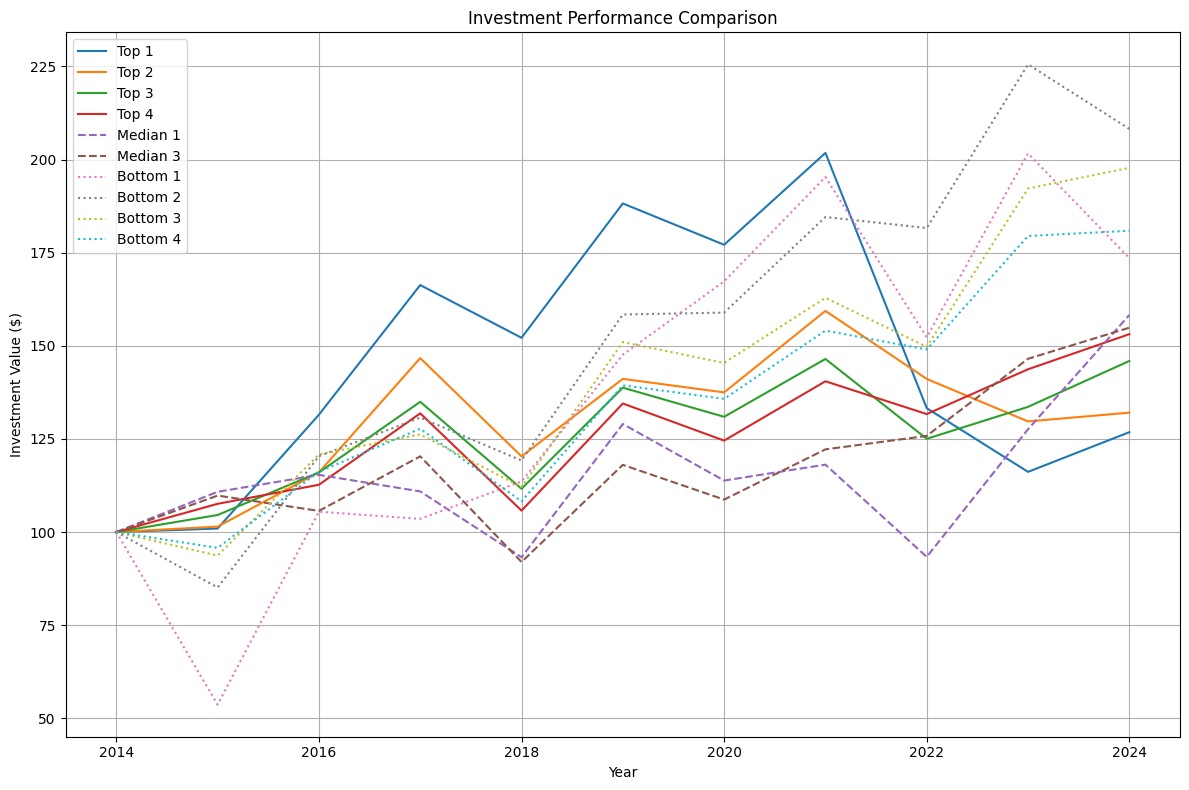

In [9]:
# Create a comprehensive comparison DataFrame
all_strategies_comparison = pd.DataFrame({
    # Top strategies
    'Top 1': pd.Series(results['top1']),
    'Top 2': pd.Series(results['top2']),
    'Top 3': pd.Series(results['top3']),
    'Top 4': pd.Series(results['top4']),

    # Median strategies
    'Median 1': pd.Series(median_results['median1']),
    'Median 3': pd.Series(median_results['median3']),

    # Bottom strategies
    'Bottom 1': pd.Series(bottom_results['bottom1']),
    'Bottom 2': pd.Series(bottom_results['bottom2']),
    'Bottom 3': pd.Series(bottom_results['bottom3']),
    'Bottom 4': pd.Series(bottom_results['bottom4'])
})

# Display the comprehensive comparison
print("\nComparison of all investment strategies:")
print(all_strategies_comparison)

# Calculate the final investment values and return multipliers for all strategies
print("\nFinal investment values and return multipliers:")
strategies = {
    'Top 1': results['top1'],
    'Top 2': results['top2'],
    'Top 3': results['top3'],
    'Top 4': results['top4'],
    'Median 1': median_results['median1'],
    'Median 3': median_results['median3'],
    'Bottom 1': bottom_results['bottom1'],
    'Bottom 2': bottom_results['bottom2'],
    'Bottom 3': bottom_results['bottom3'],
    'Bottom 4': bottom_results['bottom4']
}

summary_data = []
for strategy_name, result in strategies.items():
    final_year = 2023 if 2023 in result else max(result.keys())
    final_value = result[final_year]
    return_multiplier = final_value / 100

    summary_data.append({
        'Strategy': strategy_name,
        'Final Value ($)': final_value,
        'Return Multiplier': return_multiplier
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('Final Value ($)', ascending=False)
print(summary_df)

# Create visualization data
import matplotlib.pyplot as plt

# Plot the performance of all strategies over time
plt.figure(figsize=(12, 8))

# Plot top strategies
for n in range(1, 5):
    plt.plot(list(results[f'top{n}'].keys()), list(results[f'top{n}'].values()), label=f'Top {n}')

# Plot median strategies
for n in [1, 3]:
    plt.plot(list(median_results[f'median{n}'].keys()), list(median_results[f'median{n}'].values()), label=f'Median {n}', linestyle='--')

# Plot bottom strategies
for n in range(1, 5):
    plt.plot(list(bottom_results[f'bottom{n}'].keys()), list(bottom_results[f'bottom{n}'].values()), label=f'Bottom {n}', linestyle=':')

plt.xlabel('Year')
plt.ylabel('Investment Value ($)')
plt.title('Investment Performance Comparison')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save the plot or display it
plt.savefig('investment_performance_comparison.png')


# **Bi-yearly**

In [10]:
def calculate_half_yearly_return(df):
    df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
    df.set_index('Date', inplace=True)

    h1_data = df[df.index.month <= 6].resample('YE').first()['Close']
    h1_end_data = df[df.index.month <= 6].resample('YE').last()['Close']

    h2_data = df[df.index.month > 6].resample('YE').first()['Close']
    h2_end_data = df[df.index.month > 6].resample('YE').last()['Close']

    half_yearly_returns = pd.concat([
        (h1_end_data / h1_data - 1),
        (h2_end_data / h2_data - 1)
    ])

    is_H1 = [True] * len(h1_data) + [False] * len(h2_data)
    years = list(h1_data.index.year) + list(h2_data.index.year)

    return pd.DataFrame({
        'half_yearly_return': half_yearly_returns.values,
        'is_H1': is_H1
    }, index=pd.MultiIndex.from_arrays([years, is_H1], names=['Year', 'H1']))


In [11]:
def load_all_csvs(path):
    all_files = glob.glob(os.path.join(path, "*.csv"))
    dataframes = []
    stock_names = []

    for file in all_files:
        df = pd.read_csv(file)
        stock_name = os.path.basename(file).replace('.csv', '')
        dataframes.append(df)
        stock_names.append(stock_name)

    return dataframes, stock_names


In [12]:
import glob


Top 1 stocks bi-yearly investment results:
Final investment value: $99.52
Return multiplier: 1.00x

Top 2 stocks bi-yearly investment results:
Final investment value: $136.26
Return multiplier: 1.36x

Top 3 stocks bi-yearly investment results:
Final investment value: $179.63
Return multiplier: 1.80x

Top 4 stocks bi-yearly investment results:
Final investment value: $161.81
Return multiplier: 1.62x

Bi-yearly investment values comparison:
         Top 1 Stocks  Top 2 Stocks  Top 3 Stocks  Top 4 Stocks
2014_H1    100.000000    100.000000    100.000000    100.000000
2014_H2     97.638399    101.499184    103.840719     99.063748
2015_H1    107.375617    110.172657    113.031060    104.599223
2015_H2    112.339133    112.554204    112.171821    105.020195
2016_H1    121.982070    122.385019    114.555810    101.937705
2016_H2    165.598608    142.764911    136.228679    119.530974
2017_H1    164.237394    148.405648    144.644122    123.719638
2017_H2    175.009088    166.854077    152.4

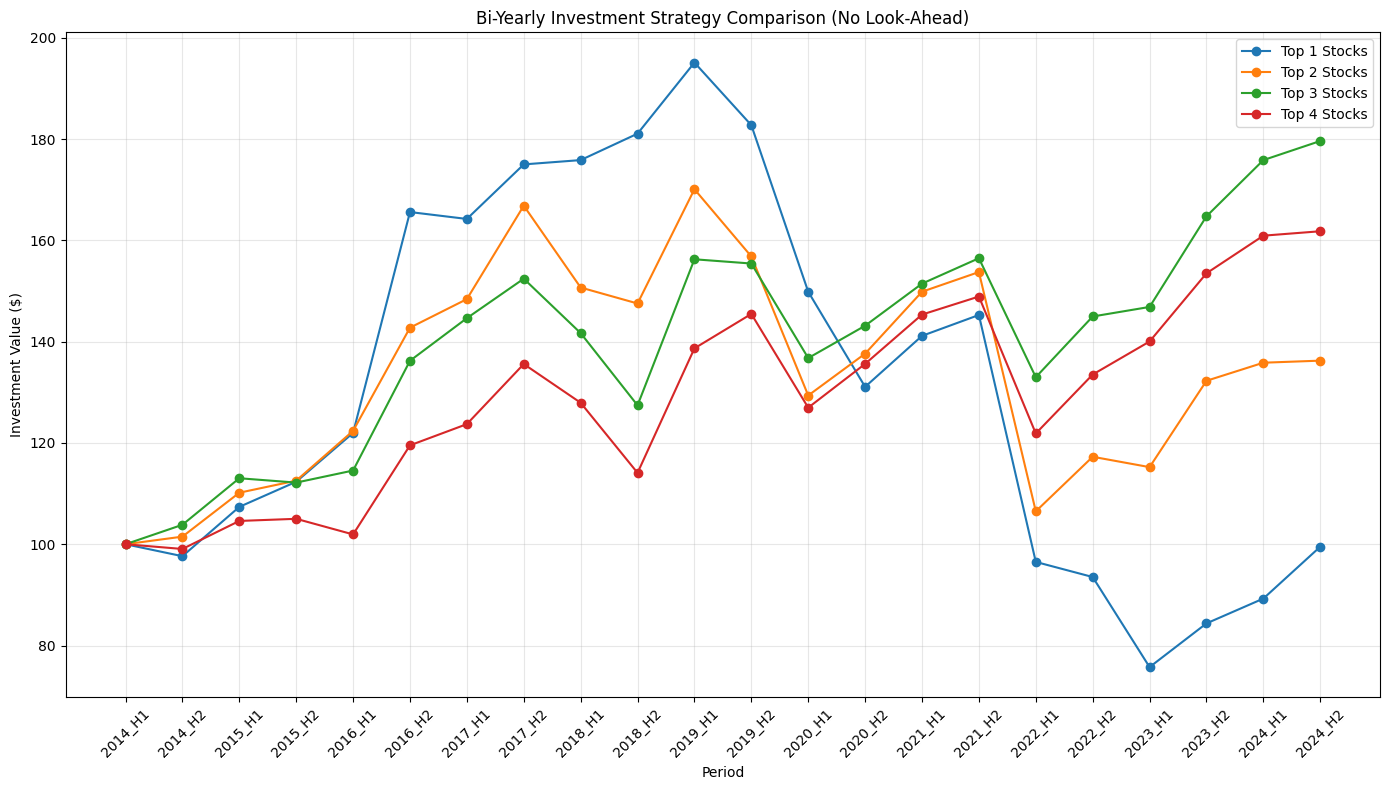

In [13]:
import os, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------- Helpers ----------

def read_price_csv(path):
    """
    Expects a CSV with at least:
      - 'Date' column (parseable to datetime)
      - 'Close' (or 'Adj Close' if you prefer)
    If your files have Year/Month/Day columns, adapt parsing here.
    """
    df = pd.read_csv(path)
    # Try common schemas:
    if {'Year','Month','Day','Close'}.issubset(df.columns):
        df['Date'] = pd.to_datetime(df[['Year','Month','Day']])
    elif 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'])
    else:
        raise ValueError(f"CSV {path} missing a usable date schema.")

    price_col = 'Close' if 'Close' in df.columns else ('Adj Close' if 'Adj Close' in df.columns else None)
    if price_col is None:
        raise ValueError(f"CSV {path} missing Close/Adj Close column.")

    df = df[['Date', price_col]].dropna().sort_values('Date')
    df = df.set_index('Date')
    df.columns = ['Close']
    return df

def load_all_csvs(path):
    files = glob.glob(os.path.join(path, "*.csv"))
    data = {}
    for f in files:
        name = os.path.basename(f).replace('.csv','')
        data[name] = read_price_csv(f)
    return data  # dict: {ticker: df with Close}

def half_key_from_date(dt):
    return (dt.year, 'H1' if dt.month <= 6 else 'H2')

def compute_half_returns(per_ticker_prices):
    """
    Returns a DataFrame indexed by MultiIndex(Year, Half: {'H1','H2'})
    columns = tickers, values = half-period simple returns (last/first - 1)
    """
    # Build per-ticker half returns
    half_ret_map = {}
    for ticker, df in per_ticker_prices.items():
        # Assign half labels
        tmp = df.copy()
        tmp['Year'] = tmp.index.year
        tmp['Half'] = np.where(tmp.index.month <= 6, 'H1', 'H2')
        # For each (Year, Half) compute first and last Close
        g = tmp.groupby(['Year','Half'])['Close']
        half_rets = (g.last() / g.first() - 1).rename(ticker)
        half_ret_map[ticker] = half_rets

    # Align to one DataFrame
    half_returns = pd.concat(half_ret_map.values(), axis=1).sort_index()
    # half_returns.index: MultiIndex(Year, Half)
    return half_returns  # may contain NaNs where a ticker lacks that half

def simulate_topN_halfly(half_returns, num_stocks, start_equity=100.0):
    """
    half_returns: DataFrame indexed by (Year, Half) with per-stock returns
    Strategy: For each period t starting from the SECOND period,
              select top N tickers by returns in period t-1,
              then apply THEIR returns in t to the equity (equal-weight).
    """
    # Ensure chronological order
    half_returns = half_returns.sort_index()

    periods = list(half_returns.index)
    equity_curve = {}
    selections = {}

    equity = start_equity

    # Iterate from second period to last
    for i in range(1, len(periods)):
        prev_period = periods[i-1]
        curr_period = periods[i]

        prev_rets = half_returns.loc[prev_period].dropna()
        if prev_rets.empty:
            # No info to rank -> carry forward equity unchanged
            period_label = f"{curr_period[0]}_{curr_period[1]}"
            equity_curve[period_label] = equity
            selections[period_label] = []
            continue

        # Rank by previous half (descending -> top performers)
        ranked = prev_rets.sort_values(ascending=False)
        chosen = ranked.index[:num_stocks]

        # Apply current half returns of chosen tickers
        curr_rets = half_returns.loc[curr_period].reindex(chosen).dropna()
        if curr_rets.empty:
            # Nothing to invest due to missing current data; carry forward
            period_label = f"{curr_period[0]}_{curr_period[1]}"
            equity_curve[period_label] = equity
            selections[period_label] = list(chosen)
            continue

        # Equal-weight compounding
        w = 1.0 / len(curr_rets)
        period_growth = float((1 + curr_rets).mul(w).sum())
        equity *= period_growth

        # Record
        period_label = f"{curr_period[0]}_{curr_period[1]}"
        equity_curve[period_label] = equity
        selections[period_label] = list(curr_rets.index)

    return equity_curve, selections

# ---------- Driver matching your API ----------

def investment_simulation_top_n_bi_yearly(files_path, num_stocks, initial_investment=100.0):
    """
    Returns:
      - investment_per_half_year: dict period_label -> equity
      - selected_stocks: dict period_label -> [tickers]
    """
    per_ticker_prices = load_all_csvs(files_path)
    half_returns = compute_half_returns(per_ticker_prices)
    equity_curve, selections = simulate_topN_halfly(
        half_returns, num_stocks=num_stocks, start_equity=initial_investment
    )
    # Ensure every period appears (carry forward where needed)
    # Build a dense dict including the very first period as initial equity
    dense = {}
    periods_sorted = list(half_returns.sort_index().index)
    if periods_sorted:
        first_label = f"{periods_sorted[0][0]}_{periods_sorted[0][1]}"
        dense[first_label] = initial_investment
        for p in periods_sorted[1:]:
            lab = f"{p[0]}_{p[1]}"
            dense[lab] = equity_curve.get(lab, list(dense.values())[-1])

    return dense, selections

# ---------- Run your experiments ----------

bi_yearly_results = {}
bi_yearly_selected_stocks = {}

data_path = 'content/sample_data/stocks'  # adjust if needed

for n in range(1, 5):
    investment_result, stocks_selected = investment_simulation_top_n_bi_yearly(
        data_path, num_stocks=n, initial_investment=100
    )
    bi_yearly_results[f'top{n}'] = investment_result
    bi_yearly_selected_stocks[f'top{n}'] = stocks_selected

# ---------- Print summaries ----------
for n in range(1, 5):
    print(f"\nTop {n} stocks bi-yearly investment results:")
    if not bi_yearly_results[f'top{n}']:
        print("No data.")
        continue
    last_period = list(bi_yearly_results[f'top{n}'].keys())[-1]
    final_value = bi_yearly_results[f'top{n}'][last_period]
    print(f"Final investment value: ${final_value:.2f}")
    print(f"Return multiplier: {final_value/100:.2f}x")

# ---------- Comparison DataFrame ----------
# Align all series to the same index
all_periods = sorted({p for d in bi_yearly_results.values() for p in d.keys()})
bi_yearly_comparison_df = pd.DataFrame(index=all_periods)
for n in range(1, 5):
    s = pd.Series(bi_yearly_results[f'top{n}'])
    bi_yearly_comparison_df[f'Top {n} Stocks'] = s

print("\nBi-yearly investment values comparison:")
print(bi_yearly_comparison_df)

# ---------- Selected stocks per strategy ----------
bi_yearly_selected_stocks_df = {}
for n in range(1, 5):
    # Find max number of picks (n) for consistent columns
    cols = [f'Stock {i+1}' for i in range(n)]
    # Normalize selections dict into a DataFrame
    sel_map = bi_yearly_selected_stocks[f'top{n}']
    df_sel = pd.DataFrame.from_dict(sel_map, orient='index')
    # Ensure consistent number of columns
    if df_sel.shape[1] < n:
        df_sel = df_sel.reindex(columns=range(n))
    df_sel.columns = cols
    bi_yearly_selected_stocks_df[f'top{n}'] = df_sel
    print(f"\nTop {n} stocks selected for each half-year period:")
    print(df_sel)

# ---------- Plot ----------
plt.figure(figsize=(14, 8))
for n in range(1, 5):
    series = pd.Series(bi_yearly_results[f'top{n}']).sort_index()
    plt.plot(range(len(series)), series.values, marker='o', label=f'Top {n} Stocks')

# X-axis labels
xticks = pd.Index(bi_yearly_comparison_df.index)
plt.xticks(range(len(xticks)), xticks, rotation=45)
plt.xlabel('Period')
plt.ylabel('Investment Value ($)')
plt.title('Bi-Yearly Investment Strategy Comparison (No Look-Ahead)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('bi_yearly_investment_comparison.png')
# plt.show()



Bottom 1 stocks bi-yearly investment results:
Final investment value: $148.49
Return multiplier: 1.48x

Bottom 2 stocks bi-yearly investment results:
Final investment value: $141.71
Return multiplier: 1.42x

Bottom 3 stocks bi-yearly investment results:
Final investment value: $180.94
Return multiplier: 1.81x

Bottom 4 stocks bi-yearly investment results:
Final investment value: $181.58
Return multiplier: 1.82x

Bi-yearly bottom investment values comparison:
         Bottom 1 Stocks  Bottom 2 Stocks  Bottom 3 Stocks  Bottom 4 Stocks
2014_H1       100.000000       100.000000       100.000000       100.000000
2014_H2       109.401228        97.067031       100.885951       102.004455
2015_H1        98.647893        90.258087        99.349516       102.654520
2015_H2        59.172578        73.954773        85.198890        91.611691
2016_H1        86.944325        84.610550        90.232533        97.705962
2016_H2        92.360115        92.440098       102.853012       107.356352
2017

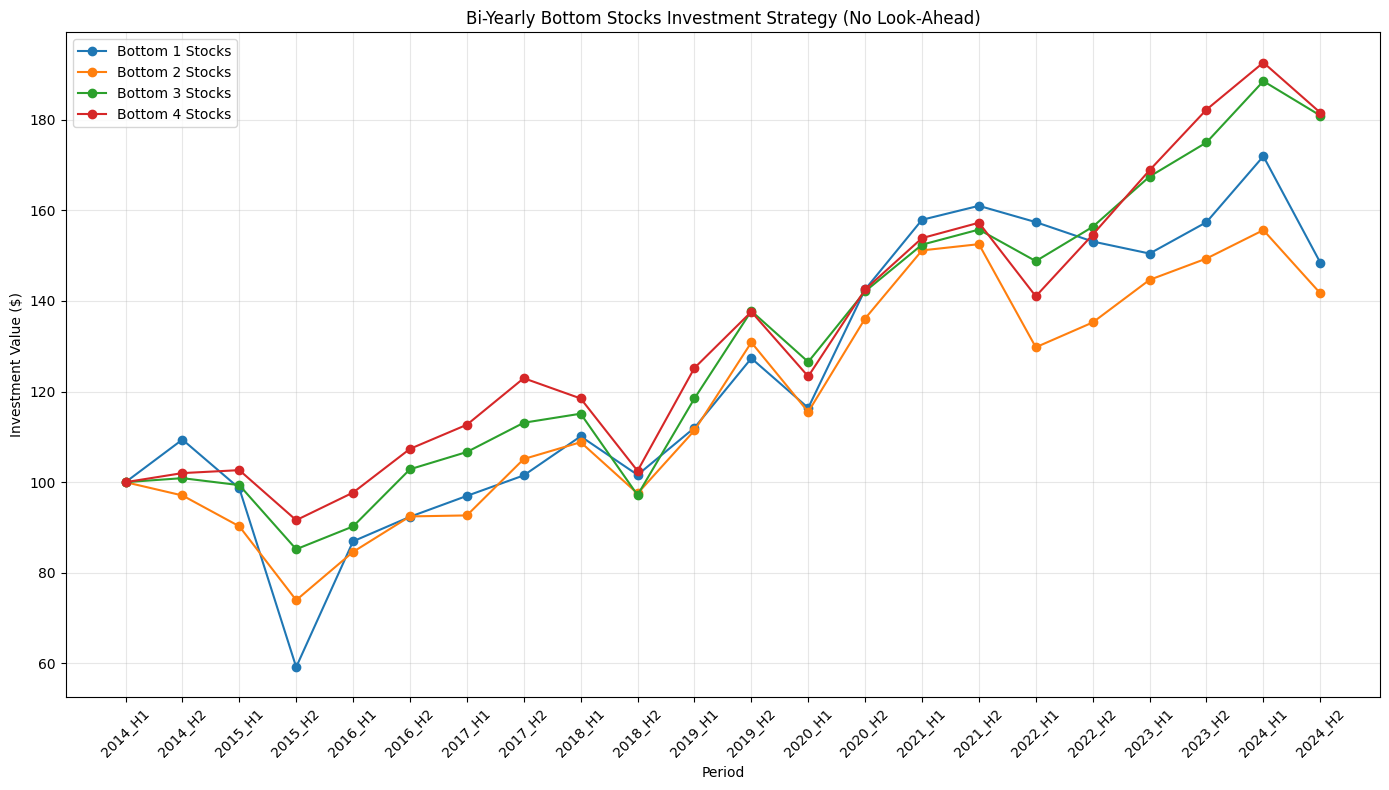

In [14]:
def read_price_csv(path):
    df = pd.read_csv(path)
    if {'Year','Month','Day','Close'}.issubset(df.columns):
        df['Date'] = pd.to_datetime(df[['Year','Month','Day']])
    elif 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'])
    else:
        raise ValueError(f"CSV {path} missing a usable date schema.")

    price_col = 'Close' if 'Close' in df.columns else ('Adj Close' if 'Adj Close' in df.columns else None)
    if price_col is None:
        raise ValueError(f"CSV {path} missing Close/Adj Close column.")

    df = df[['Date', price_col]].dropna().sort_values('Date')
    df = df.set_index('Date')
    df.columns = ['Close']
    return df

def load_all_csvs_prices(path):
    files = glob.glob(os.path.join(path, "*.csv"))
    data = {}
    for f in files:
        name = os.path.basename(f).replace('.csv','')
        data[name] = read_price_csv(f)
    return data  # dict: {ticker: df with Close}

def compute_half_returns(per_ticker_prices):
    half_ret_map = {}
    for ticker, df in per_ticker_prices.items():
        tmp = df.copy()
        tmp['Year'] = tmp.index.year
        tmp['Half'] = np.where(tmp.index.month <= 6, 'H1', 'H2')
        g = tmp.groupby(['Year','Half'])['Close']
        half_rets = (g.last() / g.first() - 1).rename(ticker)
        half_ret_map[ticker] = half_rets
    half_returns = pd.concat(half_ret_map.values(), axis=1).sort_index()
    return half_returns  # MultiIndex(Year, Half) x tickers


def simulate_bottomN_halfly(half_returns, num_stocks, start_equity=100.0):
    """
    For each period t starting from the second period:
      - rank by period t-1 returns ASC (worst first)
      - pick bottom N
      - apply THEIR returns in t (equal-weight)
    """
    half_returns = half_returns.sort_index()
    periods = list(half_returns.index)

    equity_curve = {}
    selections = {}
    equity = start_equity

    for i in range(1, len(periods)):
        prev_period = periods[i-1]
        curr_period = periods[i]

        prev_rets = half_returns.loc[prev_period].dropna()
        period_label = f"{curr_period[0]}_{curr_period[1]}"

        if prev_rets.empty:
            equity_curve[period_label] = equity
            selections[period_label] = []
            continue

        ranked = prev_rets.sort_values(ascending=True)           # bottom first
        chosen = ranked.index[:num_stocks]

        curr_rets = half_returns.loc[curr_period].reindex(chosen).dropna()
        if curr_rets.empty:
            equity_curve[period_label] = equity
            selections[period_label] = list(chosen)
            continue

        w = 1.0 / len(curr_rets)
        period_growth = float((1 + curr_rets).mul(w).sum())
        equity *= period_growth

        equity_curve[period_label] = equity
        selections[period_label] = list(curr_rets.index)

    return equity_curve, selections

def investment_simulation_bottom_n_bi_yearly(files_path, num_stocks, initial_investment=100.0):
    """
    Returns:
      - investment_per_half_year: dict period_label -> equity
      - selected_stocks: dict period_label -> [tickers]
    """
    per_ticker_prices = load_all_csvs_prices(files_path)
    half_returns = compute_half_returns(per_ticker_prices)
    equity_curve, selections = simulate_bottomN_halfly(
        half_returns, num_stocks=num_stocks, start_equity=initial_investment
    )

    # make a dense dict with the very first period seeded at initial equity
    dense = {}
    periods_sorted = list(half_returns.sort_index().index)
    if periods_sorted:
        first_label = f"{periods_sorted[0][0]}_{periods_sorted[0][1]}"
        dense[first_label] = initial_investment
        for p in periods_sorted[1:]:
            lab = f"{p[0]}_{p[1]}"
            dense[lab] = equity_curve.get(lab, list(dense.values())[-1])

    return dense, selections

# ---------- Run simulations for bottom 1..4 ----------

bi_yearly_bottom_results = {}
bi_yearly_bottom_selected_stocks = {}

data_path = 'content/sample_data/stocks'  # adjust if needed

for n in range(1, 5):
    investment_result, stocks_selected = investment_simulation_bottom_n_bi_yearly(
        data_path, num_stocks=n, initial_investment=100
    )
    bi_yearly_bottom_results[f'bottom{n}'] = investment_result
    bi_yearly_bottom_selected_stocks[f'bottom{n}'] = stocks_selected

# ---------- Display summaries ----------
for n in range(1, 5):
    print(f"\nBottom {n} stocks bi-yearly investment results:")
    if not bi_yearly_bottom_results[f'bottom{n}']:
        print("No data.")
        continue
    last_period = list(bi_yearly_bottom_results[f'bottom{n}'].keys())[-1]
    final_value = bi_yearly_bottom_results[f'bottom{n}'][last_period]
    print(f"Final investment value: ${final_value:.2f}")
    print(f"Return multiplier: {final_value/100:.2f}x")

# ---------- Comparison DataFrame ----------
all_periods = sorted({p for d in bi_yearly_bottom_results.values() for p in d.keys()})
bi_yearly_bottom_comparison_df = pd.DataFrame(index=all_periods)
for n in range(1, 5):
    bi_yearly_bottom_comparison_df[f'Bottom {n} Stocks'] = pd.Series(bi_yearly_bottom_results[f'bottom{n}'])

print("\nBi-yearly bottom investment values comparison:")
print(bi_yearly_bottom_comparison_df)

# ---------- Selected stocks per strategy ----------
bi_yearly_bottom_selected_stocks_df = {}
for n in range(1, 5):
    cols = [f'Stock {i+1}' for i in range(n)]
    sel_map = bi_yearly_bottom_selected_stocks[f'bottom{n}']
    df_sel = pd.DataFrame.from_dict(sel_map, orient='index')
    if df_sel.shape[1] < n:
        df_sel = df_sel.reindex(columns=range(n))
    df_sel.columns = cols
    bi_yearly_bottom_selected_stocks_df[f'bottom{n}'] = df_sel
    print(f"\nBottom {n} stocks selected for each half-year period:")
    print(df_sel)

# ---------- Plot ----------
plt.figure(figsize=(14, 8))
for n in range(1, 5):
    series = pd.Series(bi_yearly_bottom_results[f'bottom{n}']).sort_index()
    plt.plot(range(len(series)), series.values, marker='o', label=f'Bottom {n} Stocks')

xticks = pd.Index(bi_yearly_bottom_comparison_df.index)
plt.xticks(range(len(xticks)), xticks, rotation=45)
plt.xlabel('Period')
plt.ylabel('Investment Value ($)')
plt.title('Bi-Yearly Bottom Stocks Investment Strategy (No Look-Ahead)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('bi_yearly_bottom_investment_comparison.png')
# plt.show()


In [15]:
import os, glob
import pandas as pd
import numpy as np

# ---------- keep these helpers once in your file ----------

def read_price_csv(path):
    df = pd.read_csv(path)
    if {'Year','Month','Day','Close'}.issubset(df.columns):
        df['Date'] = pd.to_datetime(df[['Year','Month','Day']])
    elif 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'])
    else:
        raise ValueError(f"CSV {path} missing a usable date schema.")

    price_col = 'Close' if 'Close' in df.columns else ('Adj Close' if 'Adj Close' in df.columns else None)
    if price_col is None:
        raise ValueError(f"CSV {path} missing Close/Adj Close column.")

    df = df[['Date', price_col]].dropna().sort_values('Date').set_index('Date')
    df.columns = ['Close']
    return df

def load_all_csvs_prices(path):
    files = glob.glob(os.path.join(path, "*.csv"))
    data = {}
    for f in files:
        name = os.path.basename(f).replace('.csv','')
        data[name] = read_price_csv(f)
    return data  # {ticker: DataFrame(DateIndex, Close)}

def compute_half_returns(per_ticker_prices):
    """
    Returns DataFrame indexed by MultiIndex(Year, Half='H1'/'H2')
    columns=tickers, values=simple half returns (last/first - 1).
    """
    half_ret_map = {}
    for ticker, df in per_ticker_prices.items():
        tmp = df.copy()
        tmp['Year'] = tmp.index.year
        tmp['Half'] = np.where(tmp.index.month <= 6, 'H1', 'H2')
        g = tmp.groupby(['Year','Half'])['Close']
        half_rets = (g.last() / g.first() - 1).rename(ticker)
        half_ret_map[ticker] = half_rets
    half_returns = pd.concat(half_ret_map.values(), axis=1).sort_index()
    return half_returns

# ---------- median-N simulator (no look-ahead) ----------

def _pick_median_tickers(prev_rets: pd.Series, n: int):
    """
    prev_rets: Series of previous-half returns (index=tickers), NaNs dropped.
    n: 1 or 3
    Returns list of chosen tickers around the median by descending rank.
    """
    ranked = prev_rets.sort_values(ascending=False)  # top -> bottom
    m = len(ranked)
    if m == 0:
        return []

    if n == 1:
        mid = m // 2
        return [ranked.index[mid]]

    # n == 3
    if m <= 3:
        return list(ranked.index)  # take what's available
    mid = m // 2
    start = max(0, mid - 1)
    end = min(m, start + 3)
    # adjust start if near the end
    start = max(0, end - 3)
    return list(ranked.index[start:end])

def simulate_medianN_halfly(half_returns: pd.DataFrame, num_stocks: int, start_equity: float = 100.0):
    """
    For each period t starting from the SECOND half:
      - rank previous half (t-1) returns DESC
      - pick median 1 or median 3
      - apply THEIR returns in current half t (equal-weight)
    """
    assert num_stocks in (1, 3), "Median strategy supports num_stocks = 1 or 3."

    half_returns = half_returns.sort_index()
    periods = list(half_returns.index)

    equity_curve = {}
    selections = {}
    equity = start_equity

    for i in range(1, len(periods)):
        prev_period = periods[i-1]
        curr_period = periods[i]
        label = f"{curr_period[0]}_{curr_period[1]}"

        prev_rets = half_returns.loc[prev_period].dropna()
        chosen = _pick_median_tickers(prev_rets, num_stocks)

        if not chosen:
            equity_curve[label] = equity
            selections[label] = []
            continue

        curr_rets = half_returns.loc[curr_period].reindex(chosen).dropna()
        if curr_rets.empty:
            equity_curve[label] = equity
            selections[label] = chosen
            continue

        w = 1.0 / len(curr_rets)
        growth = float((1 + curr_rets).mul(w).sum())
        equity *= growth

        equity_curve[label] = equity
        selections[label] = list(curr_rets.index)

    return equity_curve, selections

def investment_simulation_median_n_bi_yearly(files_path, num_stocks, initial_investment=100.0):
    """
    Returns:
      - investment_per_half_year: dict period_label -> equity
      - selected_stocks: dict period_label -> [tickers]
    """
    per_ticker_prices = load_all_csvs_prices(files_path)
    half_returns = compute_half_returns(per_ticker_prices)
    equity_curve, selections = simulate_medianN_halfly(
        half_returns, num_stocks=num_stocks, start_equity=initial_investment
    )

    # Dense dict with the first half seeded at initial equity; carry forward where missing
    dense = {}
    periods_sorted = list(half_returns.index)
    if periods_sorted:
        first_label = f"{periods_sorted[0][0]}_{periods_sorted[0][1]}"
        dense[first_label] = initial_investment
        for p in periods_sorted[1:]:
            lab = f"{p[0]}_{p[1]}"
            dense[lab] = equity_curve.get(lab, list(dense.values())[-1])

    return dense, selections

# ---------- Run median-1 and median-3 (NO GRAPH) ----------

bi_yearly_median_results = {}
bi_yearly_median_selected_stocks = {}

data_path = 'content/sample_data/stocks'  # adjust if needed

for n in [1, 3]:
    res, picks = investment_simulation_median_n_bi_yearly(
        data_path, num_stocks=n, initial_investment=100
    )
    bi_yearly_median_results[f'median{n}'] = res
    bi_yearly_median_selected_stocks[f'median{n}'] = picks

# Summaries (no plot)
for n in [1, 3]:
    print(f"\nMedian {n} stocks bi-yearly investment results:")
    if not bi_yearly_median_results[f'median{n}']:
        print("No data.")
        continue
    last_period = list(bi_yearly_median_results[f'median{n}'].keys())[-1]
    final_value = bi_yearly_median_results[f'median{n}'][last_period]
    print(f"Final investment value: ${final_value:.2f}")
    print(f"Return multiplier: {final_value/100:.2f}x")

# Comparison DataFrame
all_periods = sorted({p for d in bi_yearly_median_results.values() for p in d.keys()})
bi_yearly_median_comparison_df = pd.DataFrame(index=all_periods)
for n in [1, 3]:
    bi_yearly_median_comparison_df[f'Median {n} Stocks'] = pd.Series(bi_yearly_median_results[f'median{n}'])

print("\nBi-yearly median investment values comparison:")
print(bi_yearly_median_comparison_df)

# Selected tickers tables (no plot)
bi_yearly_median_selected_stocks_df = {}
bi_yearly_median_selected_stocks_df['median1'] = pd.DataFrame.from_dict(
    bi_yearly_median_selected_stocks['median1'], orient='index', columns=['Stock 1']
)
bi_yearly_median_selected_stocks_df['median3'] = pd.DataFrame.from_dict(
    bi_yearly_median_selected_stocks['median3'], orient='index'
)
# ensure exactly 3 columns for readability
if bi_yearly_median_selected_stocks_df['median3'].shape[1] < 3:
    bi_yearly_median_selected_stocks_df['median3'] = bi_yearly_median_selected_stocks_df['median3'].reindex(columns=range(3))
bi_yearly_median_selected_stocks_df['median3'].columns = ['Stock 1','Stock 2','Stock 3']

print("\nMedian 1 stocks selected for each half-year period:")
print(bi_yearly_median_selected_stocks_df['median1'])

print("\nMedian 3 stocks selected for each half-year period:")
print(bi_yearly_median_selected_stocks_df['median3'])



Median 1 stocks bi-yearly investment results:
Final investment value: $254.03
Return multiplier: 2.54x

Median 3 stocks bi-yearly investment results:
Final investment value: $179.66
Return multiplier: 1.80x

Bi-yearly median investment values comparison:
         Median 1 Stocks  Median 3 Stocks
2014_H1       100.000000       100.000000
2014_H2       108.523790        99.538864
2015_H1       118.790725       103.645979
2015_H2       110.945978       102.605124
2016_H1        98.639091        95.653855
2016_H2       121.772512       106.264691
2017_H1       134.717153       111.520895
2017_H2       122.991303       123.344007
2018_H1       120.814326       113.866110
2018_H2        89.385301        96.314315
2019_H1       122.741372       121.500317
2019_H2       139.920774       132.004829
2020_H1       138.498803       117.530342
2020_H2       140.207524       133.111925
2021_H1       139.716501       142.448539
2021_H2       146.349611       145.715896
2022_H1       170.396813      


Comparison of all bi-yearly investment strategies:
              Top 1       Top 2       Top 3       Top 4    Median 1  \
2014_H1  100.000000  100.000000  100.000000  100.000000  100.000000   
2014_H2   97.638399  101.499184  103.840719   99.063748  108.523790   
2015_H1  107.375617  110.172657  113.031060  104.599223  118.790725   
2015_H2  112.339133  112.554204  112.171821  105.020195  110.945978   
2016_H1  121.982070  122.385019  114.555810  101.937705   98.639091   
2016_H2  165.598608  142.764911  136.228679  119.530974  121.772512   
2017_H1  164.237394  148.405648  144.644122  123.719638  134.717153   
2017_H2  175.009088  166.854077  152.434709  135.585500  122.991303   
2018_H1  175.860983  150.695168  141.693684  127.936588  120.814326   
2018_H2  181.080993  147.541336  127.429839  114.095452   89.385301   
2019_H1  195.121127  170.103365  156.271964  138.683854  122.741372   
2019_H2  182.752347  156.829298  155.432973  145.478660  139.920774   
2020_H1  149.862333  129.

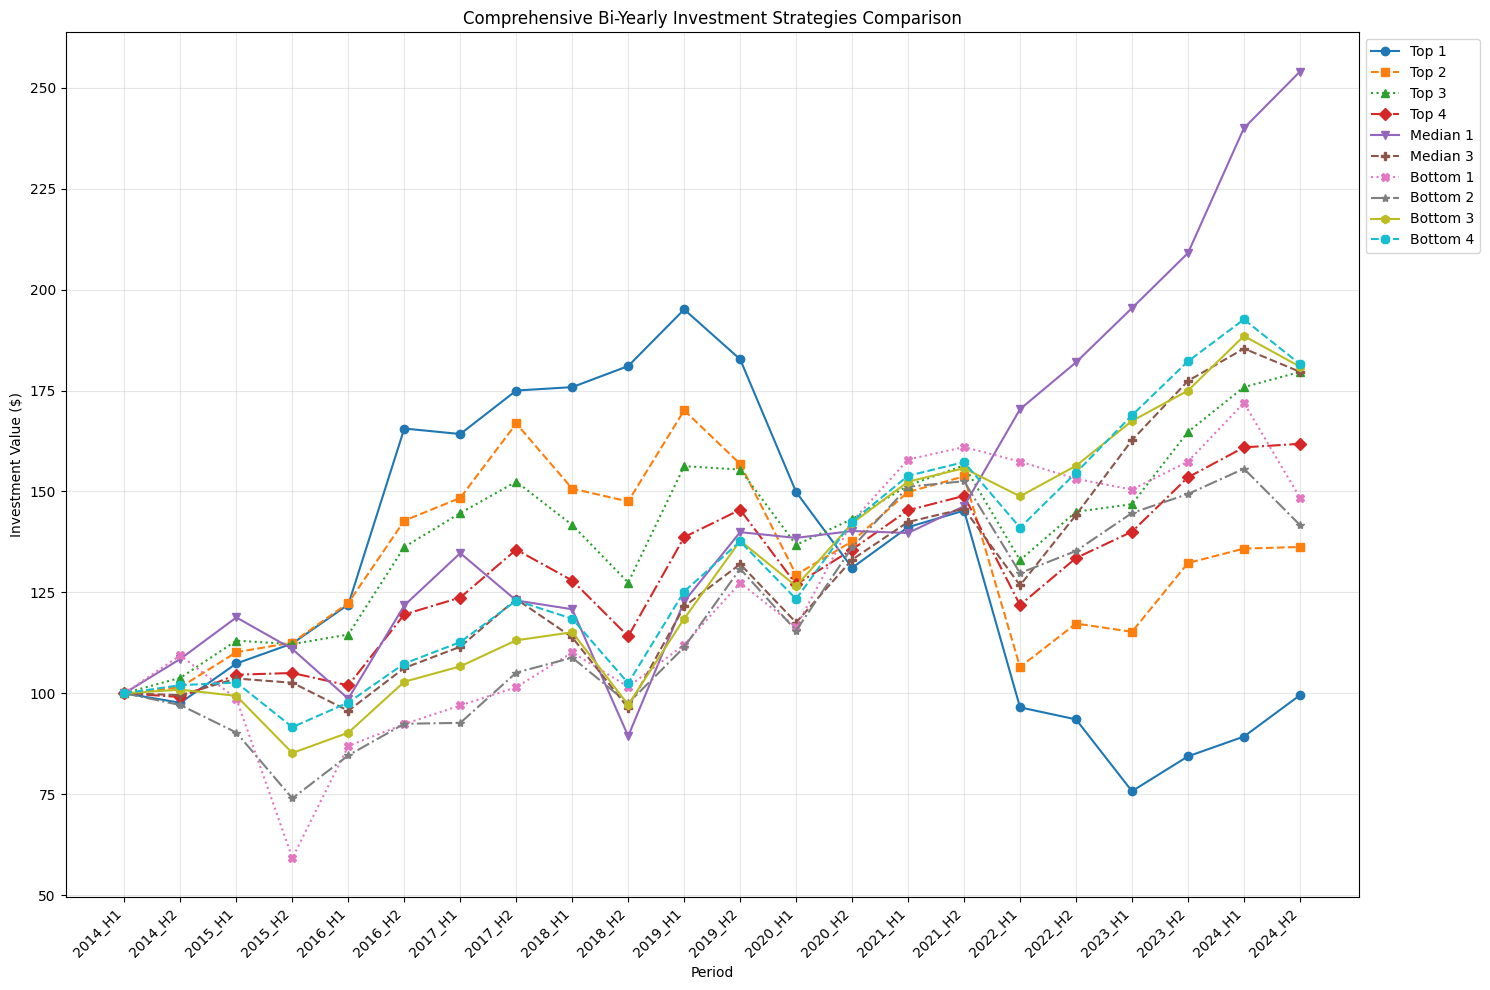

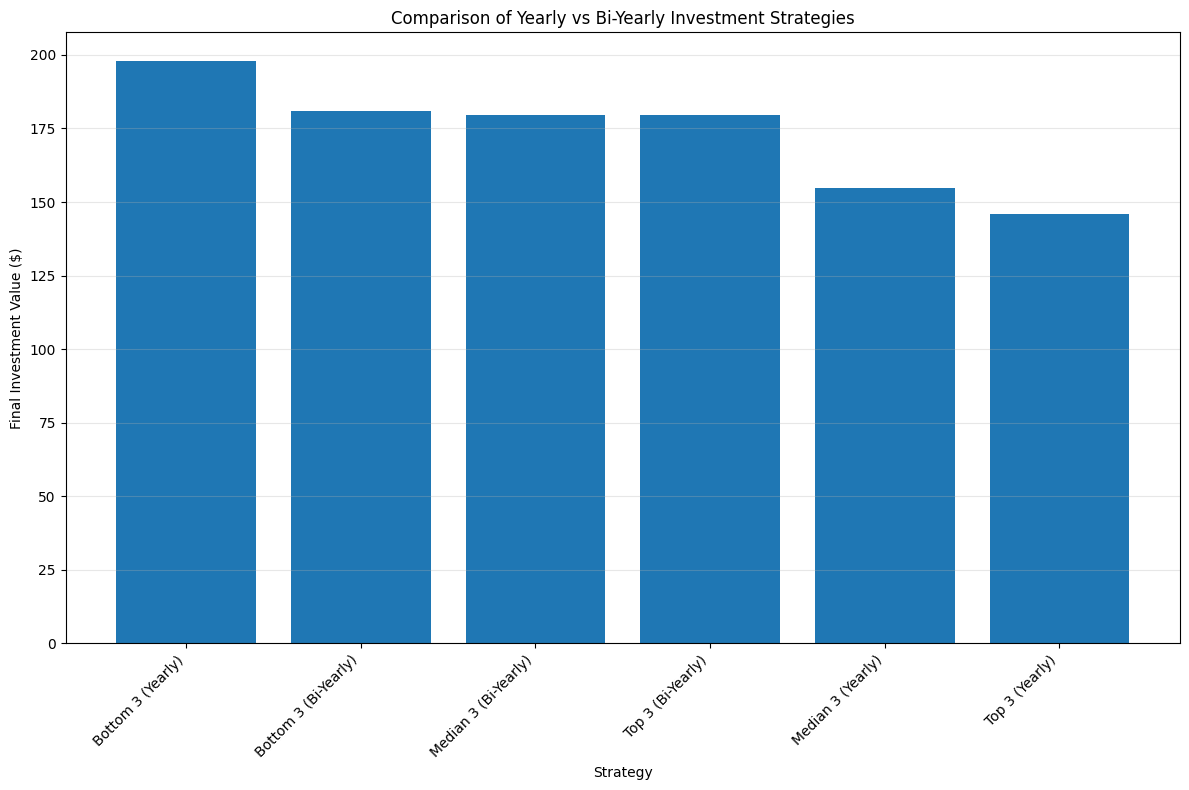

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------
# Helpers
# ----------------------------
def align_series_dict(named_dicts):
    """
    named_dicts: dict[strategy_name] -> dict[period_label] -> value
    Returns a DataFrame with union of all period labels as index,
    columns per strategy, values aligned.
    """
    all_periods = sorted({p for d in named_dicts.values() for p in d.keys()})
    df = pd.DataFrame(index=all_periods)
    for name, d in named_dicts.items():
        df[name] = pd.Series(d)
    return df

def final_value_of(series_dict):
    """Return the last value of a dict-like time series."""
    if not series_dict:
        return float('nan')
    # Ensure chronological order by key string (period labels like '2014_H1')
    last_key = sorted(series_dict.keys())[-1]
    return series_dict[last_key]

def summarize_strategies(named_dicts, initial=100.0):
    rows = []
    for name, d in named_dicts.items():
        fv = final_value_of(d)
        rows.append({
            "Strategy": name,
            "Final Value ($)": fv,
            "Return Multiplier": (fv / initial) if pd.notna(fv) else float('nan'),
        })
    out = pd.DataFrame(rows).sort_values("Final Value ($)", ascending=False)
    return out

def plot_multiple_series(named_dicts, title, outfile):
    """
    Plots multiple dict series on a shared x-axis (union of period labels).
    Distinct markers/styles for groups.
    """
    # Build aligned DF
    df = align_series_dict(named_dicts)
    # Plot
    plt.figure(figsize=(15, 10))
    # Assign a simple style cycle
    markers = ['o', 's', '^', 'D', 'v', 'P', 'X', '*', 'h', '8', 'p', '>']
    linestyles = ['-', '--', ':', '-.']

    for i, col in enumerate(df.columns):
        marker = markers[i % len(markers)]
        linestyle = linestyles[i % len(linestyles)]
        plt.plot(range(len(df.index)), df[col].values, marker=marker, linestyle=linestyle, label=col)

    plt.xticks(range(len(df.index)), df.index, rotation=45, ha='right')
    plt.xlabel('Period')
    plt.ylabel('Investment Value ($)')
    plt.title(title)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(outfile)
    # plt.show()  # keep commented for non-interactive runs
    return df

# ----------------------------
# Build comprehensive bi-yearly comparison
# ----------------------------
bi_all = {
    # Top
    'Top 1':    bi_yearly_results['top1'],
    'Top 2':    bi_yearly_results['top2'],
    'Top 3':    bi_yearly_results['top3'],
    'Top 4':    bi_yearly_results['top4'],
    # Median
    'Median 1': bi_yearly_median_results['median1'],
    'Median 3': bi_yearly_median_results['median3'],
    # Bottom
    'Bottom 1': bi_yearly_bottom_results['bottom1'],
    'Bottom 2': bi_yearly_bottom_results['bottom2'],
    'Bottom 3': bi_yearly_bottom_results['bottom3'],
    'Bottom 4': bi_yearly_bottom_results['bottom4'],
}

all_bi_yearly_strategies_comparison = align_series_dict(bi_all)

print("\nComparison of all bi-yearly investment strategies:")
print(all_bi_yearly_strategies_comparison)

# ----------------------------
# Bi-yearly summary table
# ----------------------------
print("\nFinal investment values and return multipliers (bi-yearly strategies):")
bi_yearly_summary_df = summarize_strategies(bi_all, initial=100.0)
print(bi_yearly_summary_df)

# ----------------------------
# Combined bi-yearly plot (fixed x-axis + labeling)
# ----------------------------
_ = plot_multiple_series(
    bi_all,
    title='Comprehensive Bi-Yearly Investment Strategies Comparison',
    outfile='comprehensive_bi_yearly_strategies_comparison.png'
)

# ----------------------------
# Yearly vs Bi-Yearly comparison (optional)
# Expects yearly dicts named: results (Top), median_results, bottom_results
# with same shape: dict[strategy_key] -> dict[period_label] -> value
# Strategies compared: Top 3, Median 3, Bottom 3
# ----------------------------
yearly_vs_biyearly_comparison = None
have_yearly = all(
    name in globals() for name in ['results', 'median_results', 'bottom_results']
)

if have_yearly:
    try:
        yearly_vs_biyearly_comparison = pd.DataFrame([
            {"Strategy": "Top 3 (Yearly)",    "Final Value": final_value_of(results['top3'])},
            {"Strategy": "Top 3 (Bi-Yearly)", "Final Value": final_value_of(bi_yearly_results['top3'])},
            {"Strategy": "Median 3 (Yearly)", "Final Value": final_value_of(median_results['median3'])},
            {"Strategy": "Median 3 (Bi-Yearly)", "Final Value": final_value_of(bi_yearly_median_results['median3'])},
            {"Strategy": "Bottom 3 (Yearly)", "Final Value": final_value_of(bottom_results['bottom3'])},
            {"Strategy": "Bottom 3 (Bi-Yearly)", "Final Value": final_value_of(bi_yearly_bottom_results['bottom3'])},
        ]).sort_values('Final Value', ascending=False)

        print("\nComparison of Yearly vs Bi-Yearly Strategies (Top 3, Median 3, Bottom 3):")
        print(yearly_vs_biyearly_comparison)

        # Bar chart
        plt.figure(figsize=(12, 8))
        plt.bar(yearly_vs_biyearly_comparison['Strategy'], yearly_vs_biyearly_comparison['Final Value'])
        plt.xticks(rotation=45, ha='right')
        plt.xlabel('Strategy')
        plt.ylabel('Final Investment Value ($)')
        plt.title('Comparison of Yearly vs Bi-Yearly Investment Strategies')
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.savefig('yearly_vs_biyearly_comparison.png')
        # plt.show()
    except KeyError as e:
        print("\n[Note] Skipped Yearly vs Bi-Yearly comparison: missing key:", e)
else:
    print("\n[Note] Skipped Yearly vs Bi-Yearly comparison: "
          "`results`, `median_results`, or `bottom_results` not found in scope.")



Average Volatility of Bi-Yearly Strategies:
Median 1 Volatility    13.400642
Bottom 1 Volatility    13.325071
Top 1 Volatility       11.278367
Bottom 4 Volatility    11.089529
Bottom 2 Volatility    10.581600
Bottom 3 Volatility    10.271868
Median 3 Volatility     9.883789
Top 2 Volatility        9.047437
Top 3 Volatility        8.575427
Top 4 Volatility        8.149348
dtype: float64

Return-to-Volatility Analysis:
   Strategy  Total Return  Average Yearly Return  Average Volatility  \
4  Median 1      1.540332               0.088449           13.400642   
2     Top 3      0.796303               0.054691            8.575427   
5  Median 3      0.796625               0.054709            9.883789   
3     Top 4      0.618079               0.044720            8.149348   
8  Bottom 3      0.809422               0.055389           10.271868   
9  Bottom 4      0.815820               0.055728           11.089529   
1     Top 2      0.362551               0.028523            9.047437   
7 

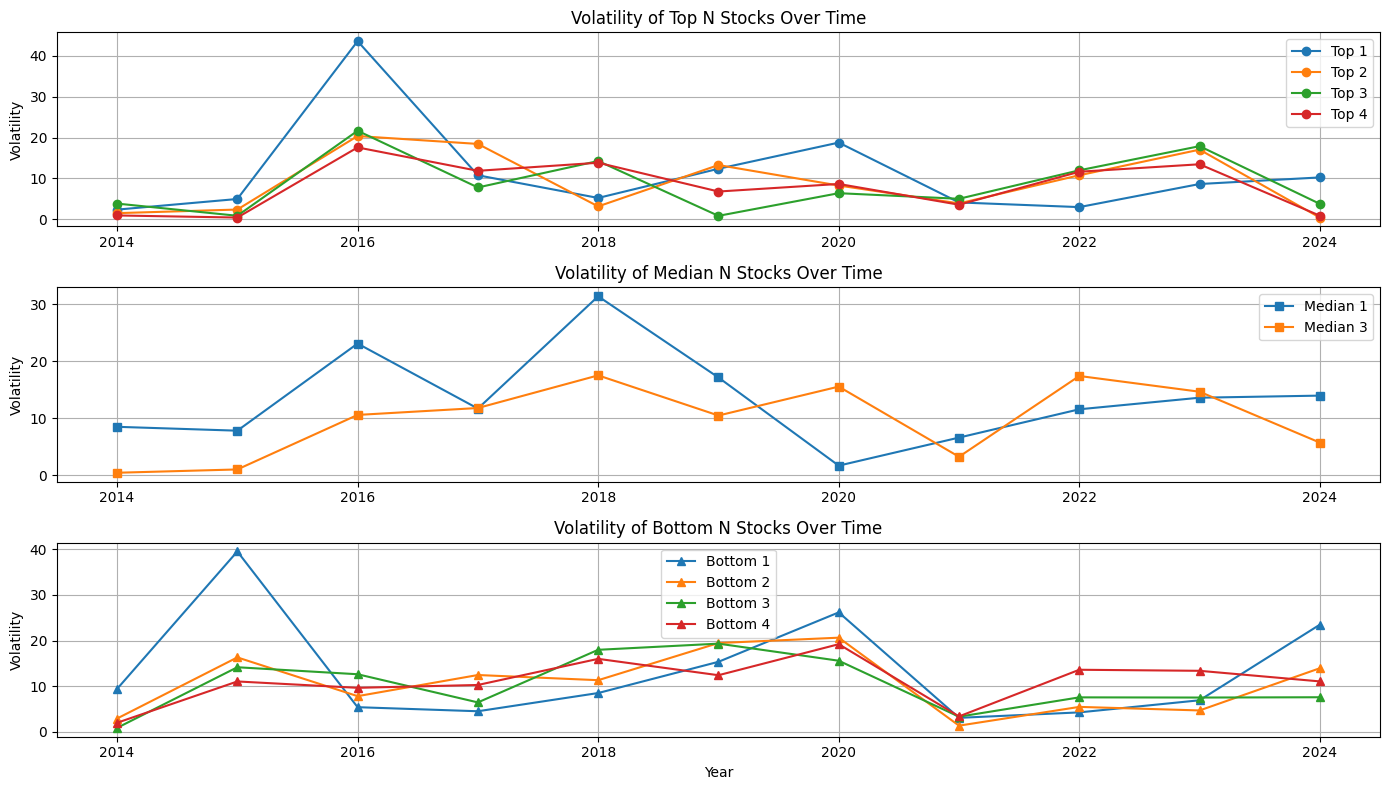

In [17]:
# Create lists from the bi-yearly investment results
top1_bi_year = list(bi_yearly_results['top1'].values())
top2_bi_year = list(bi_yearly_results['top2'].values())
top3_bi_year = list(bi_yearly_results['top3'].values())
top4_bi_year = list(bi_yearly_results['top4'].values())

median1_bi_year = list(bi_yearly_median_results['median1'].values())
median3_bi_year = list(bi_yearly_median_results['median3'].values())

bottom1_bi_year = list(bi_yearly_bottom_results['bottom1'].values())
bottom2_bi_year = list(bi_yearly_bottom_results['bottom2'].values())
bottom3_bi_year = list(bi_yearly_bottom_results['bottom3'].values())
bottom4_bi_year = list(bi_yearly_bottom_results['bottom4'].values())

# Create a DataFrame with all bi-yearly strategies
bi_yearly_df = pd.DataFrame({
    'Top 1 Bi-Yearly': top1_bi_year,
    'Top 2 Bi-Yearly': top2_bi_year,
    'Top 3 Bi-Yearly': top3_bi_year,
    'Top 4 Bi-Yearly': top4_bi_year,
    'Median 1 Bi-Yearly': median1_bi_year,
    'Median 3 Bi-Yearly': median3_bi_year,
    'Bottom 1 Bi-Yearly': bottom1_bi_year,
    'Bottom 2 Bi-Yearly': bottom2_bi_year,
    'Bottom 3 Bi-Yearly': bottom3_bi_year,
    'Bottom 4 Bi-Yearly': bottom4_bi_year
})

# Function to calculate volatility for any strategy
def calculate_volatility(strategy_values, scale_factor=np.sqrt(2)):
    return [strategy_values.iloc[i:i+2].std() * scale_factor for i in range(0, len(strategy_values), 2)]

# Calculate volatility for all strategies
volatility_top1 = calculate_volatility(bi_yearly_df['Top 1 Bi-Yearly'])
volatility_top2 = calculate_volatility(bi_yearly_df['Top 2 Bi-Yearly'])
volatility_top3 = calculate_volatility(bi_yearly_df['Top 3 Bi-Yearly'])
volatility_top4 = calculate_volatility(bi_yearly_df['Top 4 Bi-Yearly'])

volatility_median1 = calculate_volatility(bi_yearly_df['Median 1 Bi-Yearly'])
volatility_median3 = calculate_volatility(bi_yearly_df['Median 3 Bi-Yearly'])

volatility_bottom1 = calculate_volatility(bi_yearly_df['Bottom 1 Bi-Yearly'])
volatility_bottom2 = calculate_volatility(bi_yearly_df['Bottom 2 Bi-Yearly'])
volatility_bottom3 = calculate_volatility(bi_yearly_df['Bottom 3 Bi-Yearly'])
volatility_bottom4 = calculate_volatility(bi_yearly_df['Bottom 4 Bi-Yearly'])

# Create a DataFrame with volatilities
volatility_df = pd.DataFrame({
    'Top 1 Volatility': volatility_top1,
    'Top 2 Volatility': volatility_top2,
    'Top 3 Volatility': volatility_top3,
    'Top 4 Volatility': volatility_top4,
    'Median 1 Volatility': volatility_median1,
    'Median 3 Volatility': volatility_median3,
    'Bottom 1 Volatility': volatility_bottom1,
    'Bottom 2 Volatility': volatility_bottom2,
    'Bottom 3 Volatility': volatility_bottom3,
    'Bottom 4 Volatility': volatility_bottom4
})

# Set proper years as index
years = list(range(2014, 2025))
volatility_df.index = years

# Calculate average volatility for each strategy
mean_volatilities = volatility_df.mean()
mean_volatilities = mean_volatilities.sort_values(ascending=False)

print("\nAverage Volatility of Bi-Yearly Strategies:")
print(mean_volatilities)

# Calculate return-to-volatility ratio (Sharpe-like ratio)
# First get the final values for each strategy
strategies = ['Top 1', 'Top 2', 'Top 3', 'Top 4', 'Median 1', 'Median 3', 'Bottom 1', 'Bottom 2', 'Bottom 3', 'Bottom 4']
final_values = []
average_yearly_returns = []
average_volatilities = []

# Calculate years elapsed
years_elapsed = 2024 - 2013

for strategy in strategies:
    # Get the appropriate values based on strategy type
    if 'Top' in strategy:
        strategy_num = int(strategy.split()[-1])
        final_value = list(bi_yearly_results[f'top{strategy_num}'].values())[-1] / 100 - 1
    elif 'Median' in strategy:
        strategy_num = int(strategy.split()[-1])
        final_value = list(bi_yearly_median_results[f'median{strategy_num}'].values())[-1] / 100 - 1
    elif 'Bottom' in strategy:
        strategy_num = int(strategy.split()[-1])
        final_value = list(bi_yearly_bottom_results[f'bottom{strategy_num}'].values())[-1] / 100 - 1

    # Calculate average yearly return
    avg_yearly_return = (1 + final_value)**(1/years_elapsed) - 1

    # Get average volatility for this strategy
    avg_volatility = mean_volatilities[f'{strategy} Volatility']

    # Store values
    final_values.append(final_value)
    average_yearly_returns.append(avg_yearly_return)
    average_volatilities.append(avg_volatility)

# Calculate return-to-volatility ratios
return_to_volatility_ratios = [ret/vol if vol > 0 else 0 for ret, vol in zip(average_yearly_returns, average_volatilities)]

# Create DataFrame with all metrics
return_to_vol_df = pd.DataFrame({
    'Strategy': strategies,
    'Total Return': final_values,
    'Average Yearly Return': average_yearly_returns,
    'Average Volatility': average_volatilities,
    'Return-to-Volatility Ratio': return_to_volatility_ratios
})

# Sort by Return-to-Volatility Ratio
return_to_vol_df = return_to_vol_df.sort_values('Return-to-Volatility Ratio', ascending=False)

print("\nReturn-to-Volatility Analysis:")
print(return_to_vol_df)

# Visualization of volatility over time
plt.figure(figsize=(14, 8))

# Plot top strategies
plt.subplot(3, 1, 1)
for n in range(1, 5):
    plt.plot(volatility_df.index, volatility_df[f'Top {n} Volatility'], marker='o', label=f'Top {n}')
plt.title('Volatility of Top N Stocks Over Time')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)

# Plot median strategies
plt.subplot(3, 1, 2)
for n in [1, 3]:
    plt.plot(volatility_df.index, volatility_df[f'Median {n} Volatility'], marker='s', label=f'Median {n}')
plt.title('Volatility of Median N Stocks Over Time')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)

# Plot bottom strategies
plt.subplot(3, 1, 3)
for n in range(1, 5):
    plt.plot(volatility_df.index, volatility_df[f'Bottom {n} Volatility'], marker='^', label=f'Bottom {n}')
plt.title('Volatility of Bottom N Stocks Over Time')
plt.xlabel('Year')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('volatility_analysis.png')
# plt.show()  # Uncomment this line for interactive display

# **Quaterly**


Top 1 stocks quarterly investment results:
Final investment value: $133.75
Return multiplier: 1.34x

Top 2 stocks quarterly investment results:
Final investment value: $110.52
Return multiplier: 1.11x

Top 3 stocks quarterly investment results:
Final investment value: $163.85
Return multiplier: 1.64x

Top 4 stocks quarterly investment results:
Final investment value: $165.53
Return multiplier: 1.66x


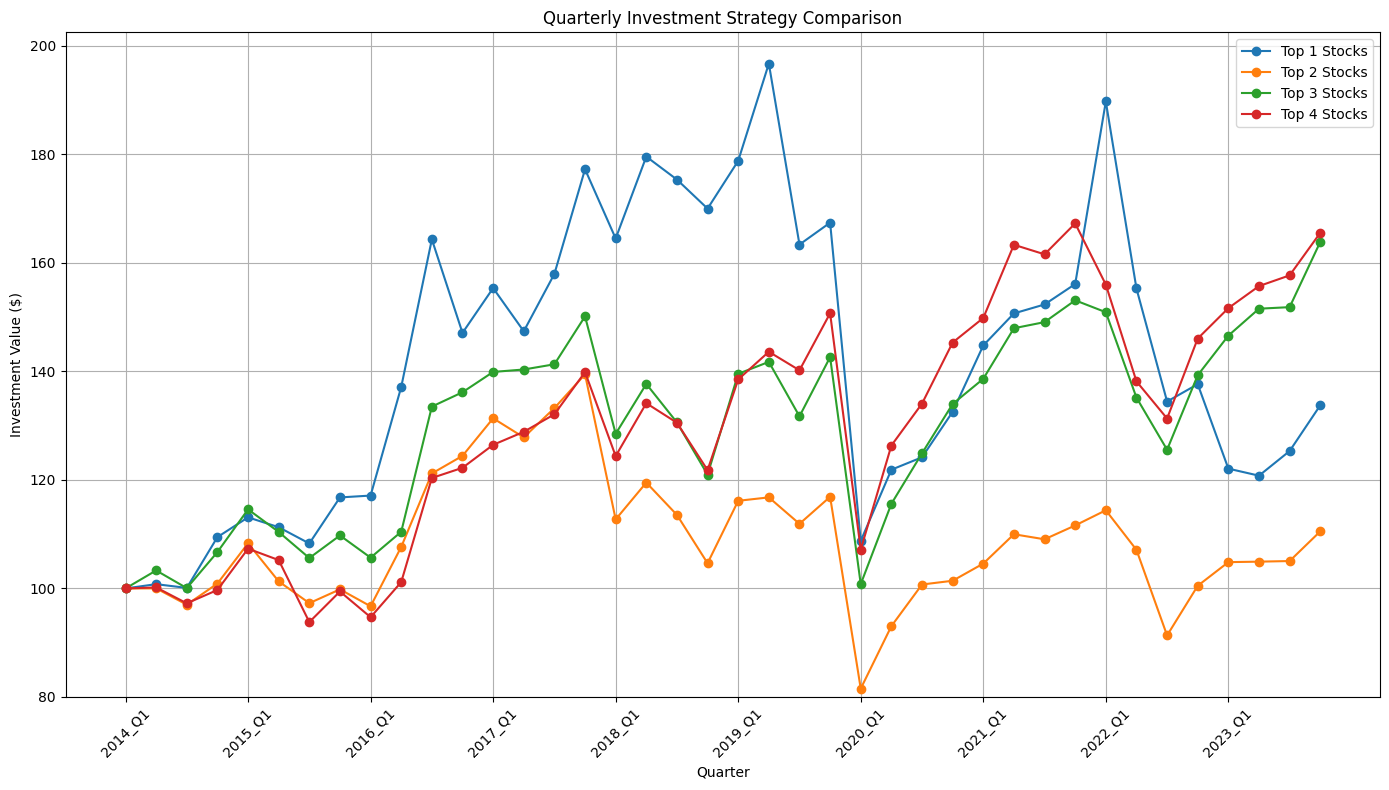

In [18]:
def load_all_csvs(files_path):
    dataframes = []
    stock_names = []

    for filename in os.listdir(files_path):
        if filename.endswith(".csv"):
            file_path = os.path.join(files_path, filename)
            df = pd.read_csv(file_path)
            dataframes.append(df)
            stock_names.append(filename.replace('.csv', ''))

    return dataframes, stock_names

def calculate_quarterly_data(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df['Date'].dt.year
    df['Quarter'] = df['Date'].dt.quarter

    # Group by Year and Quarter and get the last closing price
    quarterly_data = df.groupby(['Year', 'Quarter']).agg(
        close_price=('Close', 'last')
    )

    return quarterly_data

def investment_simulation_top_n_quarterly(files_path, num_stocks, initial_investment=100):
    dataframes, stock_names = load_all_csvs(files_path)

    # Pre-calculate all quarterly returns
    all_returns = {}
    for df, name in zip(dataframes, stock_names):
        quarterly_data = calculate_quarterly_data(df)
        quarterly_data['return'] = quarterly_data['close_price'].pct_change()
        all_returns[name] = quarterly_data

    investment_per_quarter = {}
    selected_stocks = {}
    current_value = initial_investment

    # Initialize
    investment_per_quarter['2014_Q1'] = initial_investment

    for year in range(2014, 2024):
        for quarter in range(1, 5):
            period = f'{year}_Q{quarter}'

            # Skip initial period
            if year == 2013 and quarter == 1:
                continue

            # Determine prior quarter for selection
            if quarter == 1:
                prev_year, prev_quarter = year - 1, 4
            else:
                prev_year, prev_quarter = year, quarter - 1

            # Collect candidates with prior returns
            candidates = []
            for name in stock_names:
                if (prev_year, prev_quarter) in all_returns[name].index and (year, quarter) in all_returns[name].index:
                    prior_return = all_returns[name].loc[(prev_year, prev_quarter), 'return']
                    current_price = all_returns[name].loc[(year, quarter), 'close_price']
                    candidates.append((name, prior_return, current_price))

            if not candidates:
                investment_per_quarter[period] = current_value
                continue

            # Select based on PRIOR returns
            top_n_stocks = sorted(candidates, key=lambda x: x[1], reverse=True)[:num_stocks]

            # Invest equally
            investment_per_stock = current_value / len(top_n_stocks)
            current_value = sum(investment_per_stock * (1 + (stock[2]/all_returns[stock[0]].loc[(prev_year, prev_quarter), 'close_price'] - 1))
                          for stock in top_n_stocks)

            investment_per_quarter[period] = current_value
            selected_stocks[period] = [stock[0] for stock in top_n_stocks]

    return investment_per_quarter, selected_stocks

# Run simulations for top 1, 2, 3, and 4 stocks
quarterly_results = {}
quarterly_selected_stocks = {}

for n in range(1, 5):
    investment_result, stocks_selected = investment_simulation_top_n_quarterly('/content/content/sample_data/stocks', num_stocks=n, initial_investment=100)
    quarterly_results[f'top{n}'] = investment_result
    quarterly_selected_stocks[f'top{n}'] = stocks_selected

# Display results
for n in range(1, 5):
    print(f"\nTop {n} stocks quarterly investment results:")
    final_period = max(quarterly_results[f'top{n}'].keys())
    final_value = quarterly_results[f'top{n}'][final_period]
    print(f"Final investment value: ${final_value:.2f}")
    print(f"Return multiplier: {final_value/100:.2f}x")

# Create a dataframe to compare all quarterly strategies
quarterly_comparison_df = pd.DataFrame({
    f'Top {n} Stocks': pd.Series(quarterly_results[f'top{n}']) for n in range(1, 5)
})

# Plot the results
plt.figure(figsize=(14, 8))

for n in range(1, 5):
    periods = list(quarterly_results[f'top{n}'].keys())
    values = list(quarterly_results[f'top{n}'].values())
    plt.plot(range(len(periods)), values, marker='o', label=f'Top {n} Stocks')

plt.xticks(range(0, len(periods), 4), [periods[i] for i in range(0, len(periods), 4)], rotation=45)
plt.xlabel('Quarter')
plt.ylabel('Investment Value ($)')
plt.title('Quarterly Investment Strategy Comparison')
plt.legend()
plt.grid(True)
plt.ylim(bottom=80)  # Set y-axis minimum to clearly show any drops below initial investment

plt.tight_layout()
plt.savefig('quarterly_investment_comparison_fixed.png')
# plt.show()  # Uncomment this line for interactive display


Median 1 stocks quarterly investment results:
Final investment value: $321.42
Return multiplier: 3.21x

Median 3 stocks quarterly investment results:
Final investment value: $168.57
Return multiplier: 1.69x

Median 1 stocks selected for each quarter:
                 Stock 1
2014_Q2       healthcare
2014_Q3  basic resources
2014_Q4           reatil
2015_Q1       technology
2015_Q2       technology
2015_Q3          finance
2015_Q4          finance
2016_Q1          finance
2016_Q2          finance
2016_Q3       technology
2016_Q4          finance
2017_Q1           reatil
2017_Q2          finance
2017_Q3       healthcare
2017_Q4       technology
2018_Q1          finance
2018_Q2  basic resources
2018_Q3  basic resources
2018_Q4       technology
2019_Q1       technology
2019_Q2  basic resources
2019_Q3  basic resources
2019_Q4           reatil
2020_Q1          finance
2020_Q2          finance
2020_Q3       technology
2020_Q4  basic resources
2021_Q1           reatil
2021_Q2       technolog

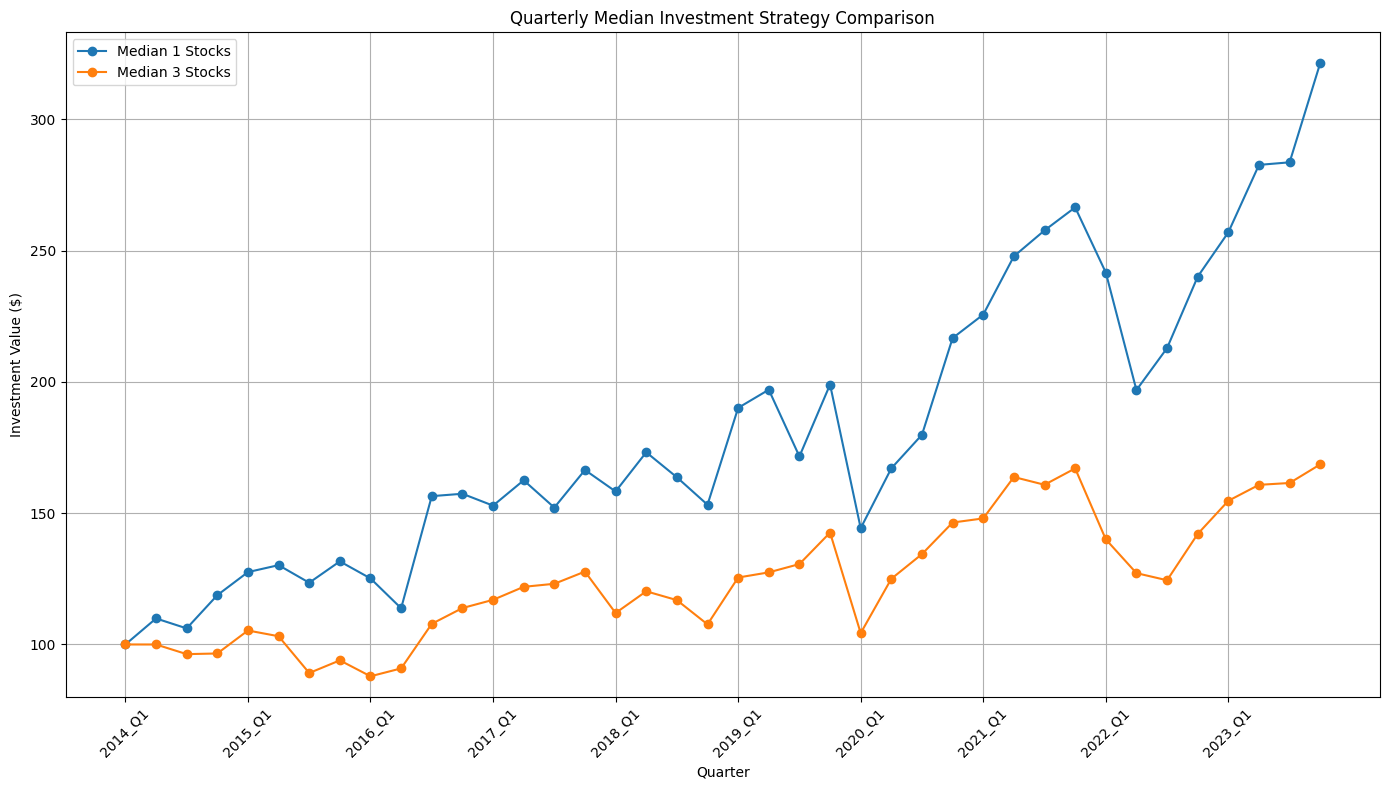

In [19]:
def load_all_csvs(files_path):
    dataframes = []
    stock_names = []  # Adding stock names for better tracking

    for filename in os.listdir(files_path):
        if filename.endswith(".csv"):
            file_path = os.path.join(files_path, filename)
            df = pd.read_csv(file_path)
            dataframes.append(df)
            stock_names.append(filename.replace('.csv', ''))

    return dataframes, stock_names

def calculate_quarterly_data(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df['Date'].dt.year
    df['Quarter'] = df['Date'].dt.quarter

    # Group by Year and Quarter and get the last closing price
    quarterly_data = df.groupby(['Year', 'Quarter']).agg(
        close_price=('Close', 'last')
    )

    return quarterly_data

def investment_simulation_median_n_quarterly(files_path, num_stocks, initial_investment=100):
    dataframes, stock_names = load_all_csvs(files_path)

    # Pre-calculate all quarterly returns
    all_returns = {}
    for df, name in zip(dataframes, stock_names):
        quarterly_data = calculate_quarterly_data(df)
        quarterly_data['return'] = quarterly_data['close_price'].pct_change()
        all_returns[name] = quarterly_data

    investment_per_quarter = {}
    selected_stocks = {}
    current_value = initial_investment

    # Initialize
    investment_per_quarter['2014_Q1'] = initial_investment

    for year in range(2014, 2024):
        for quarter in range(1, 5):
            period = f'{year}_Q{quarter}'

            # Skip initial period
            if year == 2013 and quarter == 1:
                continue

            # Determine prior quarter for selection
            if quarter == 1:
                prev_year, prev_quarter = year - 1, 4
            else:
                prev_year, prev_quarter = year, quarter - 1

            # Collect candidates with prior returns
            candidates = []
            for name in stock_names:
                if (prev_year, prev_quarter) in all_returns[name].index and (year, quarter) in all_returns[name].index:
                    prior_return = all_returns[name].loc[(prev_year, prev_quarter), 'return']
                    current_price = all_returns[name].loc[(year, quarter), 'close_price']
                    candidates.append((name, prior_return, current_price))

            if not candidates:
                investment_per_quarter[period] = current_value
                continue

            # Sort by PRIOR returns for median selection
            sorted_candidates = sorted(candidates, key=lambda x: x[1])

            # Select median stocks
            if num_stocks == 1:
                mid_index = len(sorted_candidates) // 2
                median_stocks = [sorted_candidates[mid_index]]
            else:  # num_stocks == 3
                mid_index = len(sorted_candidates) // 2
                median_stocks = sorted_candidates[max(0, mid_index-1):mid_index+2]

            # Invest equally
            investment_per_stock = current_value / len(median_stocks)
            current_value = sum(
                investment_per_stock * (1 + (stock[2]/all_returns[stock[0]].loc[(prev_year, prev_quarter), 'close_price'] - 1))
                for stock in median_stocks
            )

            investment_per_quarter[period] = current_value
            selected_stocks[period] = [stock[0] for stock in median_stocks]

    return investment_per_quarter, selected_stocks
# Run simulations for median 1 and median 3 stocks
quarterly_median_results = {}
quarterly_median_selected_stocks = {}

for n in [1, 3]:
    investment_result, stocks_selected = investment_simulation_median_n_quarterly('/content/content/sample_data/stocks', num_stocks=n, initial_investment=100)
    quarterly_median_results[f'median{n}'] = investment_result
    quarterly_median_selected_stocks[f'median{n}'] = stocks_selected

# Display results
for n in [1, 3]:
    print(f"\nMedian {n} stocks quarterly investment results:")
    final_period = max(quarterly_median_results[f'median{n}'].keys())
    final_value = quarterly_median_results[f'median{n}'][final_period]
    print(f"Final investment value: ${final_value:.2f}")
    print(f"Return multiplier: {final_value/100:.2f}x")

quarterly_median_comparison_df = pd.DataFrame({
    f'Median {n} Stocks': pd.Series(quarterly_median_results[f'median{n}']) for n in [1, 3]
})

# Create DataFrames for the selected stocks in each quarterly median strategy
quarterly_median_selected_stocks_df = {}

# For median1 stocks
columns = ['Stock 1']
quarterly_median_selected_stocks_df['median1'] = pd.DataFrame.from_dict(
    quarterly_median_selected_stocks['median1'],
    orient='index',
    columns=columns
)

# For median3 stocks
columns = ['Stock 1', 'Stock 2', 'Stock 3']
quarterly_median_selected_stocks_df['median3'] = pd.DataFrame.from_dict(
    quarterly_median_selected_stocks['median3'],
    orient='index',
    columns=columns
)

# Display the DataFrames for each median strategy
print("\nMedian 1 stocks selected for each quarter:")
print(quarterly_median_selected_stocks_df['median1'])

print("\nMedian 3 stocks selected for each quarter:")
print(quarterly_median_selected_stocks_df['median3'])

# Create a visualization of quarterly median performance
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))
for n in [1, 3]:
    periods = list(quarterly_median_results[f'median{n}'].keys())
    values = list(quarterly_median_results[f'median{n}'].values())
    plt.plot(range(len(periods)), values, marker='o', label=f'Median {n} Stocks')

plt.xticks(range(0, len(periods), 4), [periods[i] for i in range(0, len(periods), 4)], rotation=45)
plt.xlabel('Quarter')
plt.ylabel('Investment Value ($)')
plt.title('Quarterly Median Investment Strategy Comparison')
plt.legend()
plt.grid(True)
plt.ylim(bottom=80)  # Set y-axis minimum to clearly show any drops below initial investment

plt.tight_layout()
plt.savefig('quarterly_median_investment_comparison.png')
# plt.show()  # Uncomment this line for interactive display


Bottom 1 stocks quarterly investment results:
Final investment value: $146.61
Return multiplier: 1.47x

Bottom 2 stocks quarterly investment results:
Final investment value: $169.93
Return multiplier: 1.70x

Bottom 3 stocks quarterly investment results:
Final investment value: $218.08
Return multiplier: 2.18x

Bottom 4 stocks quarterly investment results:
Final investment value: $169.86
Return multiplier: 1.70x

Bottom 1 stocks selected for each quarter:
                 Stock 1
Period                  
2014_Q2          finance
2014_Q3       technology
2014_Q4          finance
2015_Q1  basic resources
2015_Q2  basic resources
2015_Q3       healthcare
2015_Q4  basic resources
2016_Q1  basic resources
2016_Q2           reatil
2016_Q3           reatil
2016_Q4       healthcare
2017_Q1       technology
2017_Q2           reatil
2017_Q3  basic resources
2017_Q4       healthcare
2018_Q1           reatil
2018_Q2       technology
2018_Q3          finance
2018_Q4           reatil
2019_Q1        

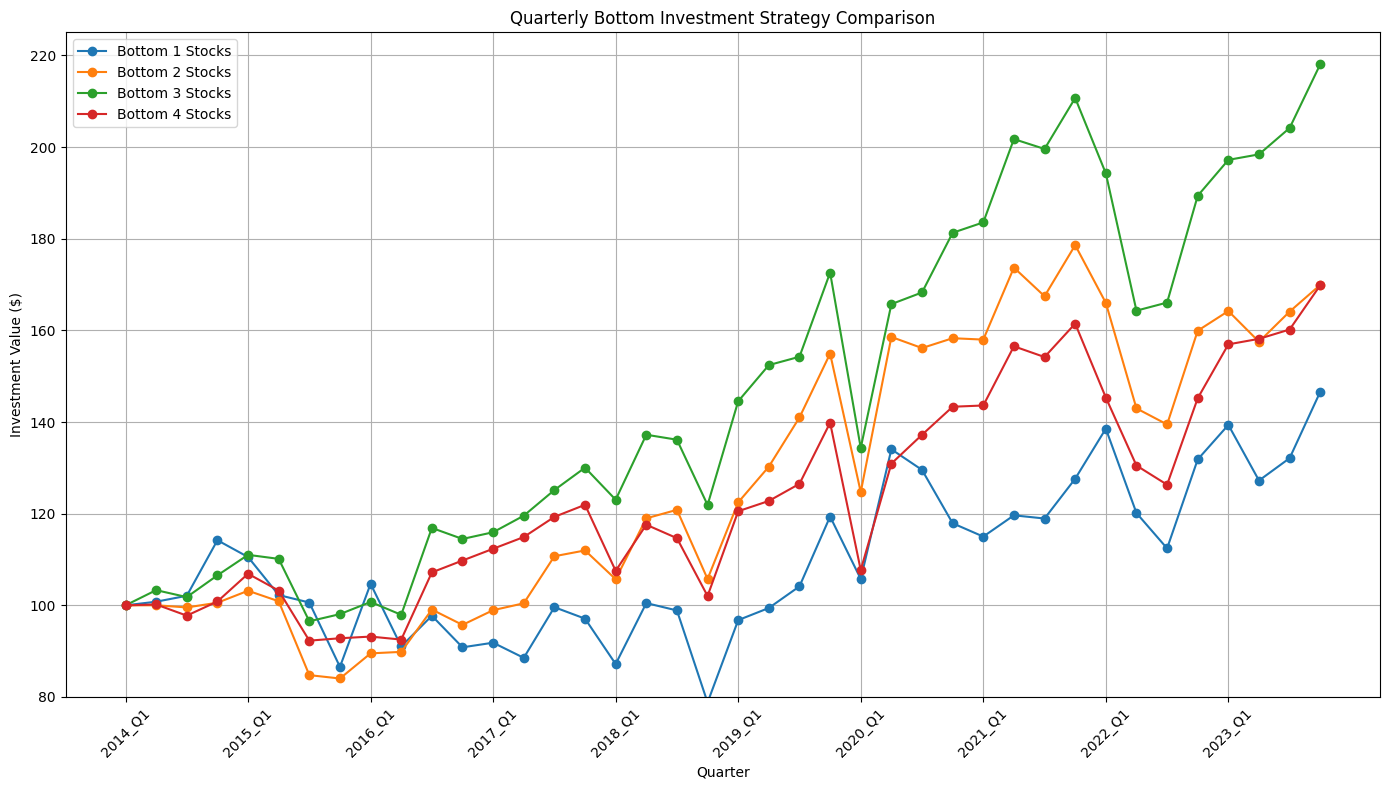

In [20]:


def load_all_csvs(files_path):
    dataframes = []
    stock_names = []  # Adding stock names for better tracking

    for filename in os.listdir(files_path):
        if filename.endswith(".csv"):
            file_path = os.path.join(files_path, filename)
            df = pd.read_csv(file_path)
            dataframes.append(df)
            stock_names.append(filename.replace('.csv', ''))

    return dataframes, stock_names

def calculate_quarterly_data(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df['Date'].dt.year
    df['Quarter'] = df['Date'].dt.quarter

    # Group by Year and Quarter and get the last closing price
    quarterly_data = df.groupby(['Year', 'Quarter']).agg(
        close_price=('Close', 'last')
    )

    return quarterly_data

def investment_simulation_bottom_n_quarterly(files_path, num_stocks, initial_investment=100):
    dataframes, stock_names = load_all_csvs(files_path)

    # Pre-calculate all quarterly returns
    all_returns = {}
    for df, name in zip(dataframes, stock_names):
        quarterly_data = calculate_quarterly_data(df)
        quarterly_data['return'] = quarterly_data['close_price'].pct_change()
        all_returns[name] = quarterly_data

    investment_per_quarter = {}
    selected_stocks = {}
    current_value = initial_investment

    # Initialize
    investment_per_quarter['2014_Q1'] = initial_investment

    for year in range(2014, 2024):
        for quarter in range(1, 5):
            period = f'{year}_Q{quarter}'

            # Skip initial period
            if year == 2013 and quarter == 1:
                continue

            # Determine prior quarter for selection
            if quarter == 1:
                prev_year, prev_quarter = year - 1, 4
            else:
                prev_year, prev_quarter = year, quarter - 1

            # Collect candidates with prior returns
            candidates = []
            for name in stock_names:
                if (prev_year, prev_quarter) in all_returns[name].index and (year, quarter) in all_returns[name].index:
                    prior_return = all_returns[name].loc[(prev_year, prev_quarter), 'return']
                    current_price = all_returns[name].loc[(year, quarter), 'close_price']
                    candidates.append((name, prior_return, current_price))

            if not candidates:
                investment_per_quarter[period] = current_value
                continue

            # Select based on PRIOR returns (worst performers first)
            bottom_n_stocks = sorted(candidates, key=lambda x: x[1])[:num_stocks]

            # Invest equally
            investment_per_stock = current_value / len(bottom_n_stocks)
            current_value = sum(
                investment_per_stock * (1 + (stock[2]/all_returns[stock[0]].loc[(prev_year, prev_quarter), 'close_price'] - 1))
                for stock in bottom_n_stocks
            )

            investment_per_quarter[period] = current_value
            selected_stocks[period] = [stock[0] for stock in bottom_n_stocks]

    return investment_per_quarter, selected_stocks

# Run simulations for bottom 1, 2, 3, and 4 stocks
quarterly_bottom_results = {}
quarterly_bottom_selected_stocks = {}

for n in range(1, 5):
    investment_result, stocks_selected = investment_simulation_bottom_n_quarterly('/content/content/sample_data/stocks', num_stocks=n, initial_investment=100)
    quarterly_bottom_results[f'bottom{n}'] = investment_result
    quarterly_bottom_selected_stocks[f'bottom{n}'] = stocks_selected

# Display results
for n in range(1, 5):
    print(f"\nBottom {n} stocks quarterly investment results:")
    final_period = max(quarterly_bottom_results[f'bottom{n}'].keys())
    final_value = quarterly_bottom_results[f'bottom{n}'][final_period]
    print(f"Final investment value: ${final_value:.2f}")
    print(f"Return multiplier: {final_value/100:.2f}x")

# Create a dataframe to compare all bottom quarterly strategies
quarterly_bottom_comparison_df = pd.DataFrame({
    f'Bottom {n} Stocks': pd.Series(quarterly_bottom_results[f'bottom{n}']) for n in range(1, 5)
})


# Create DataFrames for the selected stocks in each quarterly bottom strategy
quarterly_bottom_selected_stocks_df = {}

# For each bottom-N strategy, create a DataFrame of selected stocks
for n in range(1, 5):
    # Create column names based on the number of stocks
    columns = [f'Stock {i+1}' for i in range(n)]

    # Create a list of tuples for each period
    data = []
    for period in sorted(quarterly_bottom_selected_stocks[f'bottom{n}'].keys()):
        stocks = quarterly_bottom_selected_stocks[f'bottom{n}'][period]
        # Ensure we have exactly n stocks (pad with None if needed)
        while len(stocks) < n:
            stocks.append(None)
        data.append((period, *stocks[:n]))

    # Create DataFrame with period as index
    df = pd.DataFrame(data, columns=['Period'] + columns)
    df.set_index('Period', inplace=True)
    quarterly_bottom_selected_stocks_df[f'bottom{n}'] = df

    print(f"\nBottom {n} stocks selected for each quarter:")
    print(quarterly_bottom_selected_stocks_df[f'bottom{n}'])

# Create a visualization of quarterly bottom performance
plt.figure(figsize=(14, 8))
for n in range(1, 5):
    periods = list(quarterly_bottom_results[f'bottom{n}'].keys())
    values = list(quarterly_bottom_results[f'bottom{n}'].values())
    plt.plot(range(len(periods)), values, marker='o', label=f'Bottom {n} Stocks')

plt.xticks(range(0, len(periods), 4), [periods[i] for i in range(0, len(periods), 4)], rotation=45)
plt.xlabel('Quarter')
plt.ylabel('Investment Value ($)')
plt.title('Quarterly Bottom Investment Strategy Comparison')
plt.legend()
plt.grid(True)
plt.ylim(bottom=80)  # Set y-axis minimum to clearly show any drops below initial investment

plt.tight_layout()
plt.savefig('quarterly_bottom_investment_comparison.png')
# plt.show()  # Uncomment this line for interactive display

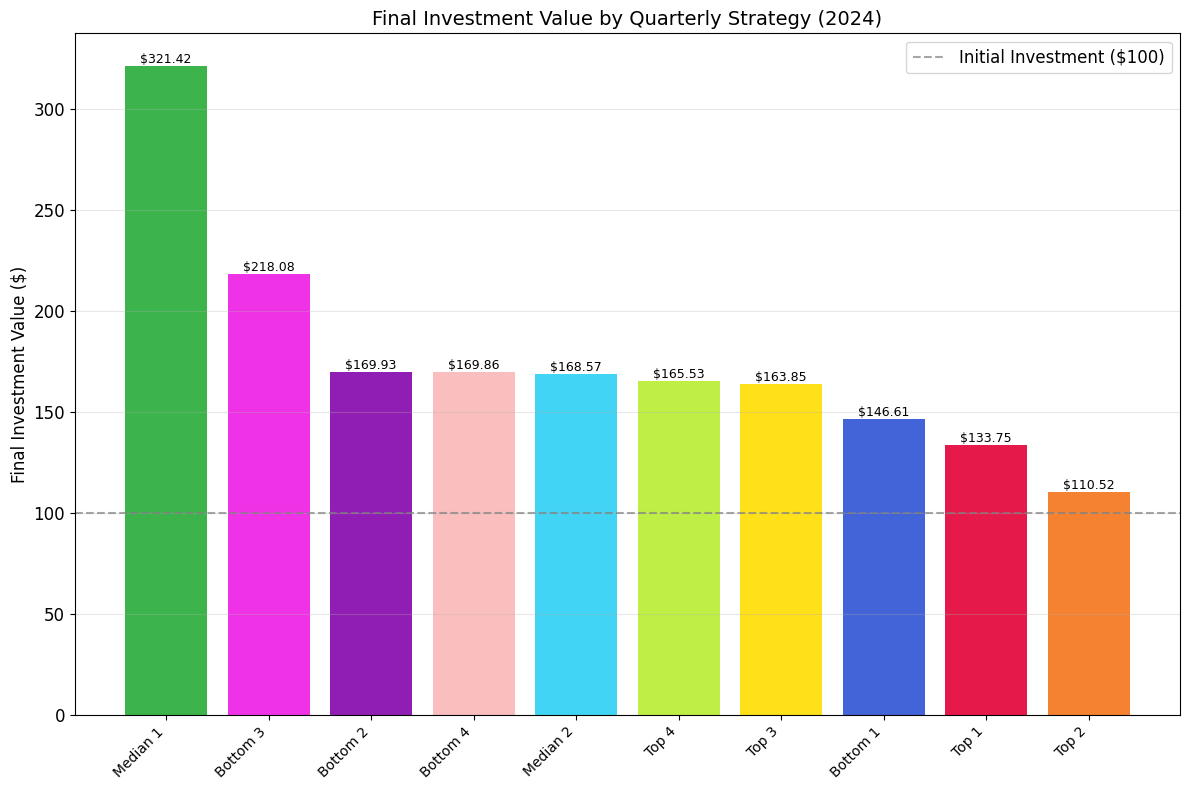

In [44]:
final_values = {
    'Top 1': 133.75, 'Top 2': 110.52, 'Top 3': 163.85, 'Top 4': 165.53,
    'Median 1': 321.42, 'Median 2': 168.57,
    'Bottom 1': 146.61, 'Bottom 2': 169.93, 'Bottom 3': 218.08, 'Bottom 4': 169.86
}

# Sort strategies by final value
sorted_strategies = sorted(final_values.items(), key=lambda x: x[1], reverse=True)
names = [name for name, _ in sorted_strategies]
values = [value for _, value in sorted_strategies]

# Color scheme
colors = {
    'Top': ['#e6194B', '#f58231', '#ffe119', '#bfef45'],  # Red to yellow
    'Median': ['#3cb44b', '#42d4f4'],                     # Green to cyan
    'Bottom': ['#4363d8', '#911eb4', '#f032e6', '#fabebe']  # Blue to pink
}

# Assign colors to bars
bar_colors = []
for name in names:
    if 'Top' in name:
        color_idx = int(name.split()[-1]) - 1
        bar_colors.append(colors['Top'][color_idx])
    elif 'Median' in name:
        color_idx = int(name.split()[-1]) - 1
        bar_colors.append(colors['Median'][color_idx])
    else:  # Bottom
        color_idx = int(name.split()[-1]) - 1
        bar_colors.append(colors['Bottom'][color_idx])

# Create the bar chart
plt.figure(figsize=(12, 8))
bars = plt.bar(names, values, color=bar_colors)

# Add reference line and labels
plt.axhline(y=100, color='gray', linestyle='--', alpha=0.7, label='Initial Investment ($100)')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.ylabel('Final Investment Value ($)', fontsize=12)
plt.title('Final Investment Value by Quarterly Strategy (2024)', fontsize=14)
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'${height:.2f}',
             ha='center', va='bottom', fontsize=9)

plt.legend()
plt.tight_layout()
plt.show()

# **Monthly**


Top 1 stocks monthly investment results:
Final investment value: $146.65
Return multiplier: 1.47x

Top 2 stocks monthly investment results:
Final investment value: $138.09
Return multiplier: 1.38x

Top 3 stocks monthly investment results:
Final investment value: $169.79
Return multiplier: 1.70x

Top 4 stocks monthly investment results:
Final investment value: $185.38
Return multiplier: 1.85x

Monthly investment values comparison:
         Top 1 Stocks  Top 2 Stocks  Top 3 Stocks  Top 4 Stocks
2014_01    100.000000    100.000000    100.000000    100.000000
2014_02    108.890576    107.628601    107.345754    107.167996
2014_03    106.958918    106.378134    104.599611    104.894164
2014_04    104.357206    101.024985    100.736745    102.305652
2014_05    101.706048     98.234388     99.636231    101.165236
...               ...           ...           ...           ...
2023_08    132.158676    129.560567    157.217891    171.762641
2023_09    132.231765    130.910072    160.475043    

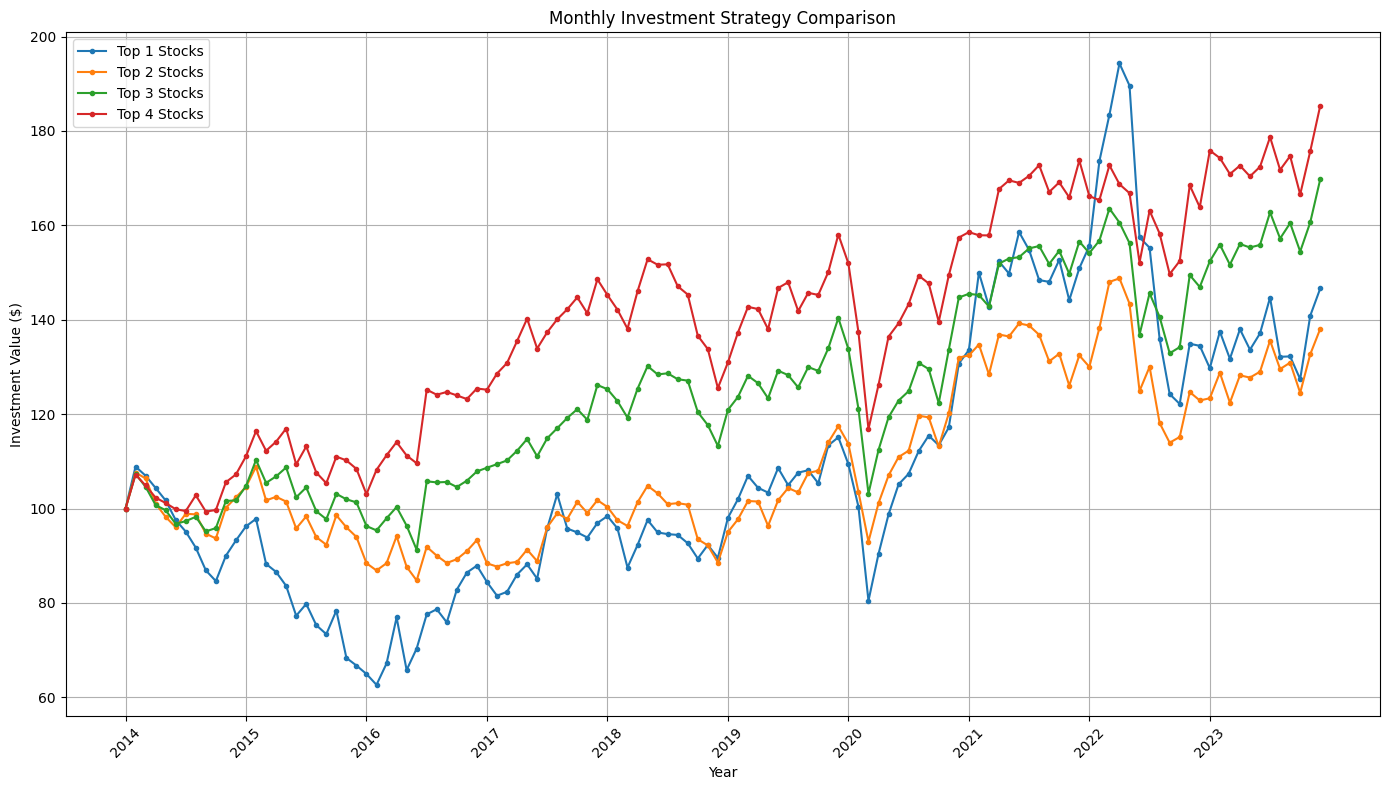

In [22]:
def load_all_csvs(files_path):
    dataframes = []
    stock_names = []  # Added to track stock names

    for file in os.listdir(files_path):
        if file.endswith('.csv'):
            df = pd.read_csv(os.path.join(files_path, file))
            stock_name = file.split('.')[0]
            df['Symbol'] = stock_name  # Store stock symbol for debugging
            dataframes.append(df)
            stock_names.append(stock_name)

    return dataframes, stock_names

def calculate_monthly_return(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    monthly_data = df.groupby(['Year', 'Month']).agg(
        open_price=('Open', 'first'),
        close_price=('Close', 'last')
    )
    return monthly_data

def investment_simulation_monthly_top_n(files_path, num_stocks, initial_investment=100):
    dataframes, stock_names = load_all_csvs(files_path)

    # Pre-calculate monthly returns for all stocks
    all_returns = {}
    for df, name in zip(dataframes, stock_names):
        monthly_data = calculate_monthly_return(df)
        monthly_data['return'] = monthly_data['close_price'].pct_change()
        all_returns[name] = monthly_data

    investment_per_month = {}
    selected_stocks = {}
    current_value = initial_investment

    # Initialize
    investment_per_month['2014_01'] = initial_investment

    for year in range(2014, 2024):
        for month in range(1, 13):
            period = f'{year}_{month:02d}'

            # Skip initial period
            if year == 2014 and month == 1:
                continue

            # Determine prior month for selection
            prev_month = month - 1 if month > 1 else 12
            prev_year = year if month > 1 else year - 1

            # Collect candidates with prior returns
            candidates = []
            for name in stock_names:
                if (prev_year, prev_month) in all_returns[name].index and (year, month) in all_returns[name].index:
                    prior_return = all_returns[name].loc[(prev_year, prev_month), 'return']
                    current_price = all_returns[name].loc[(year, month), 'close_price']
                    candidates.append((name, prior_return, current_price))

            if not candidates:
                investment_per_month[period] = current_value
                continue

            # Select based on PRIOR returns (top performers)
            top_n_stocks = sorted(candidates, key=lambda x: x[1], reverse=True)[:num_stocks]

            # Invest equally
            investment_per_stock = current_value / len(top_n_stocks)
            current_value = sum(
                investment_per_stock * (1 + (stock[2]/all_returns[stock[0]].loc[(prev_year, prev_month), 'close_price'] - 1))
                for stock in top_n_stocks
            )

            investment_per_month[period] = current_value
            selected_stocks[period] = [stock[0] for stock in top_n_stocks]

    return investment_per_month, selected_stocks
# Run simulations for top 1, 2, 3, and 4 stocks
monthly_results = {}
monthly_selected_stocks = {}

for n in range(1, 5):
    investment_result, stocks_selected = investment_simulation_monthly_top_n('/content/content/sample_data/stocks', num_stocks=n, initial_investment=100)
    monthly_results[f'top{n}'] = investment_result
    monthly_selected_stocks[f'top{n}'] = stocks_selected

# Display results
for n in range(1, 5):
    print(f"\nTop {n} stocks monthly investment results:")
    final_period = max(monthly_results[f'top{n}'].keys())
    final_value = monthly_results[f'top{n}'][final_period]
    print(f"Final investment value: ${final_value:.2f}")
    print(f"Return multiplier: {final_value/100:.2f}x")

# Create a comparison dataframe
monthly_comparison_df = pd.DataFrame({
    f'Top {n} Stocks': pd.Series(monthly_results[f'top{n}']) for n in range(1, 5)
})

# Display comparison
print("\nMonthly investment values comparison:")
print(monthly_comparison_df)

# Visualize the results
plt.figure(figsize=(14, 8))

for n in range(1, 5):
    periods = list(monthly_results[f'top{n}'].keys())
    values = list(monthly_results[f'top{n}'].values())
    plt.plot(range(len(periods)), values, marker='.', label=f'Top {n} Stocks')

# Only show January of each year on x-axis to avoid overcrowding
xtick_positions = [i for i, period in enumerate(periods) if period.endswith('_01')]
xtick_labels = [periods[i].split('_')[0] for i in xtick_positions]
plt.xticks(xtick_positions, xtick_labels, rotation=45)

plt.xlabel('Year')
plt.ylabel('Investment Value ($)')
plt.title('Monthly Investment Strategy Comparison')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('monthly_investment_comparison.png')
# plt.show()  # Uncomment this line for interactive display

# Calculate monthly performance metrics
# Create a monthly returns dataframe
monthly_returns_df = pd.DataFrame()

# Function to calculate monthly returns
def calculate_return_series(values):
    returns = []
    values_list = list(values)
    for i in range(1, len(values_list)):
        returns.append((values_list[i] / values_list[i-1]) - 1)
    return returns

# Calculate returns for each strategy
for n in range(1, 5):
    returns = calculate_return_series(monthly_results[f'top{n}'].values())
    monthly_returns_df[f'Top {n} Returns'] = returns

# Calculate annualized volatility (std dev * sqrt(12))
annualized_volatility = monthly_returns_df.std() * np.sqrt(12)

# Calculate annualized returns
years_elapsed = len(periods) / 12  # Number of years
annualized_returns = {}

for n in range(1, 5):
    first_value = list(monthly_results[f'top{n}'].values())[0]
    last_value = list(monthly_results[f'top{n}'].values())[-1]
    total_return = last_value / first_value - 1
    annualized_returns[f'Top {n}'] = (1 + total_return) ** (1 / years_elapsed) - 1

# Calculate Sharpe-like ratios
sharpe_ratios = {}
for n in range(1, 5):
    sharpe_ratios[f'Top {n}'] = annualized_returns[f'Top {n}'] / annualized_volatility[f'Top {n} Returns']

# Create performance summary
performance_df = pd.DataFrame({
    'Annualized Return': pd.Series(annualized_returns),
    'Annualized Volatility': annualized_volatility,
    'Sharpe Ratio': pd.Series(sharpe_ratios)
})

print("\nPerformance Summary:")
print(performance_df.sort_values('Sharpe Ratio', ascending=False))


Median 1 stocks monthly investment results:
Final investment value: $223.67
Return multiplier: 2.24x

Median 3 stocks monthly investment results:
Final investment value: $188.83
Return multiplier: 1.89x

Monthly median investment values comparison:
         Median 1 Stocks  Median 3 Stocks
2014_01       100.000000       100.000000
2014_02       106.780059       106.593803
2014_03       101.066262       104.208576
2014_04       100.040815       101.624722
2014_05       102.288905       100.974867
...                  ...              ...
2023_08       202.387597       176.698912
2023_09       210.750308       180.670295
2023_10       207.635248       171.666907
2023_11       205.316009       178.173908
2023_12       223.671390       188.833994

[120 rows x 2 columns]

Performance Summary:
                  Annualized Return  Annualized Volatility  Sharpe Ratio
Median 3                   0.065634                    NaN      0.410001
Median 1                   0.083830                   

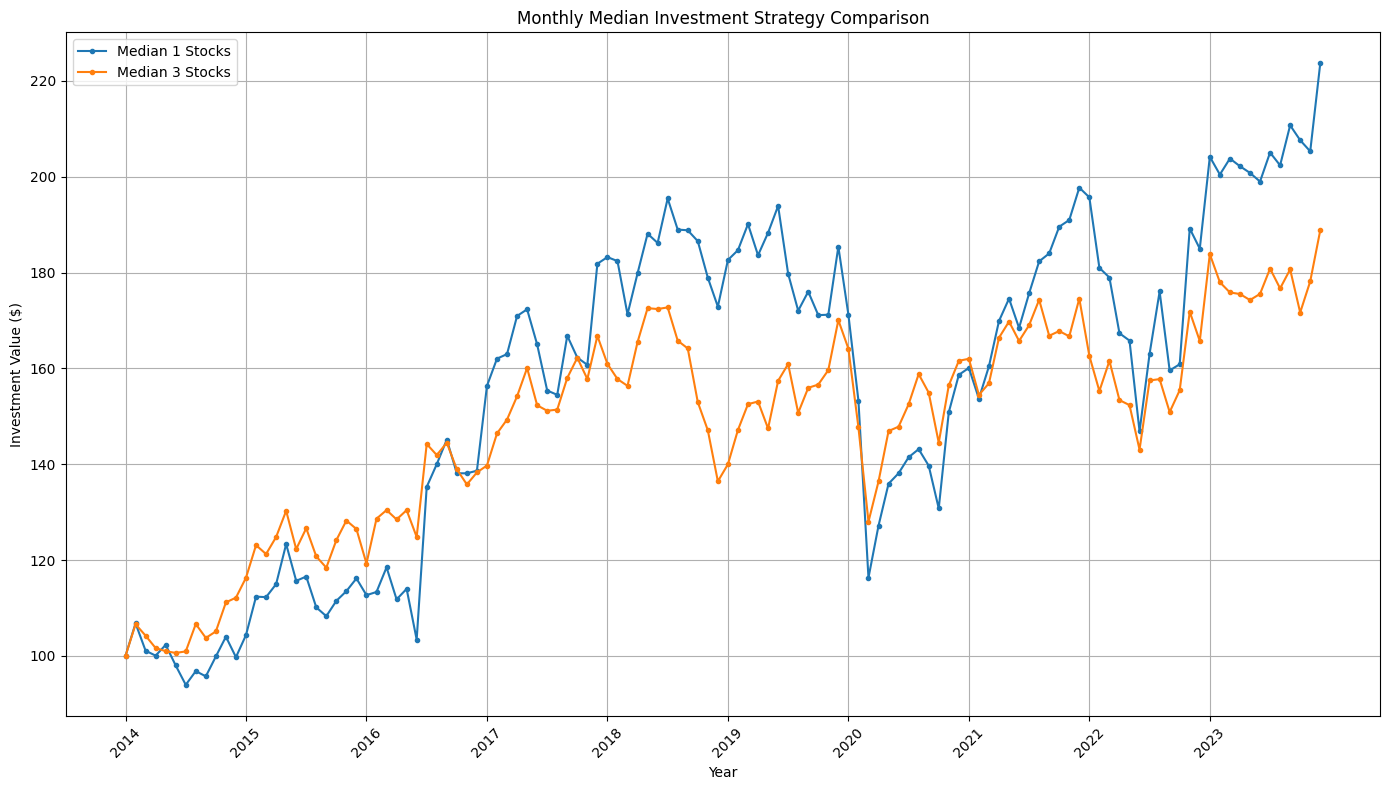

In [23]:
def load_all_csvs(files_path):
    dataframes = []
    stock_names = []  # Added to track stock names

    for file in os.listdir(files_path):
        if file.endswith('.csv'):
            df = pd.read_csv(os.path.join(files_path, file))
            stock_name = file.split('.')[0]
            df['Symbol'] = stock_name  # Store stock symbol for debugging
            dataframes.append(df)
            stock_names.append(stock_name)

    return dataframes, stock_names

def calculate_monthly_return(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    monthly_data = df.groupby(['Year', 'Month']).agg(
        open_price=('Open', 'first'),
        close_price=('Close', 'last')
    )
    return monthly_data

def investment_simulation_monthly_median_n(files_path, num_stocks, initial_investment=100):
    dataframes, stock_names = load_all_csvs(files_path)

    # Pre-calculate all monthly returns
    all_returns = {}
    for df, name in zip(dataframes, stock_names):
        monthly_data = calculate_monthly_return(df)
        monthly_data['return'] = monthly_data['close_price'].pct_change()
        all_returns[name] = monthly_data

    investment_per_month = {}
    selected_stocks = {}
    current_value = initial_investment

    # Initialize
    investment_per_month['2014_01'] = initial_investment

    for year in range(2014, 2024):
        for month in range(1, 13):
            period = f'{year}_{month:02d}'

            # Skip initial period
            if year == 2014 and month == 1:
                continue

            # Determine prior month for selection
            prev_month = month - 1 if month > 1 else 12
            prev_year = year if month > 1 else year - 1

            # Collect candidates with prior returns
            candidates = []
            for name in stock_names:
                if (prev_year, prev_month) in all_returns[name].index and (year, month) in all_returns[name].index:
                    prior_return = all_returns[name].loc[(prev_year, prev_month), 'return']
                    current_price = all_returns[name].loc[(year, month), 'close_price']
                    candidates.append((name, prior_return, current_price))

            if not candidates:
                investment_per_month[period] = current_value
                continue

            # Sort by PRIOR returns for median selection
            sorted_candidates = sorted(candidates, key=lambda x: x[1])

            # Select median stocks
            if num_stocks == 1:
                mid_index = len(sorted_candidates) // 2
                median_stocks = [sorted_candidates[mid_index]]
            else:  # num_stocks == 3
                mid_index = len(sorted_candidates) // 2
                median_stocks = sorted_candidates[max(0, mid_index-1):mid_index+2]

            # Invest equally
            investment_per_stock = current_value / len(median_stocks)
            current_value = sum(
                investment_per_stock * (1 + (stock[2]/all_returns[stock[0]].loc[(prev_year, prev_month), 'close_price'] - 1))
                for stock in median_stocks
            )

            investment_per_month[period] = current_value
            selected_stocks[period] = [stock[0] for stock in median_stocks]

    return investment_per_month, selected_stocks

# Run simulations for median 1 and median 3 stocks
monthly_median_results = {}
monthly_median_selected_stocks = {}

for n in [1, 3]:
    investment_result, stocks_selected = investment_simulation_monthly_median_n('/content/content/sample_data/stocks', num_stocks=n, initial_investment=100)
    monthly_median_results[f'median{n}'] = investment_result
    monthly_median_selected_stocks[f'median{n}'] = stocks_selected

# Display results
for n in [1, 3]:
    print(f"\nMedian {n} stocks monthly investment results:")
    final_period = max(monthly_median_results[f'median{n}'].keys())
    final_value = monthly_median_results[f'median{n}'][final_period]
    print(f"Final investment value: ${final_value:.2f}")
    print(f"Return multiplier: {final_value/100:.2f}x")

# Create a comparison dataframe
monthly_median_comparison_df = pd.DataFrame({
    f'Median {n} Stocks': pd.Series(monthly_median_results[f'median{n}']) for n in [1, 3]
})

# Display comparison
print("\nMonthly median investment values comparison:")
print(monthly_median_comparison_df)

# Visualize the results
plt.figure(figsize=(14, 8))

for n in [1, 3]:
    periods = list(monthly_median_results[f'median{n}'].keys())
    values = list(monthly_median_results[f'median{n}'].values())
    plt.plot(range(len(periods)), values, marker='.', label=f'Median {n} Stocks')

# Only show January of each year on x-axis to avoid overcrowding
xtick_positions = [i for i, period in enumerate(periods) if period.endswith('_01')]
xtick_labels = [periods[i].split('_')[0] for i in xtick_positions]
plt.xticks(xtick_positions, xtick_labels, rotation=45)

plt.xlabel('Year')
plt.ylabel('Investment Value ($)')
plt.title('Monthly Median Investment Strategy Comparison')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('monthly_median_investment_comparison.png')
# plt.show()  # Uncomment this line for interactive display

# Calculate monthly performance metrics
# Create a monthly returns dataframe
monthly_median_returns_df = pd.DataFrame()

# Function to calculate monthly returns
def calculate_return_series(values):
    returns = []
    values_list = list(values)
    for i in range(1, len(values_list)):
        returns.append((values_list[i] / values_list[i-1]) - 1)
    return returns

# Calculate returns for each strategy
for n in [1, 3]:
    returns = calculate_return_series(monthly_median_results[f'median{n}'].values())
    monthly_median_returns_df[f'Median {n} Returns'] = returns

# Calculate annualized volatility (std dev * sqrt(12))
annualized_volatility = monthly_median_returns_df.std() * np.sqrt(12)

# Calculate annualized returns
years_elapsed = len(periods) / 12  # Number of years
annualized_returns = {}

for n in [1, 3]:
    first_value = list(monthly_median_results[f'median{n}'].values())[0]
    last_value = list(monthly_median_results[f'median{n}'].values())[-1]
    total_return = last_value / first_value - 1
    annualized_returns[f'Median {n}'] = (1 + total_return) ** (1 / years_elapsed) - 1

# Calculate Sharpe-like ratios
sharpe_ratios = {}
for n in [1, 3]:
    sharpe_ratios[f'Median {n}'] = annualized_returns[f'Median {n}'] / annualized_volatility[f'Median {n} Returns']

# Create performance summary
performance_df = pd.DataFrame({
    'Annualized Return': pd.Series(annualized_returns),
    'Annualized Volatility': annualized_volatility,
    'Sharpe Ratio': pd.Series(sharpe_ratios)
})

print("\nPerformance Summary:")
print(performance_df.sort_values('Sharpe Ratio', ascending=False))


Bottom 1 stocks monthly investment results:
Final investment value: $105.27
Return multiplier: 1.05x

Bottom 2 stocks monthly investment results:
Final investment value: $160.33
Return multiplier: 1.60x

Bottom 3 stocks monthly investment results:
Final investment value: $187.17
Return multiplier: 1.87x

Bottom 4 stocks monthly investment results:
Final investment value: $170.32
Return multiplier: 1.70x

Monthly bottom investment values comparison:
         Bottom 1 Stocks  Bottom 2 Stocks  Bottom 3 Stocks  Bottom 4 Stocks
2014_01       100.000000       100.000000       100.000000       100.000000
2014_02       108.890576       107.628601       107.345754       107.167996
2014_03       104.658626       105.100008       103.749766       104.328188
2014_04       114.014131       110.432324       106.908082       104.719565
2014_05       116.837273       111.147190       108.170253       104.865581
...                  ...              ...              ...              ...
2023_08       

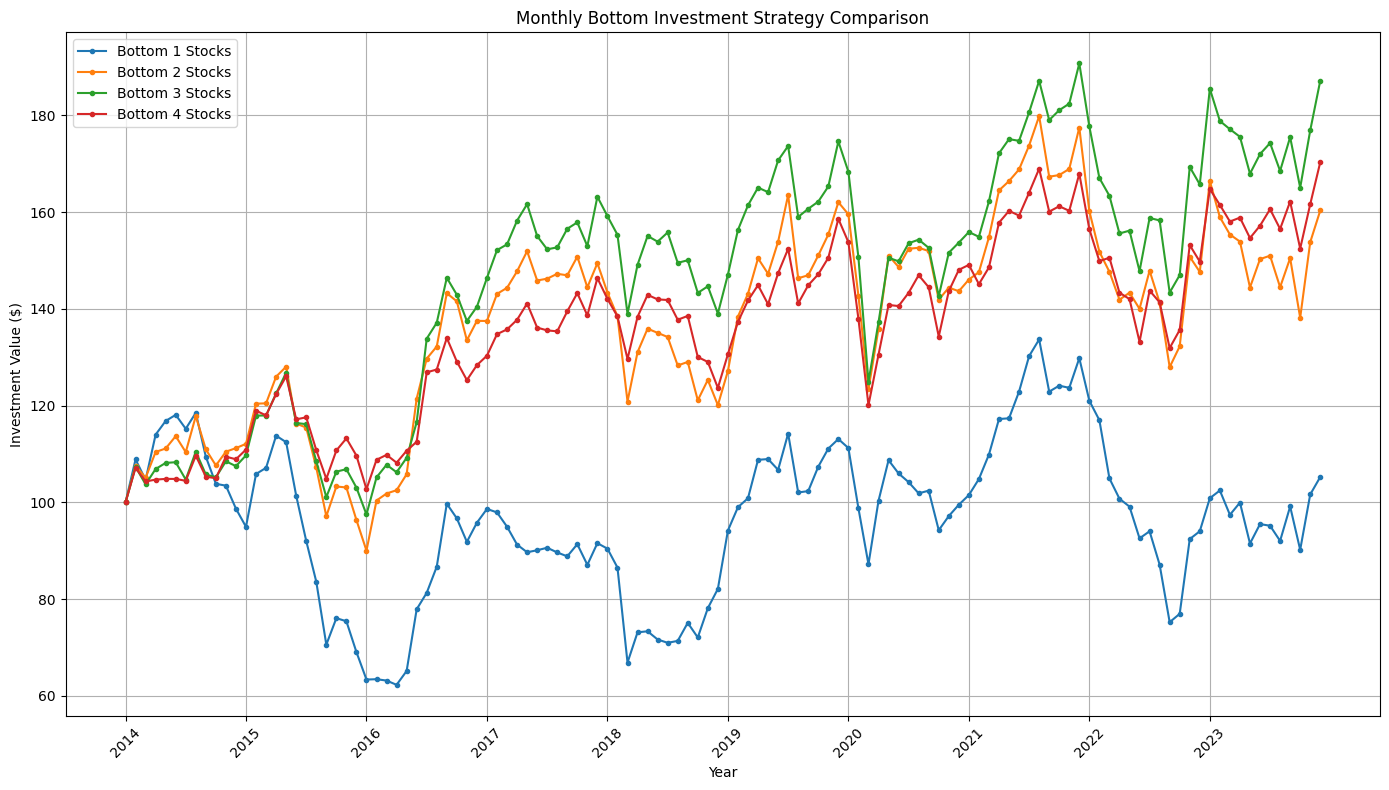

In [24]:
def load_all_csvs(files_path):
    dataframes = []
    stock_names = []  # Added to track stock names

    for file in os.listdir(files_path):
        if file.endswith('.csv'):
            df = pd.read_csv(os.path.join(files_path, file))
            stock_name = file.split('.')[0]
            df['Symbol'] = stock_name  # Store stock symbol for debugging
            dataframes.append(df)
            stock_names.append(stock_name)

    return dataframes, stock_names

def calculate_monthly_return(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    monthly_data = df.groupby(['Year', 'Month']).agg(
        open_price=('Open', 'first'),
        close_price=('Close', 'last')
    )
    return monthly_data

def investment_simulation_monthly_bottom_n(files_path, num_stocks, initial_investment=100):
    dataframes, stock_names = load_all_csvs(files_path)

    # Pre-calculate all monthly returns
    all_returns = {}
    for df, name in zip(dataframes, stock_names):
        monthly_data = calculate_monthly_return(df)
        monthly_data['return'] = monthly_data['close_price'].pct_change()
        all_returns[name] = monthly_data

    investment_per_month = {}
    selected_stocks = {}
    current_value = initial_investment

    # Initialize
    investment_per_month['2014_01'] = initial_investment

    for year in range(2014, 2024):
        for month in range(1, 13):
            period = f'{year}_{month:02d}'

            # Skip initial period
            if year == 2014 and month == 1:
                continue

            # Determine prior month for selection
            prev_month = month - 1 if month > 1 else 12
            prev_year = year if month > 1 else year - 1

            # Collect candidates with prior returns
            candidates = []
            for name in stock_names:
                if (prev_year, prev_month) in all_returns[name].index and (year, month) in all_returns[name].index:
                    prior_return = all_returns[name].loc[(prev_year, prev_month), 'return']
                    current_price = all_returns[name].loc[(year, month), 'close_price']
                    candidates.append((name, prior_return, current_price))

            if not candidates:
                investment_per_month[period] = current_value
                continue

            # Select based on PRIOR returns (worst performers first)
            bottom_n_stocks = sorted(candidates, key=lambda x: x[1])[:num_stocks]

            # Invest equally
            investment_per_stock = current_value / len(bottom_n_stocks)
            current_value = sum(
                investment_per_stock * (1 + (stock[2]/all_returns[stock[0]].loc[(prev_year, prev_month), 'close_price'] - 1))
                for stock in bottom_n_stocks
            )

            investment_per_month[period] = current_value
            selected_stocks[period] = [stock[0] for stock in bottom_n_stocks]

    return investment_per_month, selected_stocks

# Run simulations for bottom 1, 2, 3, and 4 stocks
monthly_bottom_results = {}
monthly_bottom_selected_stocks = {}

for n in range(1, 5):
    investment_result, stocks_selected = investment_simulation_monthly_bottom_n('/content/content/sample_data/stocks', num_stocks=n, initial_investment=100)
    monthly_bottom_results[f'bottom{n}'] = investment_result
    monthly_bottom_selected_stocks[f'bottom{n}'] = stocks_selected

# Display results
for n in range(1, 5):
    print(f"\nBottom {n} stocks monthly investment results:")
    final_period = max(monthly_bottom_results[f'bottom{n}'].keys())
    final_value = monthly_bottom_results[f'bottom{n}'][final_period]
    print(f"Final investment value: ${final_value:.2f}")
    print(f"Return multiplier: {final_value/100:.2f}x")

# Create a comparison dataframe
monthly_bottom_comparison_df = pd.DataFrame({
    f'Bottom {n} Stocks': pd.Series(monthly_bottom_results[f'bottom{n}']) for n in range(1, 5)
})

# Display comparison
print("\nMonthly bottom investment values comparison:")
print(monthly_bottom_comparison_df)

# Visualize the results
plt.figure(figsize=(14, 8))

for n in range(1, 5):
    periods = list(monthly_bottom_results[f'bottom{n}'].keys())
    values = list(monthly_bottom_results[f'bottom{n}'].values())
    plt.plot(range(len(periods)), values, marker='.', label=f'Bottom {n} Stocks')

# Only show January of each year on x-axis to avoid overcrowding
xtick_positions = [i for i, period in enumerate(periods) if period.endswith('_01')]
xtick_labels = [periods[i].split('_')[0] for i in xtick_positions]
plt.xticks(xtick_positions, xtick_labels, rotation=45)

plt.xlabel('Year')
plt.ylabel('Investment Value ($)')
plt.title('Monthly Bottom Investment Strategy Comparison')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('monthly_bottom_investment_comparison.png')
# plt.show()  # Uncomment this line for interactive display

# Calculate monthly performance metrics
# Create a monthly returns dataframe
monthly_bottom_returns_df = pd.DataFrame()

# Function to calculate monthly returns
def calculate_return_series(values):
    returns = []
    values_list = list(values)
    for i in range(1, len(values_list)):
        returns.append((values_list[i] / values_list[i-1]) - 1)
    return returns

# Calculate returns for each strategy
for n in range(1, 5):
    returns = calculate_return_series(monthly_bottom_results[f'bottom{n}'].values())
    monthly_bottom_returns_df[f'Bottom {n} Returns'] = returns

# Calculate annualized volatility (std dev * sqrt(12))
annualized_volatility = monthly_bottom_returns_df.std() * np.sqrt(12)

# Calculate annualized returns
years_elapsed = len(periods) / 12  # Number of years
annualized_returns = {}

for n in range(1, 5):
    first_value = list(monthly_bottom_results[f'bottom{n}'].values())[0]
    last_value = list(monthly_bottom_results[f'bottom{n}'].values())[-1]
    total_return = last_value / first_value - 1
    annualized_returns[f'Bottom {n}'] = (1 + total_return) ** (1 / years_elapsed) - 1

# Calculate Sharpe-like ratios
sharpe_ratios = {}
for n in range(1, 5):
    sharpe_ratios[f'Bottom {n}'] = annualized_returns[f'Bottom {n}'] / annualized_volatility[f'Bottom {n} Returns']

# Create performance summary
performance_df = pd.DataFrame({
    'Annualized Return': pd.Series(annualized_returns),
    'Annualized Volatility': annualized_volatility,
    'Sharpe Ratio': pd.Series(sharpe_ratios)
})

print("\nPerformance Summary:")
print(performance_df.sort_values('Sharpe Ratio', ascending=False))


Comparison of Monthly Investment Strategies:
     Top 3 Monthly  Median 3 Monthly  Bottom 3 Monthly
0       100.000000        100.000000        100.000000
1        98.954672         98.250511         96.650088
2        95.300273         95.350052         97.460399
3        96.425401         94.813093         96.470061
4        93.632711         92.539905         96.641388
..             ...               ...               ...
127     144.051339        150.707531        196.500323
128     137.405462        143.504113        187.233307
129     145.672886        146.838085        192.625994
130     141.786895        140.986988        186.496924
131     141.786895        140.986988        186.496924

[132 rows x 3 columns]

Final Investment Values and Return Multipliers:
Top 3 Monthly: $141.79 (Return: 1.42x)
Median 3 Monthly: $140.99 (Return: 1.41x)
Bottom 3 Monthly: $186.50 (Return: 1.86x)

Performance Summary:
                  Average Monthly Return  Annualized Return  \
Bottom 3 Retu

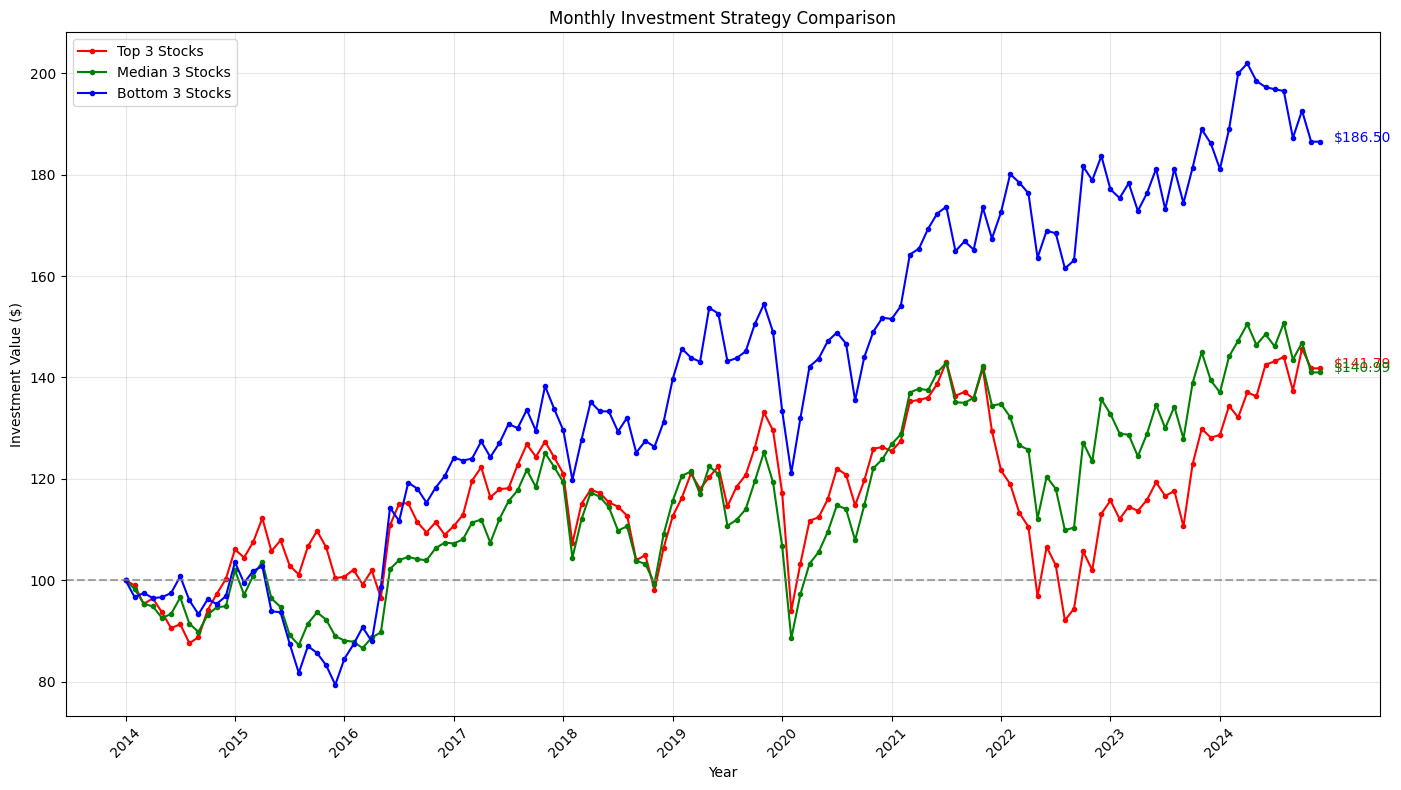

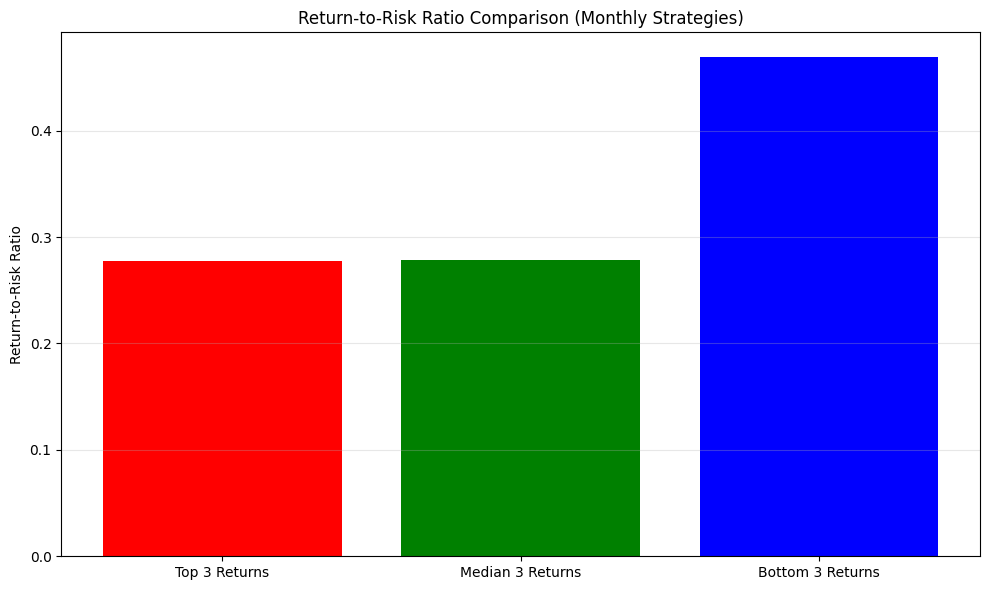

<Figure size 1200x600 with 0 Axes>

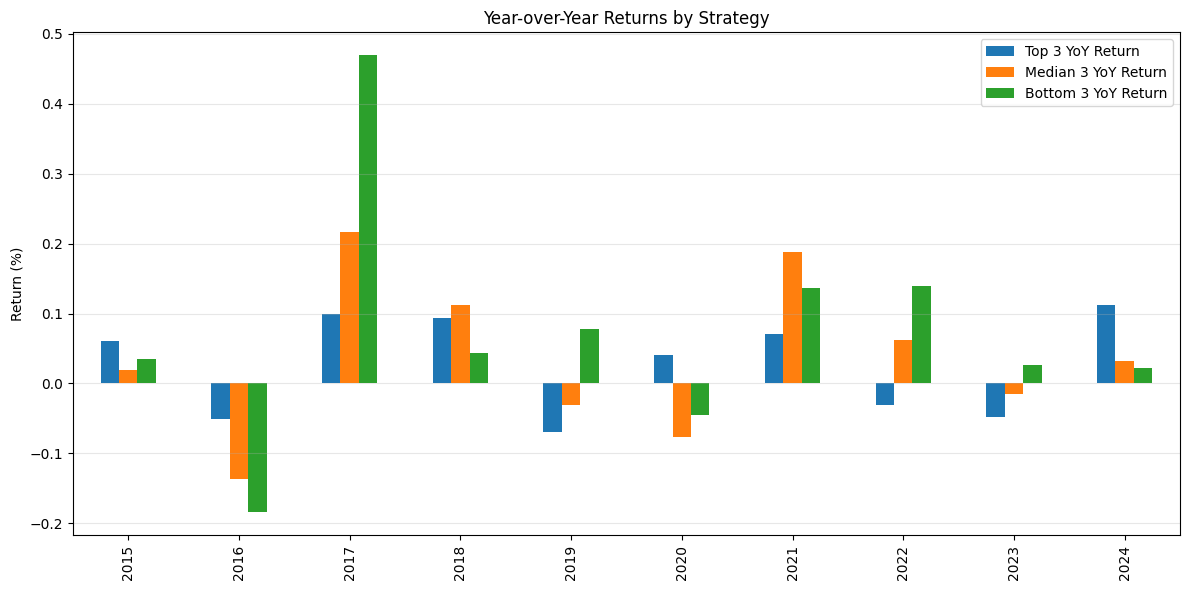

In [25]:
def load_all_csvs(files_path):
    dataframes = []
    stock_names = []

    for file in os.listdir(files_path):
        if file.endswith('.csv'):
            df = pd.read_csv(os.path.join(files_path, file))
            stock_name = file.split('.')[0]
            df['Symbol'] = stock_name  # Store stock symbol for debugging
            dataframes.append(df)
            stock_names.append(stock_name)

    return dataframes, stock_names

def calculate_monthly_return(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    monthly_data = df.groupby(['Year', 'Month']).agg(
        open_price=('Open', 'first'),
        close_price=('Close', 'last')
    )
    return monthly_data

# Generic monthly investment simulation function for different strategies
def investment_simulation_monthly(files_path, strategy='top', num_stocks=3, initial_investment=100):
    """
    Simulate monthly investment for different strategies.

    Parameters:
    - files_path: Path to directory containing CSV files
    - strategy: 'top', 'median', or 'bottom'
    - num_stocks: Number of stocks to select each month
    - initial_investment: Initial investment amount (default: 100)

    Returns:
    - Dictionary of investment value per month
    """
    dataframes, stock_names = load_all_csvs(files_path)

    investment_per_month = {}
    total_investment = initial_investment

    # Set the initial value
    start_year, start_month = 2014, 1
    investment_per_month[f'{start_year}_{start_month:02d}'] = initial_investment

    # Find the last available month in the data
    last_months = []
    for df in dataframes:
        df['Date'] = pd.to_datetime(df['Date'])
        if not df.empty:
            last_date = df['Date'].max()
            last_months.append((last_date.year, last_date.month))

    max_year, max_month = max(last_months) if last_months else (2023, 12)

    for year in range(2014, max_year + 1):
        for month in range(1, 13):
            # Skip the very first month (already set to 100)
            if year == start_year and month == start_month:
                continue

            # Skip months beyond the maximum available month
            if (year > max_year) or (year == max_year and month > max_month):
                continue

            monthly_returns = []

            # Calculate the previous month
            prev_month = month - 1 if month > 1 else 12
            prev_year = year if month > 1 else year - 1
            prev_period = f'{prev_year}_{prev_month:02d}'

            # If no previous month value, skip (unlikely but safe)
            if prev_period not in investment_per_month:
                continue

            # Get the investment value from the previous month
            total_investment = investment_per_month[prev_period]

            # Collect the monthly close prices for each stock
            for df, stock_name in zip(dataframes, stock_names):
                monthly_data = calculate_monthly_return(df)
                if (year, month) in monthly_data.index:
                    monthly_returns.append((df, stock_name, monthly_data.loc[(year, month), 'close_price']))

            # Skip if no data available for this month
            if not monthly_returns:
                investment_per_month[f'{year}_{month:02d}'] = total_investment  # Maintain previous value
                continue

            # Sort stocks based on strategy
            if strategy == 'top':
                # Sort descending for top performers
                selected_stocks = sorted(monthly_returns, key=lambda x: x[2], reverse=True)[:num_stocks]
            elif strategy == 'median':
                # Sort and pick middle stocks
                sorted_stocks = sorted(monthly_returns, key=lambda x: x[2])
                if num_stocks == 1:
                    # For median 1, select the exact middle stock
                    mid_index = len(sorted_stocks) // 2
                    selected_stocks = [sorted_stocks[mid_index]]
                else:  # For median 3
                    # For median 3, select the middle 3 stocks
                    if len(sorted_stocks) >= 3:
                        mid_index = len(sorted_stocks) // 2 - 1
                        selected_stocks = sorted_stocks[mid_index:mid_index + 3]
                    else:
                        selected_stocks = sorted_stocks  # If less than 3 stocks, use all
            else:  # 'bottom'
                # Sort ascending for bottom performers
                selected_stocks = sorted(monthly_returns, key=lambda x: x[2])[:num_stocks]

            if selected_stocks:
                investment_per_stock = total_investment / len(selected_stocks)
                new_total_investment = 0

                # Invest in the selected stocks
                for stock_data in selected_stocks:
                    stock_df, stock_name, close_price = stock_data

                    # Calculate number of shares bought
                    shares_bought = investment_per_stock / close_price

                    # Get the next month details
                    next_month = month + 1 if month < 12 else 1
                    next_year = year if month < 12 else year + 1

                    # Check if there's data for the next month
                    monthly_data = calculate_monthly_return(stock_df)

                    # If we're at the last available month, use the current month's price
                    # This prevents the drop to zero at the end
                    if (year == max_year and month == max_month) or (next_year, next_month) not in monthly_data.index:
                        new_total_investment += shares_bought * close_price
                    else:
                        next_month_close_price = monthly_data.loc[(next_year, next_month), 'close_price']
                        new_total_investment += shares_bought * next_month_close_price

                total_investment = new_total_investment

            investment_per_month[f'{year}_{month:02d}'] = total_investment

    return investment_per_month

# Run the simulations with the specified path to your stock data files
stock_path = '/content/content/sample_data/stocks'  # Update this to your actual path

# Run the three strategies with 3 stocks each
investment_result_monthly_top = investment_simulation_monthly(stock_path, strategy='top', num_stocks=3)
investment_result_monthly_mid = investment_simulation_monthly(stock_path, strategy='median', num_stocks=3)
investment_result_monthly_bottom = investment_simulation_monthly(stock_path, strategy='bottom', num_stocks=3)

# Convert value dictionaries to lists
top_monthly = list(investment_result_monthly_top.values())
mid_monthly = list(investment_result_monthly_mid.values())
bottom_monthly = list(investment_result_monthly_bottom.values())

# Create a DataFrame with all three monthly strategies
monthly_comparison_df = pd.DataFrame({
    'Top 3 Monthly': top_monthly,
    'Median 3 Monthly': mid_monthly,
    'Bottom 3 Monthly': bottom_monthly
})

# Display the comparison DataFrame
print("\nComparison of Monthly Investment Strategies:")
print(monthly_comparison_df)

# Calculate final values and returns
final_values = {
    'Top 3 Monthly': top_monthly[-1],
    'Median 3 Monthly': mid_monthly[-1],
    'Bottom 3 Monthly': bottom_monthly[-1]
}

# Calculate return multipliers
return_multipliers = {strategy: value/100 for strategy, value in final_values.items()}

# Display final values and return multipliers
print("\nFinal Investment Values and Return Multipliers:")
for strategy in final_values:
    print(f"{strategy}: ${final_values[strategy]:.2f} (Return: {return_multipliers[strategy]:.2f}x)")

# Create a visualization comparing all three monthly strategies
plt.figure(figsize=(14, 8))

# Get periods for x-axis labels
periods = list(investment_result_monthly_top.keys())

# Plot each strategy
plt.plot(range(len(top_monthly)), top_monthly, marker='.', linewidth=1.5, color='red', label='Top 3 Stocks')
plt.plot(range(len(mid_monthly)), mid_monthly, marker='.', linewidth=1.5, color='green', label='Median 3 Stocks')
plt.plot(range(len(bottom_monthly)), bottom_monthly, marker='.', linewidth=1.5, color='blue', label='Bottom 3 Stocks')

# Set x-axis labels showing every 12th month (January of each year)
xtick_positions = range(0, len(periods), 12)
xtick_labels = [periods[i].split('_')[0] for i in xtick_positions if i < len(periods)]
plt.xticks(xtick_positions, xtick_labels, rotation=45)

plt.xlabel('Year')
plt.ylabel('Investment Value ($)')
plt.title('Monthly Investment Strategy Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Add value annotations at end
for data, label, color in [(top_monthly, 'Top 3', 'red'),
                          (mid_monthly, 'Median 3', 'green'),
                          (bottom_monthly, 'Bottom 3', 'blue')]:
    plt.annotate(f'${data[-1]:.2f}',
                xy=(len(periods)-1, data[-1]),
                xytext=(10, 0),
                textcoords='offset points',
                fontsize=10,
                color=color)

# Add a horizontal line at $100 (initial investment)
plt.axhline(y=100, color='gray', linestyle='--', alpha=0.7, label='Initial Investment ($100)')

plt.savefig('monthly_strategies_comparison.png', dpi=300, bbox_inches='tight')
# plt.show()  # Uncomment this line for interactive display

# Calculate monthly returns for volatility analysis
monthly_returns = pd.DataFrame()

# Function to calculate monthly returns from a list of investment values
def calculate_monthly_returns(values):
    returns = []
    for i in range(1, len(values)):
        returns.append((values[i] / values[i-1]) - 1)
    return returns

# Calculate returns for each strategy
monthly_returns['Top 3 Returns'] = calculate_monthly_returns(top_monthly)
monthly_returns['Median 3 Returns'] = calculate_monthly_returns(mid_monthly)
monthly_returns['Bottom 3 Returns'] = calculate_monthly_returns(bottom_monthly)

# Calculate volatility (standard deviation of returns)
volatility = monthly_returns.std()

# Annualize volatility (multiply by sqrt(12))
annualized_volatility = volatility * np.sqrt(12)

# Calculate average monthly return
avg_monthly_return = monthly_returns.mean()

# Annualize returns ((1 + avg_monthly_return)^12 - 1)
annualized_return = (1 + avg_monthly_return) ** 12 - 1

# Calculate return-to-risk ratio (similar to Sharpe ratio)
return_to_risk = annualized_return / annualized_volatility

# Create a summary DataFrame
performance_summary = pd.DataFrame({
    'Average Monthly Return': avg_monthly_return,
    'Annualized Return': annualized_return,
    'Monthly Volatility': volatility,
    'Annualized Volatility': annualized_volatility,
    'Return-to-Risk Ratio': return_to_risk
})

print("\nPerformance Summary:")
print(performance_summary.sort_values('Return-to-Risk Ratio', ascending=False))

# Create a bar chart of return-to-risk ratios
plt.figure(figsize=(10, 6))
plt.bar(return_to_risk.index, return_to_risk.values, color=['red', 'green', 'blue'])
plt.title('Return-to-Risk Ratio Comparison (Monthly Strategies)')
plt.ylabel('Return-to-Risk Ratio')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('monthly_return_to_risk_comparison.png', dpi=300, bbox_inches='tight')
# plt.show()  # Uncomment this line for interactive display

# Create a year-by-year performance comparison
# Create year column for analysis
year_data = pd.DataFrame()
year_data['Value'] = top_monthly + mid_monthly + bottom_monthly
year_data['Strategy'] = (['Top 3'] * len(top_monthly) +
                         ['Median 3'] * len(mid_monthly) +
                         ['Bottom 3'] * len(bottom_monthly))
year_data['Period'] = periods * 3  # Repeat periods for each strategy
year_data['Year'] = [p.split('_')[0] for p in year_data['Period']]
year_data['Month'] = [p.split('_')[1] for p in year_data['Period']]

# Calculate year-over-year returns
yearly_returns = pd.DataFrame()
for strategy in ['Top 3', 'Median 3', 'Bottom 3']:
    strategy_data = year_data[year_data['Strategy'] == strategy].copy()
    # Get January values for each year
    january_values = strategy_data[strategy_data['Month'] == '01'].copy()
    january_values = january_values.sort_values('Year')

    # Calculate yearly returns
    yearly_ret = []
    years = []
    for i in range(1, len(january_values)):
        current_year = january_values.iloc[i]['Year']
        prev_value = january_values.iloc[i-1]['Value']
        current_value = january_values.iloc[i]['Value']
        yearly_ret.append(current_value / prev_value - 1)
        years.append(current_year)

    if years:  # Only if we have data
        yearly_returns[f'{strategy} YoY Return'] = pd.Series(yearly_ret, index=years)

# Display yearly returns
print("\nYearly Returns (January to January):")
print(yearly_returns)

# Plot yearly returns
plt.figure(figsize=(12, 6))
yearly_returns.plot(kind='bar', figsize=(12, 6))
plt.title('Year-over-Year Returns by Strategy')
plt.ylabel('Return (%)')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('yearly_returns_comparison.png', dpi=300, bbox_inches='tight')

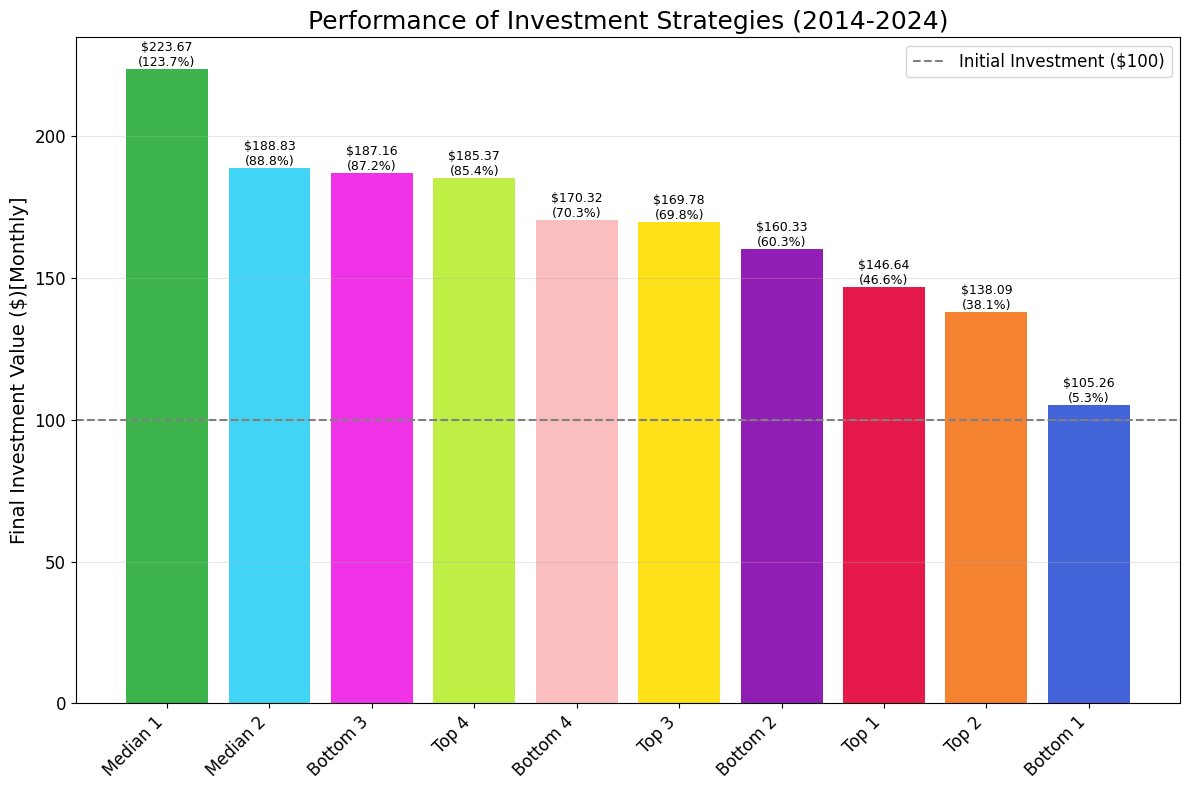

In [46]:
final_values = {
    'Top 1': 146.64,
    'Top 2': 138.09,
    'Top 3': 169.78,
    'Top 4':  185.37,
    'Median 1': 223.67,
    'Median 2': 188.83,
    'Bottom 1': 105.26,
    'Bottom 2':  160.33,
    'Bottom 3': 187.16,
    'Bottom 4': 170.32
}

# Sort strategies by performance
sorted_strategies = sorted(final_values.items(), key=lambda x: x[1], reverse=True)
strategies = [name for name, _ in sorted_strategies]
values = [value for _, value in sorted_strategies]

# Set up color scheme
colors = {
    'Top': ['#e6194B', '#f58231', '#ffe119', '#bfef45'],  # Red to yellow
    'Median': ['#3cb44b', '#42d4f4'],                     # Green to cyan
    'Bottom': ['#4363d8', '#911eb4', '#f032e6', '#fabebe']  # Blue to pink
}

# Assign colors to each bar
bar_colors = []
for strategy in strategies:
    if 'Top' in strategy:
        n = int(strategy.split()[-1]) - 1
        bar_colors.append(colors['Top'][n])
    elif 'Median' in strategy:
        n = int(strategy.split()[-1]) - 1
        bar_colors.append(colors['Median'][n])
    else:
        n = int(strategy.split()[-1]) - 1
        bar_colors.append(colors['Bottom'][n])

# Create the figure
plt.figure(figsize=(12, 8))

# Plot the bars
bars = plt.bar(strategies, values, color=bar_colors)

# Add reference line and labels
plt.axhline(y=100, color='gray', linestyle='--', label='Initial Investment ($100)')
plt.ylabel('Final Investment Value ($)[Monthly]')
plt.title('Performance of Investment Strategies (2014-2024)')
plt.xticks(rotation=45, ha='right')

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'${height:.2f}\n({height/100-1:.1%})',
             ha='center', va='bottom', fontsize=9)

plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('investment_strategies_comparison_monthly.png', dpi=300, bbox_inches='tight')
plt.show()

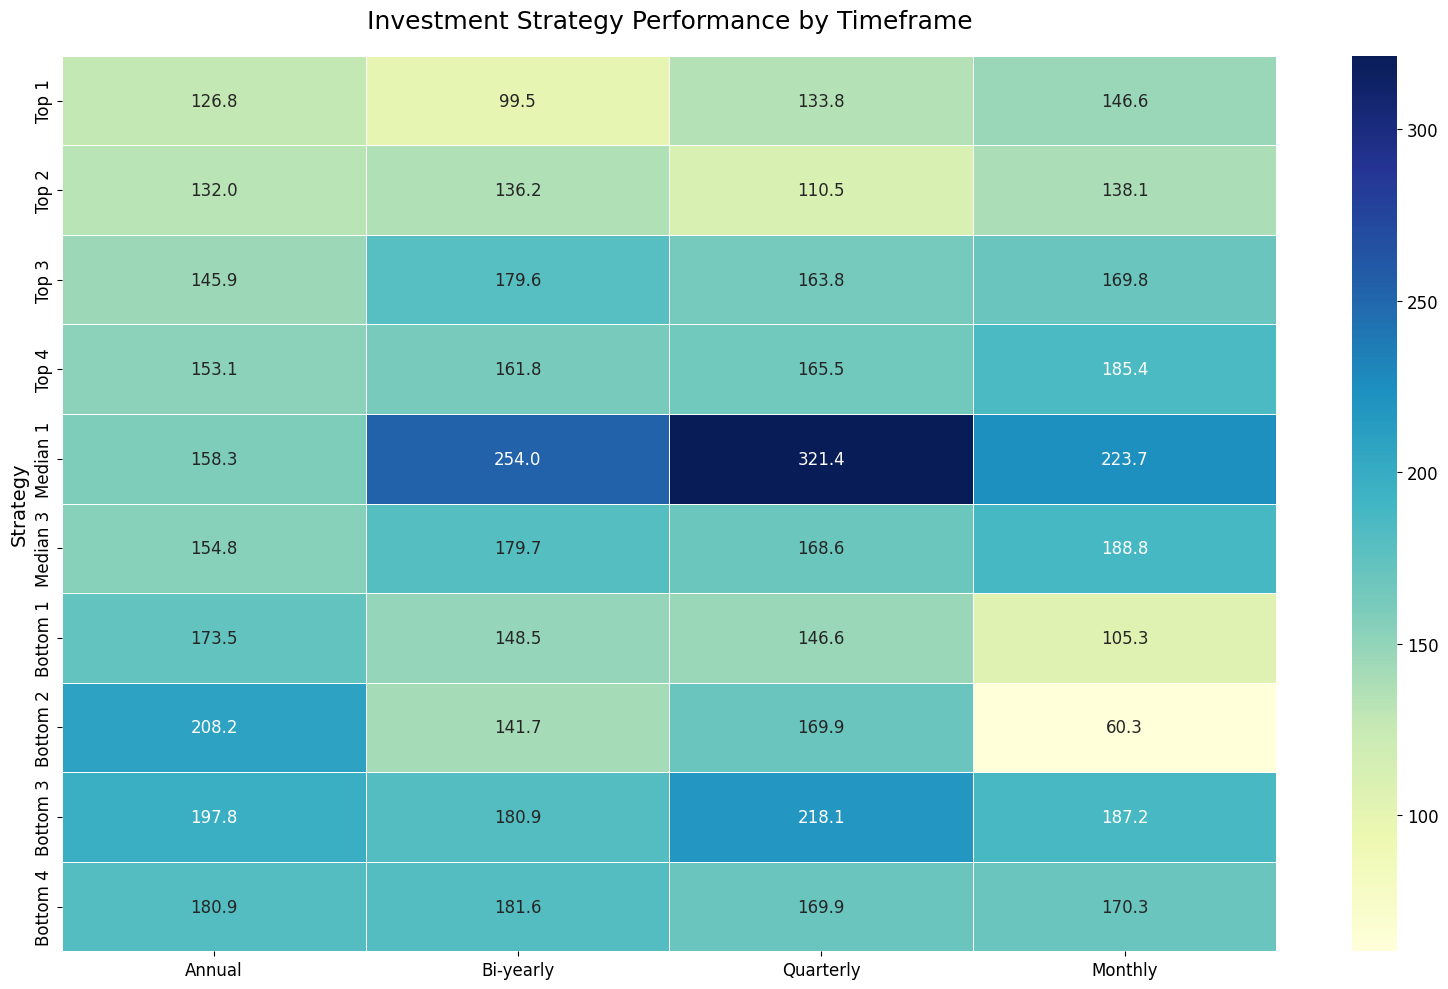

/tmp/ipython-input-1913392949.py:48: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 0}` instead.

  barplot = sns.barplot(


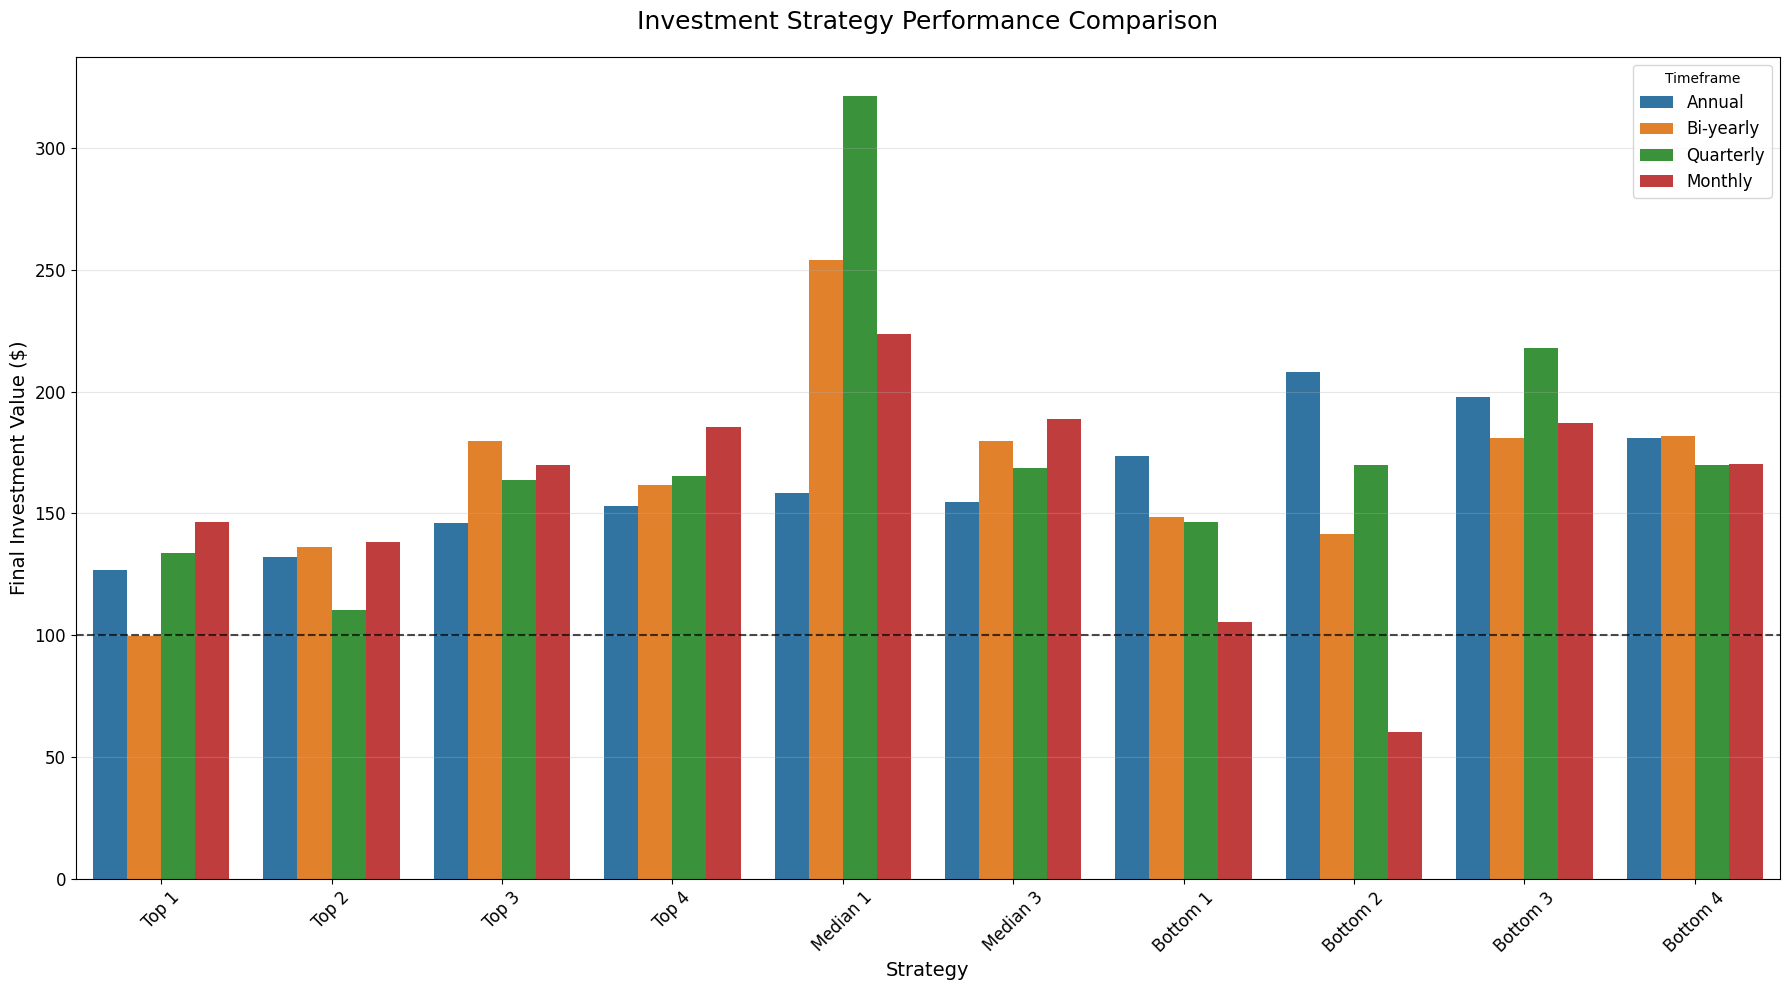

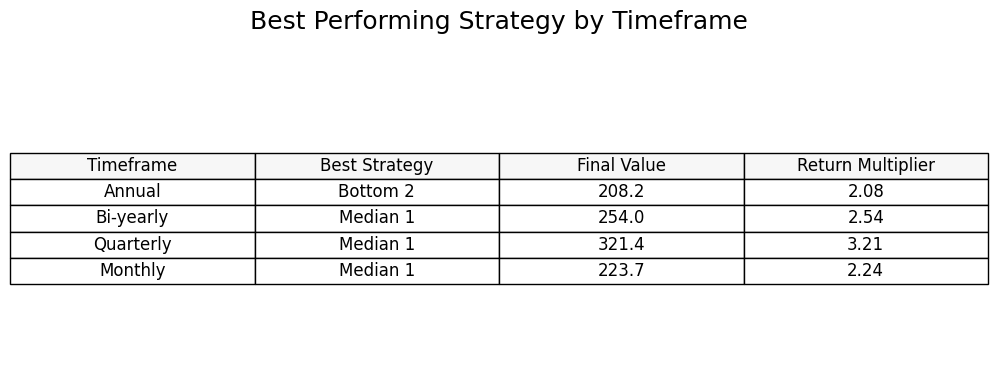


Strategy Ranking Consistency Across Timeframes:
          Annual Rank  Bi-yearly Rank  Quarterly Rank  Monthly Rank  \
Strategy                                                              
Median 1          5.0             1.0             1.0           1.0   
Bottom 3          2.0             3.0             2.0           3.0   
Bottom 4          3.0             2.0             3.5           5.0   
Median 3          6.0             4.0             5.0           2.0   
Top 4             7.0             6.0             6.0           4.0   
Bottom 2          1.0             8.0             3.5          10.0   
Top 3             8.0             5.0             7.0           6.0   
Bottom 1          4.0             7.0             8.0           9.0   
Top 2             9.0             9.0            10.0           8.0   
Top 1            10.0            10.0             9.0           7.0   

          Rank Stability  Average Rank  
Strategy                                
Median 1        

In [47]:
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12

# Performance data
data = {
    'Strategy': [
        'Top 1', 'Top 2', 'Top 3', 'Top 4',
        'Median 1', 'Median 3',
        'Bottom 1', 'Bottom 2', 'Bottom 3', 'Bottom 4'
    ],
    'Annual': [126.80,  132.04, 145.92, 153.12, 158.27, 154.85,  173.5, 208.22,  197.77,180.88],
    'Bi-yearly': [99.51, 136.25, 179.63, 161.80, 254.03, 179.66, 148.48, 141.71, 180.942, 181.58],
    'Quarterly': [133.75, 110.52, 163.85, 165.53, 321.42, 168.57, 146.61, 169.93, 218.08, 169.86],
    'Monthly': [146.64, 138.09 , 169.78, 185.37,  223.67, 188.83, 105.26, 60.33, 187.16, 170.32]
}

# Create DataFrame and round values
performance_df = pd.DataFrame(data).round(1)
performance_df.set_index('Strategy', inplace=True)

# 1. Heatmap Visualization
plt.figure(figsize=(16, 10))
heatmap = sns.heatmap(
    performance_df,
    annot=True,
    fmt='.1f',
    cmap='YlGnBu',
    linewidths=0.5,
    annot_kws={'size': 12}
)
plt.title('Investment Strategy Performance by Timeframe', pad=20)
plt.tight_layout()
plt.savefig('strategy_comparison_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Grouped Bar Chart (without values on bars)
plt.figure(figsize=(18, 10))
plot_df = performance_df.reset_index()
melted_df = pd.melt(plot_df,
                   id_vars=['Strategy'],
                   value_vars=['Annual', 'Bi-yearly', 'Quarterly', 'Monthly'],
                   var_name='Timeframe',
                   value_name='Final Value')

barplot = sns.barplot(
    x='Strategy',
    y='Final Value',
    hue='Timeframe',
    data=melted_df,
    errwidth=0
)

plt.title('Investment Strategy Performance Comparison', pad=20)
plt.xticks(rotation=45)
plt.ylabel('Final Investment Value ($)')
plt.xlabel('Strategy')
plt.grid(axis='y', alpha=0.3)
plt.axhline(y=100, color='black', linestyle='--', alpha=0.7)
plt.legend(title='Timeframe')
plt.tight_layout()
plt.savefig('strategy_comparison_barchart.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. Summary Table of Best Strategies
timeframes = ['Annual', 'Bi-yearly', 'Quarterly', 'Monthly']
best_strategies = performance_df[timeframes].idxmax()

summary_df = pd.DataFrame({
    'Timeframe': timeframes,
    'Best Strategy': best_strategies.values,
    'Final Value': [performance_df.loc[s, t] for t, s in best_strategies.items()],
    'Return Multiplier': [performance_df.loc[s, t]/100 for t, s in best_strategies.items()]
}).round({'Final Value': 1, 'Return Multiplier': 2})

# Create table visualization
fig, ax = plt.subplots(figsize=(10, 4))
ax.axis('off')
table = ax.table(
    cellText=summary_df.values,
    colLabels=summary_df.columns,
    loc='center',
    cellLoc='center',
    colColours=['#f7f7f7']*4
)
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.5)
plt.title('Best Performing Strategy by Timeframe', pad=20)
plt.tight_layout()
plt.savefig('best_strategies_summary.png', dpi=300, bbox_inches='tight')
plt.show()

# 4. Rank Consistency Analysis
def rank_strategies(df, columns):
    return pd.DataFrame(
        {f'{col} Rank': df[col].rank(ascending=False)
         for col in columns},
        index=df.index
    )

rank_df = rank_strategies(performance_df, timeframes)
rank_df['Rank Stability'] = rank_df.std(axis=1).round(2)
rank_df['Average Rank'] = rank_df.mean(axis=1).round(2)
rank_df = rank_df.sort_values('Average Rank')

print("\nStrategy Ranking Consistency Across Timeframes:")
print(rank_df)

In [28]:
!pip uninstall  -y empyrical

In [29]:
!pip install empyrical-reloaded

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 52.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for peewee: filename=peewee-3.17.3-py3-none-any.whl size=138487 sha256=a477a1fec7ea3082245a0ce1ff4df52e10ddc9366340de1845cdf063f46b79d7
  Stored in directory: /root/.cache/pip/wheels/39/c7/dd/909d267742f7fbb941ff081dacd661f622a0b4eb38f667b84b
Successfully built peewee
  Attempting uninstall: peewee
    Found existing installation: peewee 3.18.2
    Uninstalling peewee-3.18.2:
      Successfully uninstalled peewee-3.18.2


In [30]:
from pathlib import Path
import os, pandas as pd, numpy as np
import empyrical as ep

def load_all_csvs(files_path):
    files = sorted(Path(files_path).rglob("*.csv"))
    if not files:
        raise FileNotFoundError(f"No CSVs found under: {files_path}")

    series_list = []
    names = []

    for p in files:
        try:
            df = pd.read_csv(p, low_memory=False)
        except Exception as e:
            print(f"Skip {p.name}: read error -> {e}")
            continue

        if "Date" not in df.columns:
            print(f"Skip {p.name}: no 'Date' column")
            continue

        # parse/sort index
        df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
        df = df.dropna(subset=["Date"]).sort_values("Date").set_index("Date")

        s = None
        # Prefer an explicit Return column
        if "Return" in df.columns:
            s = pd.to_numeric(df["Return"], errors="coerce")
            # If looks like percents (e.g., 5, 2.3), convert to decimals
            if s.dropna().abs().median() > 1:  # heuristic
                s = s / 100.0
        else:
            # Derive returns from price if Return missing
            price_col = next((c for c in ["Adj Close", "Close", "close", "adj_close"] if c in df.columns), None)
            if price_col is None:
                print(f"Skip {p.name}: no 'Return' or price column")
                continue
            px = pd.to_numeric(df[price_col], errors="coerce").dropna()
            if px.empty:
                print(f"Skip {p.name}: price column empty after cleaning")
                continue
            s = px.pct_change().dropna()

        if s is None or s.dropna().shape[0] < 3:
            print(f"Skip {p.name}: not enough usable rows")
            continue

        s.name = p.stem
        series_list.append(s)
        names.append(p.stem)

    if not series_list:
        raise ValueError("No usable series built. Ensure CSVs have 'Return' or 'Adj Close'/'Close'.")

    # Union of dates; later we handle NaNs per column safely
    df_all = pd.concat(series_list, axis=1).sort_index()
    df_all.columns = names
    return df_all

# --- Load all returns ---
files_path = "/content/content/sample_data/stocks"
df_returns = load_all_csvs(files_path)

# --- Build TopN equal-weight strategies per calendar year ---
strategies = {f"Top{n}": [] for n in [1,2,3,4]}
for year, data in df_returns.groupby(df_returns.index.year):
    # per-column total return for the year (ignore NaNs per column)
    cum_rets = (1 + data).apply(lambda col: (1 + col.dropna()).prod() - 1, axis=0)
    ranked = cum_rets.sort_values(ascending=False)

    for n in [1,2,3,4]:
        top = ranked.index[:n]
        if len(top) == 0:
            continue
        # equal-weight daily portfolio across available top tickers (skipna=True)
        strat_daily = data[top].mean(axis=1, skipna=True)
        strategies[f"Top{n}"].append(strat_daily)

# concatenate per-strategy series across years
for k in list(strategies.keys()):
    if strategies[k]:
        strategies[k] = pd.concat(strategies[k]).sort_index()
    else:
        strategies.pop(k, None)

# --- Annual max drawdowns per strategy (using empyrical) ---
annual_drawdowns = {}
for k, series in strategies.items():
    dd_list = []
    for year, data in series.groupby(series.index.year):
        if data.dropna().empty:
            continue
        # empyrical can take returns; to be explicit we can form cumulative curve
        curve = (1 + data.fillna(0)).cumprod()
        # Drawdown as min of (curve/rolling_max - 1)
        rolling = curve.cummax()
        dd = (curve / rolling - 1).min()
        dd_list.append((year, dd))
    if dd_list:
        annual_drawdowns[k] = pd.DataFrame(dd_list, columns=["Year", "MaxDrawdown"]).set_index("Year")

# Sanity print
for strat, df_dd in annual_drawdowns.items():
    print(f"\n{strat} Annual Max Drawdowns:")
    print(df_dd)



Top1 Annual Max Drawdowns:
      MaxDrawdown
Year             
2014    -0.179368
2015    -0.186513
2016    -0.196034
2017    -0.179551
2018    -0.103088
2019    -0.083095
2020    -0.409634
2021    -0.093014
2022    -0.289504
2023    -0.093797
2024    -0.073011

Top2 Annual Max Drawdowns:
      MaxDrawdown
Year             
2014    -0.113979
2015    -0.171148
2016    -0.120677
2017    -0.067746
2018    -0.110047
2019    -0.080160
2020    -0.396221
2021    -0.085212
2022    -0.184709
2023    -0.092199
2024    -0.063223

Top3 Annual Max Drawdowns:
      MaxDrawdown
Year             
2014    -0.108951
2015    -0.158493
2016    -0.100107
2017    -0.052276
2018    -0.146084
2019    -0.088532
2020    -0.395452
2021    -0.063424
2022    -0.153169
2023    -0.105403
2024    -0.081485

Top4 Annual Max Drawdowns:
      MaxDrawdown
Year             
2014    -0.118861
2015    -0.140202
2016    -0.107683
2017    -0.046052
2018    -0.147978
2019    -0.069769
2020    -0.388969
2021    -0.075108
2022  

In [31]:
biyearly_drawdowns = {}  # rename it to semiannual_drawdowns if you want

for k, series in strategies.items():
    dd_list = []

    # Group by year
    for year in series.index.year.unique():
        data_year = series[series.index.year == year]

        # First half: Jan-Jun (ignored for year-end)
        h1 = data_year[data_year.index.month <= 6]
        if not h1.empty:
            # Compute max drawdown if needed, but not saving since we only show H2
            pass

        # Second half: Jul-Dec (year-end snapshot)
        h2 = data_year[data_year.index.month > 6]
        if not h2.empty:
            dd = ep.max_drawdown(h2)
            dd_list.append((f"{year}-H2", dd))

    biyearly_drawdowns[k] = pd.DataFrame(dd_list, columns=["Period", "MaxDrawdown"]).set_index("Period")

# --- Show results ---
for strat, df_dd in biyearly_drawdowns.items():
    print(f"\n{strat} Semi-Annual Year-End Max Drawdowns:")
    print(df_dd)



Top1 Semi-Annual Year-End Max Drawdowns:
         MaxDrawdown
Period              
2014-H2    -0.102729
2015-H2    -0.128820
2016-H2    -0.106346
2017-H2    -0.099814
2018-H2    -0.088912
2019-H2    -0.083095
2020-H2    -0.145050
2021-H2    -0.093014
2022-H2    -0.096723
2023-H2    -0.073694
2024-H2    -0.073011

Top2 Semi-Annual Year-End Max Drawdowns:
         MaxDrawdown
Period              
2014-H2    -0.099839
2015-H2    -0.129749
2016-H2    -0.064578
2017-H2    -0.067746
2018-H2    -0.093838
2019-H2    -0.080160
2020-H2    -0.071212
2021-H2    -0.065559
2022-H2    -0.086098
2023-H2    -0.079579
2024-H2    -0.063223

Top3 Semi-Annual Year-End Max Drawdowns:
         MaxDrawdown
Period              
2014-H2    -0.107324
2015-H2    -0.118021
2016-H2    -0.085806
2017-H2    -0.052276
2018-H2    -0.115266
2019-H2    -0.088532
2020-H2    -0.077501
2021-H2    -0.063424
2022-H2    -0.082281
2023-H2    -0.101172
2024-H2    -0.081485

Top4 Semi-Annual Year-End Max Drawdowns:
         MaxD

In [32]:

quarterly_drawdowns = {}

for k, series in strategies.items():
    dd_list = []

    quarter_groups = series.groupby([series.index.year, series.index.quarter])

    for (year, qtr), data in quarter_groups:
        dd = ep.max_drawdown(data)
        dd_list.append((f"{year}-Q{qtr}", dd))

    quarterly_drawdowns[k] = pd.DataFrame(dd_list, columns=["Quarter", "MaxDrawdown"]).set_index("Quarter")

for strat, df_dd in quarterly_drawdowns.items():
    print(f"\n{strat} Quarterly Max Drawdowns:")
    print(df_dd)



Top1 Quarterly Max Drawdowns:
         MaxDrawdown
Quarter             
2014-Q1    -0.056903
2014-Q2    -0.118569
2014-Q3    -0.055326
2014-Q4    -0.056652
2015-Q1    -0.069509
2015-Q2    -0.086603
2015-Q3    -0.128820
2015-Q4    -0.057615
2016-Q1    -0.190345
2016-Q2    -0.196034
2016-Q3    -0.106346
2016-Q4    -0.082977
2017-Q1    -0.106852
2017-Q2    -0.128565
2017-Q3    -0.090949
2017-Q4    -0.093174
2018-Q1    -0.103088
2018-Q2    -0.039008
2018-Q3    -0.057237
2018-Q4    -0.078551
2019-Q1    -0.049140
2019-Q2    -0.038917
2019-Q3    -0.083095
2019-Q4    -0.064765
2020-Q1    -0.409634
2020-Q2    -0.089218
2020-Q3    -0.092121
2020-Q4    -0.094787
2021-Q1    -0.076503
2021-Q2    -0.056059
2021-Q3    -0.072083
2021-Q4    -0.057158
2022-Q1    -0.084014
2022-Q2    -0.213770
2022-Q3    -0.096723
2022-Q4    -0.070866
2023-Q1    -0.093797
2023-Q2    -0.049515
2023-Q3    -0.073694
2023-Q4    -0.066946
2024-Q1    -0.043768
2024-Q2    -0.028729
2024-Q3    -0.073011
2024-Q4    -0.065987

To

In [33]:
# --- Extract end-of-year drawdowns from monthly drawdowns ---
year_end_drawdowns = {}

for strat, series in strategies.items():
    # compute monthly drawdowns first
    month_groups = series.groupby([series.index.year, series.index.month])
    month_dd = []
    for (year, month), data in month_groups:
        dd = ep.max_drawdown(data)
        month_dd.append((pd.Timestamp(year=year, month=month, day=1), dd))

    monthly_dd_df = pd.DataFrame(month_dd, columns=["Date", "MaxDrawdown"]).set_index("Date")

    # pick the last month of each year
    eoy_dd = monthly_dd_df.groupby(monthly_dd_df.index.year).tail(1)
    year_end_drawdowns[strat] = eoy_dd

# --- Show results ---
for strat, df_dd in year_end_drawdowns.items():
    print(f"\n{strat} Year-End Drawdowns (from monthly calculation):")
    print(df_dd)



Top1 Year-End Drawdowns (from monthly calculation):
            MaxDrawdown
Date                   
2014-12-01    -0.039867
2015-12-01    -0.057615
2016-12-01    -0.082977
2017-12-01    -0.020968
2018-12-01    -0.067221
2019-12-01    -0.025242
2020-12-01    -0.024367
2021-12-01    -0.057158
2022-12-01    -0.040838
2023-12-01    -0.018122
2024-12-01    -0.037900

Top2 Year-End Drawdowns (from monthly calculation):
            MaxDrawdown
Date                   
2014-12-01    -0.055248
2015-12-01    -0.059397
2016-12-01    -0.032656
2017-12-01    -0.018214
2018-12-01    -0.049889
2019-12-01    -0.022279
2020-12-01    -0.022130
2021-12-01    -0.031214
2022-12-01    -0.026620
2023-12-01    -0.010389
2024-12-01    -0.038302

Top3 Year-End Drawdowns (from monthly calculation):
            MaxDrawdown
Date                   
2014-12-01    -0.061618
2015-12-01    -0.065020
2016-12-01    -0.014215
2017-12-01    -0.018399
2018-12-01    -0.055024
2019-12-01    -0.021816
2020-12-01    -0.021914
2

In [34]:
bottom_strategies = {}

for year, data in df_returns.groupby(df_returns.index.year):
    # compute cumulative return of each stock for that year
    cum_rets = (1 + data).prod() - 1
    # rank stocks ascending (bottom performers first)
    ranked = cum_rets.sort_values(ascending=True)

    # Build Bottom1–Bottom4 portfolios
    for n in [1, 2, 3, 4]:
        bottom_stocks = ranked.index[:n]
        strat_daily = data[bottom_stocks].mean(axis=1)  # equal-weighted
        bottom_strategies.setdefault(f"Bottom{n}", []).append(strat_daily)

# Concatenate annual pieces into full daily series
for k in bottom_strategies.keys():
    bottom_strategies[k] = pd.concat(bottom_strategies[k]).sort_index()

# --- Compute annual max drawdowns ---
annual_drawdowns_bottom = {}
for k, series in bottom_strategies.items():
    dd_list = []
    for year, data in series.groupby(series.index.year):
        dd = ep.max_drawdown(data)  # max drawdown for that year
        dd_list.append((year, dd))
    annual_drawdowns_bottom[k] = pd.DataFrame(dd_list, columns=["Year", "MaxDrawdown"]).set_index("Year")

# --- Show results ---
for strat, df_dd in annual_drawdowns_bottom.items():
    print(f"\n{strat} Annual Max Drawdowns (Bottom strategy):")
    print(df_dd)



Bottom1 Annual Max Drawdowns (Bottom strategy):
      MaxDrawdown
Year             
2014    -0.291395
2015    -0.542371
2016    -0.247537
2017    -0.194641
2018    -0.340930
2019    -0.193917
2020    -0.234530
2021    -0.099187
2022    -0.485267
2023    -0.307921
2024    -0.241950

Bottom2 Annual Max Drawdowns (Bottom strategy):
      MaxDrawdown
Year             
2014    -0.156079
2015    -0.339421
2016    -0.232203
2017    -0.125948
2018    -0.299523
2019    -0.100000
2020    -0.301670
2021    -0.127679
2022    -0.419360
2023    -0.187149
2024    -0.157947

Bottom3 Annual Max Drawdowns (Bottom strategy):
      MaxDrawdown
Year             
2014    -0.124614
2015    -0.275592
2016    -0.164305
2017    -0.086886
2018    -0.260212
2019    -0.129972
2020    -0.332009
2021    -0.106723
2022    -0.362056
2023    -0.150037
2024    -0.151591

Bottom4 Annual Max Drawdowns (Bottom strategy):
      MaxDrawdown
Year             
2014    -0.107425
2015    -0.236621
2016    -0.135407
2017    -0.0

In [35]:
year_end_semiannual_drawdowns_bottom = {}

for k in [1, 2, 3, 4]:  # Bottom1–Bottom4
    strat_name = f"Bottom{k}"
    bottom_strategies_semi = []

    for year, data_year in df_returns.groupby(df_returns.index.year):
        # Only consider the second half: Jul–Dec
        second_half = data_year[data_year.index.month > 6]
        if not second_half.empty:
            cum_rets = (1 + second_half).prod() - 1
            ranked = cum_rets.sort_values(ascending=True)
            bottom_stocks = ranked.index[:k]
            strat_daily = second_half[bottom_stocks].mean(axis=1)
            bottom_strategies_semi.append((f"{year}-H2", strat_daily))

    # Compute max drawdown for each H2 (year-end)
    dd_list = []
    for period_name, strat_daily in bottom_strategies_semi:
        dd = ep.max_drawdown(strat_daily)
        dd_list.append((period_name, dd))

    year_end_semiannual_drawdowns_bottom[strat_name] = pd.DataFrame(dd_list, columns=["Period", "MaxDrawdown"]).set_index("Period")

# --- Show results ---
for strat, df_dd in year_end_semiannual_drawdowns_bottom.items():
    print(f"\n{strat} Year-End Semi-Annual Max Drawdowns (Bottom strategy):")
    print(df_dd)



Bottom1 Year-End Semi-Annual Max Drawdowns (Bottom strategy):
         MaxDrawdown
Period              
2014-H2    -0.291395
2015-H2    -0.454168
2016-H2    -0.170940
2017-H2    -0.145080
2018-H2    -0.302386
2019-H2    -0.190097
2020-H2    -0.179558
2021-H2    -0.189926
2022-H2    -0.161689
2023-H2    -0.093642
2024-H2    -0.188340

Bottom2 Year-End Semi-Annual Max Drawdowns (Bottom strategy):
         MaxDrawdown
Period              
2014-H2    -0.175269
2015-H2    -0.289064
2016-H2    -0.115925
2017-H2    -0.085659
2018-H2    -0.235363
2019-H2    -0.204514
2020-H2    -0.133157
2021-H2    -0.127679
2022-H2    -0.215064
2023-H2    -0.095953
2024-H2    -0.137621

Bottom3 Year-End Semi-Annual Max Drawdowns (Bottom strategy):
         MaxDrawdown
Period              
2014-H2    -0.120492
2015-H2    -0.221602
2016-H2    -0.089332
2017-H2    -0.064652
2018-H2    -0.183960
2019-H2    -0.129972
2020-H2    -0.125006
2021-H2    -0.106723
2022-H2    -0.200833
2023-H2    -0.098287
2024-H2    -0

In [36]:
year_end_quarterly_drawdowns_bottom = {}

for k in [1, 2, 3, 4]:  # Bottom1–Bottom4
    strat_name = f"Bottom{k}"
    bottom_strategies_q4 = []

    for year, data_year in df_returns.groupby(df_returns.index.year):
        # Only consider Q4: Oct–Dec
        q4 = data_year[data_year.index.month >= 10]
        if not q4.empty:
            cum_rets = (1 + q4).prod() - 1
            ranked = cum_rets.sort_values(ascending=True)
            bottom_stocks = ranked.index[:k]
            strat_daily = q4[bottom_stocks].mean(axis=1)
            bottom_strategies_q4.append((f"{year}-Q4", strat_daily))

    # Compute max drawdown for Q4 of each year
    dd_list = []
    for period_name, strat_daily in bottom_strategies_q4:
        dd = ep.max_drawdown(strat_daily)
        dd_list.append((period_name, dd))

    year_end_quarterly_drawdowns_bottom[strat_name] = pd.DataFrame(dd_list, columns=["Period", "MaxDrawdown"]).set_index("Period")

# --- Show results ---
for strat, df_dd in year_end_quarterly_drawdowns_bottom.items():
    print(f"\n{strat} Year-End Quarterly Max Drawdowns (Bottom strategy):")
    print(df_dd)



Bottom1 Year-End Quarterly Max Drawdowns (Bottom strategy):
         MaxDrawdown
Period              
2014-Q4    -0.177917
2015-Q4    -0.351309
2016-Q4    -0.169313
2017-Q4    -0.082126
2018-Q4    -0.215495
2019-Q4    -0.069752
2020-Q4    -0.123329
2021-Q4    -0.095704
2022-Q4    -0.083705
2023-Q4    -0.089583
2024-Q4    -0.150269

Bottom2 Year-End Quarterly Max Drawdowns (Bottom strategy):
         MaxDrawdown
Period              
2014-Q4    -0.119497
2015-Q4    -0.209865
2016-Q4    -0.157134
2017-Q4    -0.085659
2018-Q4    -0.179566
2019-Q4    -0.054733
2020-Q4    -0.095570
2021-Q4    -0.065559
2022-Q4    -0.038161
2023-Q4    -0.072147
2024-Q4    -0.131739

Bottom3 Year-End Quarterly Max Drawdowns (Bottom strategy):
         MaxDrawdown
Period              
2014-Q4    -0.080237
2015-Q4    -0.159247
2016-Q4    -0.121483
2017-Q4    -0.064652
2018-Q4    -0.153226
2019-Q4    -0.048758
2020-Q4    -0.075597
2021-Q4    -0.063674
2022-Q4    -0.049550
2023-Q4    -0.073087
2024-Q4    -0.12279

In [37]:
# --- Bottom strategy: monthly drawdowns, show only December of each year ---
year_end_monthly_drawdowns_bottom = {}

for k in [1, 2, 3, 4]:  # Bottom1–Bottom4
    strat_name = f"Bottom{k}"
    monthly_dd_list = []

    # Group by year and month
    month_groups = df_returns.groupby([df_returns.index.year, df_returns.index.month])

    for (year, month), data_month in month_groups:
        if data_month.empty:
            continue
        # Pick bottom k stocks based on cumulative return over the month
        cum_rets = (1 + data_month).prod() - 1
        ranked = cum_rets.sort_values(ascending=True)
        bottom_stocks = ranked.index[:k]
        strat_daily = data_month[bottom_stocks].mean(axis=1)
        # Compute monthly max drawdown
        dd = ep.max_drawdown(strat_daily)
        monthly_dd_list.append((year, month, dd))

    # Build DataFrame
    monthly_dd_df = pd.DataFrame(monthly_dd_list, columns=["Year", "Month", "MaxDrawdown"])

    # Keep only December for each year
    year_end_dd = monthly_dd_df[monthly_dd_df["Month"] == 12].copy()
    year_end_dd["Period"] = year_end_dd["Year"].astype(str) + "-Dec"
    year_end_dd = year_end_dd.set_index("Period")[["MaxDrawdown"]]

    year_end_monthly_drawdowns_bottom[strat_name] = year_end_dd

# --- Show results ---
for strat, df_dd in year_end_monthly_drawdowns_bottom.items():
    print(f"\n{strat} Year-End Monthly Max Drawdowns (Bottom strategy - December):")
    print(df_dd)



Bottom1 Year-End Monthly Max Drawdowns (Bottom strategy - December):
          MaxDrawdown
Period               
2014-Dec    -0.134612
2015-Dec    -0.164891
2016-Dec    -0.034048
2017-Dec    -0.019877
2018-Dec    -0.147714
2019-Dec    -0.040784
2020-Dec    -0.075003
2021-Dec    -0.057158
2022-Dec    -0.075867
2023-Dec    -0.025500
2024-Dec    -0.093728

Bottom2 Year-End Monthly Max Drawdowns (Bottom strategy - December):
          MaxDrawdown
Period               
2014-Dec    -0.102931
2015-Dec    -0.119124
2016-Dec    -0.029094
2017-Dec    -0.016014
2018-Dec    -0.107758
2019-Dec    -0.028576
2020-Dec    -0.027606
2021-Dec    -0.042386
2022-Dec    -0.072112
2023-Dec    -0.018100
2024-Dec    -0.070332

Bottom3 Year-End Monthly Max Drawdowns (Bottom strategy - December):
          MaxDrawdown
Period               
2014-Dec    -0.090277
2015-Dec    -0.092290
2016-Dec    -0.022244
2017-Dec    -0.016305
2018-Dec    -0.089718
2019-Dec    -0.030061
2020-Dec    -0.021417
2021-Dec    -0.02783

In [38]:
import pandas as pd
import empyrical as ep

# Dictionary to store all drawdowns
mid1_drawdowns = {}

# --- Helper function to get "mid 1" stock in a period ---
def get_mid_stock(data):
    # Rank cumulative returns descending (top first)
    cum_rets = (1 + data).prod() - 1
    ranked = cum_rets.sort_values(ascending=False)
    n = len(ranked)
    mid_index = n // 2  # pick middle stock
    return ranked.index[mid_index]

# --- Annual drawdowns ---
annual_dd = []
for year, data_year in df_returns.groupby(df_returns.index.year):
    mid_stock = get_mid_stock(data_year)
    strat_daily = data_year[[mid_stock]]
    dd = ep.max_drawdown(strat_daily)
    annual_dd.append((year, dd))
mid1_drawdowns['Annual'] = pd.DataFrame(annual_dd, columns=['Period','MaxDrawdown']).set_index('Period')

# --- Semi-Annual drawdowns ---
semi_dd = []
for year, data_year in df_returns.groupby(df_returns.index.year):
    # H1: Jan-Jun
    h1 = data_year[data_year.index.month <= 6]
    if not h1.empty:
        mid_stock = get_mid_stock(h1)
        dd = ep.max_drawdown(h1[[mid_stock]])
        semi_dd.append((f"{year}-H1", dd))
    # H2: Jul-Dec
    h2 = data_year[data_year.index.month > 6]
    if not h2.empty:
        mid_stock = get_mid_stock(h2)
        dd = ep.max_drawdown(h2[[mid_stock]])
        semi_dd.append((f"{year}-H2", dd))
mid1_drawdowns['Semi-Annual'] = pd.DataFrame(semi_dd, columns=['Period','MaxDrawdown']).set_index('Period')

# --- Quarterly drawdowns ---
quarter_dd = []
for (year, qtr), data_qtr in df_returns.groupby([df_returns.index.year, df_returns.index.quarter]):
    mid_stock = get_mid_stock(data_qtr)
    dd = ep.max_drawdown(data_qtr[[mid_stock]])
    quarter_dd.append((f"{year}-Q{qtr}", dd))
mid1_drawdowns['Quarterly'] = pd.DataFrame(quarter_dd, columns=['Period','MaxDrawdown']).set_index('Period')

# --- Monthly drawdowns ---
month_dd = []
for (year, month), data_month in df_returns.groupby([df_returns.index.year, df_returns.index.month]):
    mid_stock = get_mid_stock(data_month)
    dd = ep.max_drawdown(data_month[[mid_stock]])
    month_dd.append((f"{year}-{month:02d}", dd))
mid1_drawdowns['Monthly'] = pd.DataFrame(month_dd, columns=['Period','MaxDrawdown']).set_index('Period')

mid1_year_end_drawdowns = {}

# Annual (already year-end)
mid1_year_end_drawdowns['Annual'] = mid1_drawdowns['Annual']

# Semi-Annual: keep only H2
semi_dd = mid1_drawdowns['Semi-Annual']
mid1_year_end_drawdowns['Semi-Annual'] = semi_dd[semi_dd.index.str.endswith('H2')]

# Quarterly: keep only Q4
quarter_dd = mid1_drawdowns['Quarterly']
mid1_year_end_drawdowns['Quarterly'] = quarter_dd[quarter_dd.index.str.endswith('Q4')]

month_dd = mid1_drawdowns['Monthly']
mid1_year_end_drawdowns['Monthly'] = month_dd[month_dd.index.str.endswith('-12')]

for freq, df_dd in mid1_year_end_drawdowns.items():
    print(f"\nMid1 Strategy Year-End {freq} Max Drawdowns:")
    print(df_dd)



Mid1 Strategy Year-End Annual Max Drawdowns:
                                  MaxDrawdown
Period                                       
2014        finance   -0.13286
dtype: float64
2015    healthcare   -0.185877
dtype: float64
2016     healthcare   -0.17094
dtype: float64
2017       finance   -0.068299
dtype: float64
2018       finance   -0.223281
dtype: float64
2019    technology   -0.231051
dtype: float64
2020       finance   -0.412855
dtype: float64
2021    technology   -0.131018
dtype: float64
2022    technology   -0.311677
dtype: float64
2023       finance   -0.165054
dtype: float64
2024    healthcare   -0.219405
dtype: float64

Mid1 Strategy Year-End Semi-Annual Max Drawdowns:
                                        MaxDrawdown
Period                                             
2014-H2           finance   -0.12319
dtype: float64
2015-H2          finance   -0.134561
dtype: float64
2016-H2          finance   -0.076034
dtype: float64
2017-H2          finance   -0.068299
dtype: f

In [39]:


# Dictionary to store all drawdowns
median3_drawdowns = {}

# --- Helper function to get "median 3" stocks in a period ---
def get_median3_stocks(data):
    cum_rets = (1 + data).prod() - 1
    ranked = cum_rets.sort_values(ascending=False)  # descending: top first
    n = len(ranked)
    if n <= 3:
        return ranked.index  # if <=3 stocks, just return all
    start = (n - 3) // 2
    return ranked.index[start:start+3]

# --- Annual drawdowns ---
annual_dd = []
for year, data_year in df_returns.groupby(df_returns.index.year):
    median_stocks = get_median3_stocks(data_year)
    strat_daily = data_year[median_stocks].mean(axis=1)
    dd = ep.max_drawdown(strat_daily)
    annual_dd.append((year, dd))
median3_drawdowns['Annual'] = pd.DataFrame(annual_dd, columns=['Period','MaxDrawdown']).set_index('Period')

# --- Semi-Annual drawdowns ---
semi_dd = []
for year, data_year in df_returns.groupby(df_returns.index.year):
    # H1: Jan-Jun
    h1 = data_year[data_year.index.month <= 6]
    if not h1.empty:
        median_stocks = get_median3_stocks(h1)
        strat_daily = h1[median_stocks].mean(axis=1)
        dd = ep.max_drawdown(strat_daily)
        semi_dd.append((f"{year}-H1", dd))
    # H2: Jul-Dec
    h2 = data_year[data_year.index.month > 6]
    if not h2.empty:
        median_stocks = get_median3_stocks(h2)
        strat_daily = h2[median_stocks].mean(axis=1)
        dd = ep.max_drawdown(strat_daily)
        semi_dd.append((f"{year}-H2", dd))
median3_drawdowns['Semi-Annual'] = pd.DataFrame(semi_dd, columns=['Period','MaxDrawdown']).set_index('Period')

# --- Quarterly drawdowns ---
quarter_dd = []
for (year, qtr), data_qtr in df_returns.groupby([df_returns.index.year, df_returns.index.quarter]):
    median_stocks = get_median3_stocks(data_qtr)
    strat_daily = data_qtr[median_stocks].mean(axis=1)
    dd = ep.max_drawdown(strat_daily)
    quarter_dd.append((f"{year}-Q{qtr}", dd))
median3_drawdowns['Quarterly'] = pd.DataFrame(quarter_dd, columns=['Period','MaxDrawdown']).set_index('Period')

# --- Monthly drawdowns ---
month_dd = []
for (year, month), data_month in df_returns.groupby([df_returns.index.year, df_returns.index.month]):
    median_stocks = get_median3_stocks(data_month)
    strat_daily = data_month[median_stocks].mean(axis=1)
    dd = ep.max_drawdown(strat_daily)
    month_dd.append((f"{year}-{month:02d}", dd))
median3_drawdowns['Monthly'] = pd.DataFrame(month_dd, columns=['Period','MaxDrawdown']).set_index('Period')

# --- Filter year-end only drawdowns ---
median3_year_end_drawdowns = {}

# Annual (already year-end)
median3_year_end_drawdowns['Annual'] = median3_drawdowns['Annual']

# Semi-Annual: keep only H2
semi_dd = median3_drawdowns['Semi-Annual']
median3_year_end_drawdowns['Semi-Annual'] = semi_dd[semi_dd.index.str.endswith('H2')]

# Quarterly: keep only Q4
quarter_dd = median3_drawdowns['Quarterly']
median3_year_end_drawdowns['Quarterly'] = quarter_dd[quarter_dd.index.str.endswith('Q4')]

# Monthly: keep only December
month_dd = median3_drawdowns['Monthly']
median3_year_end_drawdowns['Monthly'] = month_dd[month_dd.index.str.endswith('-12')]

# --- Show results ---
for freq, df_dd in median3_year_end_drawdowns.items():
    print(f"\nMedian3 Strategy Year-End {freq} Max Drawdowns:")
    print(df_dd)



Median3 Strategy Year-End Annual Max Drawdowns:
        MaxDrawdown
Period             
2014      -0.106232
2015      -0.131129
2016      -0.147542
2017      -0.071908
2018      -0.219301
2019      -0.078094
2020      -0.391213
2021      -0.081963
2022      -0.203882
2023      -0.111806
2024      -0.105246

Median3 Strategy Year-End Semi-Annual Max Drawdowns:
         MaxDrawdown
Period              
2014-H2    -0.107324
2015-H2    -0.106386
2016-H2    -0.096428
2017-H2    -0.034870
2018-H2    -0.136263
2019-H2    -0.076157
2020-H2    -0.083859
2021-H2    -0.082792
2022-H2    -0.201823
2023-H2    -0.109667
2024-H2    -0.105246

Median3 Strategy Year-End Quarterly Max Drawdowns:
         MaxDrawdown
Period              
2014-Q4    -0.070870
2015-Q4    -0.077744
2016-Q4    -0.088832
2017-Q4    -0.046763
2018-Q4    -0.112671
2019-Q4    -0.049727
2020-Q4    -0.079980
2021-Q4    -0.040538
2022-Q4    -0.070496
2023-Q4    -0.073586
2024-Q4    -0.083722

Median3 Strategy Year-End Monthly Max 

In [40]:
# --- Build ALL_DRAWNDOWNS safely (put this before the apply/concat section) ---

def _filter_q4_only(d):
    """Keep only Q4 rows for each DF if the index looks like 'YYYY-Q4'."""
    out = {}
    for k, df in d.items():
        try:
            mask = df.index.astype(str).str.endswith('Q4')
            out[k] = df[mask]
        except Exception:
            out[k] = df
    return out

# Grab what exists in the current scope (use {} if missing)
annual_top    = globals().get('annual_drawdowns', {})
annual_bottom = globals().get('annual_drawdowns_bottom', {})

semi_top      = globals().get('biyearly_drawdowns', {})
semi_bottom   = globals().get('year_end_semiannual_drawdowns_bottom', {})

qtr_top_raw   = globals().get('quarterly_drawdowns', {})
qtr_top       = _filter_q4_only(qtr_top_raw)
qtr_bottom    = globals().get('year_end_quarterly_drawdowns_bottom', {})

mon_top       = globals().get('year_end_drawdowns', {})
mon_bottom    = globals().get('year_end_monthly_drawdowns_bottom', {})

mid1_sets     = globals().get('mid1_year_end_drawdowns', {})
median3_sets  = globals().get('median3_year_end_drawdowns', {})

all_drawdowns = {
    "Annual":      {**annual_top, **annual_bottom},
    "Semi-Annual": {**semi_top,   **semi_bottom},
    "Quarterly":   {**qtr_top,    **qtr_bottom},
    "Monthly":     {**mon_top,    **mon_bottom},
}

# Inject Mid1 / Median3 per frequency if present
for freq in ["Annual", "Semi-Annual", "Quarterly", "Monthly"]:
    if isinstance(mid1_sets, dict) and freq in mid1_sets:
        all_drawdowns[freq]["Mid1"] = mid1_sets[freq]
    if isinstance(median3_sets, dict) and freq in median3_sets:
        all_drawdowns[freq]["Median3"] = median3_sets[freq]


In [41]:
all_drawdowns

{'Annual': {'Top1':       MaxDrawdown
  Year             
  2014    -0.179368
  2015    -0.186513
  2016    -0.196034
  2017    -0.179551
  2018    -0.103088
  2019    -0.083095
  2020    -0.409634
  2021    -0.093014
  2022    -0.289504
  2023    -0.093797
  2024    -0.073011,
  'Top2':       MaxDrawdown
  Year             
  2014    -0.113979
  2015    -0.171148
  2016    -0.120677
  2017    -0.067746
  2018    -0.110047
  2019    -0.080160
  2020    -0.396221
  2021    -0.085212
  2022    -0.184709
  2023    -0.092199
  2024    -0.063223,
  'Top3':       MaxDrawdown
  Year             
  2014    -0.108951
  2015    -0.158493
  2016    -0.100107
  2017    -0.052276
  2018    -0.146084
  2019    -0.088532
  2020    -0.395452
  2021    -0.063424
  2022    -0.153169
  2023    -0.105403
  2024    -0.081485,
  'Top4':       MaxDrawdown
  Year             
  2014    -0.118861
  2015    -0.140202
  2016    -0.107683
  2017    -0.046052
  2018    -0.147978
  2019    -0.069769
  2020    -0.38

/tmp/ipython-input-1497192607.py:110: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 0}` instead.

  sns.barplot(


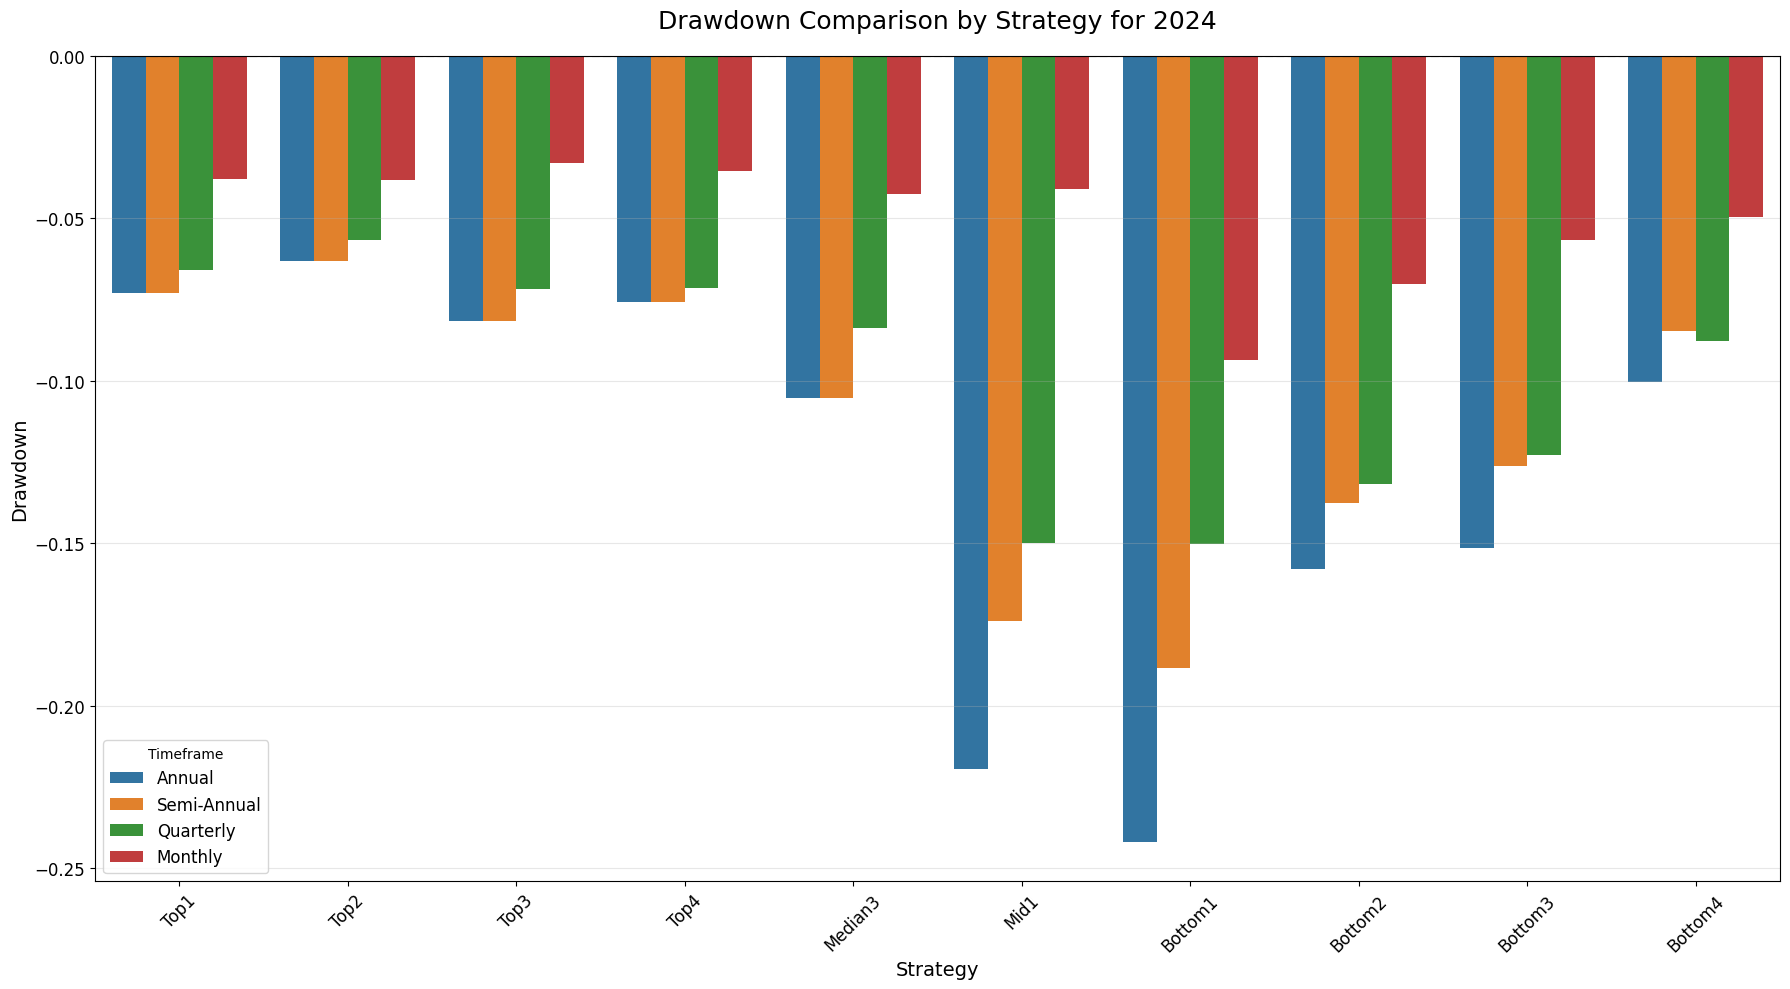

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ---------- helpers: unwrap and extract 2024 value -------------------------

def _extract_scalar(v):
    if isinstance(v, pd.Series):
        return v.iloc[0] if len(v) else np.nan
    if isinstance(v, dict):
        return next(iter(v.values())) if v else np.nan
    if isinstance(v, (list, tuple, np.ndarray)):
        return v[0] if len(v) else np.nan
    return v

def _to_series_one_col(obj) -> pd.Series:
    """
    Return a 1D numeric Series aligned to the original index.
    - If DataFrame, prefer 'MaxDrawdown'; unwrap object cells (Mid1) to scalars.
    - If Series, unwrap each element, then coerce numeric.
    - Else, return a 1-length Series.
    """
    if isinstance(obj, pd.DataFrame):
        col = obj["MaxDrawdown"] if "MaxDrawdown" in obj.columns else obj.iloc[:, 0]
        if col.dtype == "O":
            col = col.map(_extract_scalar)
        s = pd.to_numeric(col, errors="coerce")
        s.index = obj.index
        return s

    if isinstance(obj, pd.Series):
        s = obj.map(_extract_scalar)
        return pd.to_numeric(s, errors="coerce")

    return pd.Series([pd.to_numeric(obj, errors="coerce")], name="value")

def _last_value_for_year(s: pd.Series, year: int = 2024):
    """
    Get the last value for the given year from mixed index types.
    Matches: 2024, 2024-H2, 2024-Q4, 2024-12, 2024-Dec, 2024-12-01, etc.
    """
    idx = s.index

    # MultiIndex: search each level for a year match
    if isinstance(idx, pd.MultiIndex):
        for lvl in range(idx.nlevels):
            lv = idx.get_level_values(lvl)
            if pd.api.types.is_integer_dtype(lv):
                mask = (lv == year)
            elif isinstance(lv, pd.DatetimeIndex):
                mask = (lv.year == year)
            elif isinstance(lv, pd.PeriodIndex):
                mask = (lv.asfreq("Y").year == year)
            else:
                mask = lv.astype(str).str.startswith(str(year))
            if getattr(mask, "any", lambda: False)():
                return s[mask].iloc[-1]
        return np.nan

    # Datetime / Period
    if isinstance(idx, pd.DatetimeIndex):
        m = (idx.year == year)
        return s[m].iloc[-1] if m.any() else np.nan
    if isinstance(idx, pd.PeriodIndex):
        m = (idx.asfreq("Y").year == year)
        return s[m].iloc[-1] if m.any() else np.nan

    # Integer years
    if pd.api.types.is_integer_dtype(idx):
        return s.loc[year] if year in idx else np.nan

    # Strings
    idx_str = idx.astype(str)
    m = idx_str.str.startswith(str(year))
    return s[m].iloc[-1] if m.any() else np.nan

# ---------- build tidy DF (includes Mid1) ----------------------------------

rows = []
for timeframe, strat_dict in all_drawdowns.items():
    for strategy, obj in strat_dict.items():
        s = _to_series_one_col(obj)
        val_2024 = _last_value_for_year(s, 2024)
        if pd.notna(val_2024):
            rows.append({"Timeframe": timeframe, "Strategy": strategy, "Drawdown": float(val_2024)})

drawdown_df = pd.DataFrame(rows)

# keep only intended strategies and order
strategy_order = [
    "Top1", "Top2", "Top3", "Top4",
    "Median3", "Mid1",
    "Bottom1", "Bottom2", "Bottom3", "Bottom4",
]
drawdown_df = drawdown_df[drawdown_df["Strategy"].isin(strategy_order)]
drawdown_df["Strategy"]  = pd.Categorical(drawdown_df["Strategy"], categories=strategy_order, ordered=True)

# ---------- plot -----------------------------------------------------------

palette_dict = {
    "Annual": "#1f77b4",
    "Semi-Annual": "#ff7f0e",
    "Quarterly": "#2ca02c",
    "Monthly": "#d62728",
}

plt.figure(figsize=(18, 10))
sns.barplot(
    x="Strategy",
    y="Drawdown",
    hue="Timeframe",
    data=drawdown_df,
    order=strategy_order,
    palette=palette_dict,
    errwidth=0,
)
plt.title("Drawdown Comparison by Strategy for 2024", pad=20)
plt.xticks(rotation=45)
plt.ylabel("Drawdown")
plt.xlabel("Strategy")
plt.grid(axis="y", alpha=0.3)
plt.axhline(y=0, color="black", linestyle="--", alpha=0.7)
plt.legend(title="Timeframe")
plt.tight_layout()
plt.show()

# ---------- quick sanity if Mid1 still missing -----------------------------
if not ((drawdown_df["Strategy"] == "Mid1").any()):
    print("DEBUG: Mid1 not found. Available per timeframe:")
    for tf in ["Annual","Semi-Annual","Quarterly","Monthly"]:
        if "Mid1" in all_drawdowns.get(tf, {}):
            s = _to_series_one_col(all_drawdowns[tf]["Mid1"])
            yrs = s.index.astype(str).str[:4]
            print(tf, "-> years present:", sorted(yrs.unique().tolist()))
            print(tf, "-> 2024 matches:", s[yrs == "2024"].tail())


In [50]:
import os
import pandas as pd

def load_all_csvs(folder_path):
    dataframes = []
    stock_names = []
    for file in os.listdir(folder_path):
        if file.endswith(".csv"):
            df = pd.read_csv(os.path.join(folder_path, file))
            dataframes.append(df)
            stock_names.append(file.replace(".csv", ""))
    return dataframes, stock_names

def simple_buy_and_hold(folder_path, investment=100.0):
    dataframes, stock_names = load_all_csvs(folder_path)
    results = []

    for df, name in zip(dataframes, stock_names):
        df = df.copy()
        df.columns = [col.lower() for col in df.columns]
        if 'date' not in df.columns or 'close' not in df.columns:
            continue

        df['date'] = pd.to_datetime(df['date'], errors='coerce')
        df = df.dropna(subset=['date', 'close'])
        df = df.sort_values('date')

        if df.empty:
            continue

        buy_price = df['close'].iloc[0]
        sell_price = df['close'].iloc[-1]
        shares = investment / buy_price
        final_value = shares * sell_price
        return_pct = (final_value - investment) / investment * 100

        results.append({
            'Stock': name,
            'Buy Price': round(buy_price, 2),
            'Sell Price': round(sell_price, 2),
            'Final Value': round(final_value, 2),
            'Return (%)': round(return_pct, 2)
        })

    return pd.DataFrame(results)

         finance  basic resources  healthcare  technology      reatil
2014  108.927896        88.211147  111.320920   99.723491  111.994189
2015  120.699837        47.318268  113.515167  116.259372  113.046080
2016  118.796485        93.022786  118.161553  151.454677   97.479226
2017  141.421639       117.646267  113.609144  191.469759   95.708888
2018  118.902610       107.635365  124.639392  138.904676   69.533931
2019  164.515223       119.336734  154.180872  180.520886   94.448124
2020  154.818783       135.233314  134.622782  159.269055   95.164313
2021  160.634578       154.061293  157.168459  184.046646  112.197417
2022  125.256053       183.052262  174.523560  145.434873   74.090369
2023  145.278274       159.568769  168.703558  198.864456   98.101704
2024  180.198840       137.303328  166.308244  217.105292   92.660098


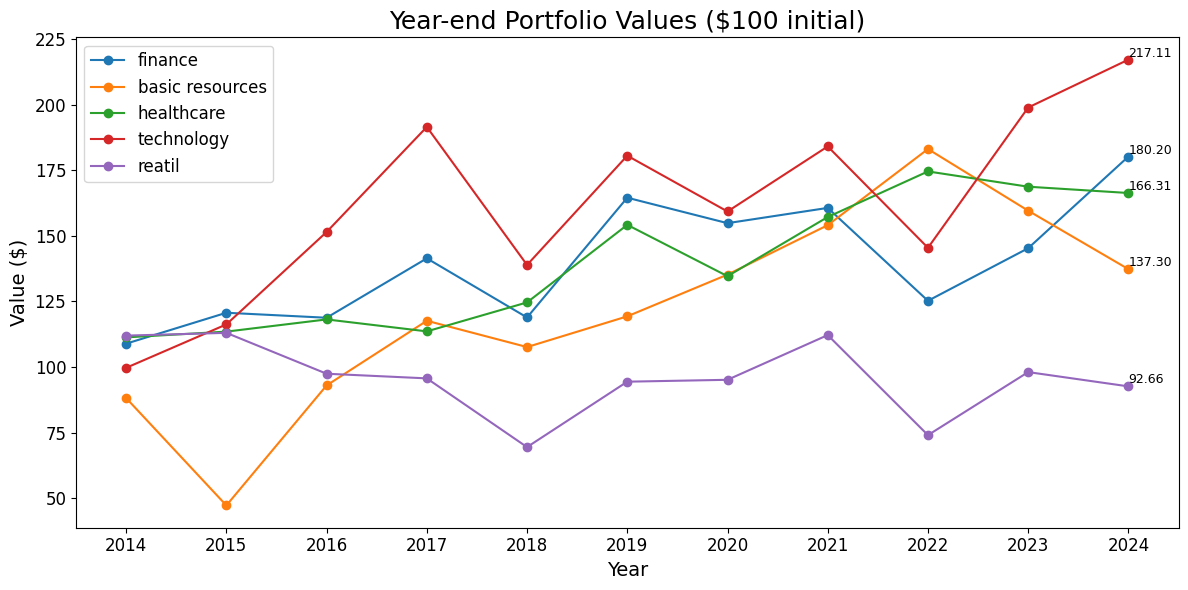

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def year_end_portfolio_values(folder_path, investment=100.0, start_year=2014, end_year=2024):
    dataframes, stock_names = load_all_csvs(folder_path)
    years = list(range(start_year, end_year + 1))
    out = pd.DataFrame(index=years)

    for df, name in zip(dataframes, stock_names):
        d = df.copy()
        d.columns = [c.lower() for c in d.columns]
        if 'date' not in d.columns or 'close' not in d.columns:
            continue
        d['date'] = pd.to_datetime(d['date'], errors='coerce')
        d['close'] = pd.to_numeric(d['close'], errors='coerce')
        d = d.dropna(subset=['date', 'close']).sort_values('date')
        if d.empty:
            continue

        buy_price = d['close'].iloc[0]
        if buy_price <= 0:
            continue
        shares = investment / buy_price

        close_by_year = d.groupby(d['date'].dt.year)['close'].last()
        values_by_year = (close_by_year * shares).reindex(years, fill_value=np.nan)
        out[name] = values_by_year

    return out  # index=years, columns=stock names, values=$ at each year-end

def plot_year_end_portfolio_values(yearly_values_df, title="Year-end Portfolio Values ($100 initial)"):
    fig, ax = plt.subplots(figsize=(12, 6))
    x = yearly_values_df.index.tolist()

    for col in yearly_values_df.columns:
        y = yearly_values_df[col].values.tolist()
        ax.plot(x, y, marker='o', label=col)
        valid = yearly_values_df[col].dropna()
        if not valid.empty:
            ax.text(valid.index[-1], valid.iloc[-1], f"{valid.iloc[-1]:.2f}", va='bottom', ha='left', fontsize=9)

    ax.set_xlabel("Year")
    ax.set_ylabel("Value ($)")
    ax.set_xticks(x)
    ax.set_title(title)
    ax.legend()
    plt.tight_layout()
    plt.show()


folder = '/content/content/sample_data/stocks'
yearly = year_end_portfolio_values(folder, investment=100.0, start_year=2014, end_year=2024)
print(yearly)
plot_year_end_portfolio_values(yearly)